In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import gridspec

from sklearn.metrics import roc_auc_score
import joblib

import flows as fnn
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

no_cuda=True
CUDA = not no_cuda and torch.cuda.is_available()

device = torch.device("cuda" if CUDA else "cpu")
device = torch.device("cuda:1")

# Cofigure tunable params

In [2]:
mu_values = np.arange(0,50)/10
plotDir = "plots/Toy/"
nBins = 10
aug_NN = False # if training NN for data augmentation instead of LDA- feature removed

In [3]:
useAuxZMeasure = False
#useAuxZMeasure = True

if useAuxZMeasure:
    plotDir = "plots/Toy/AuxMeasure/"

In [4]:
clfCol = "b"; aweCol = "g"; augCol = "y"; invCol = "r"; clfNomCol = "k"

In [5]:
n_events = n_z = 2 * 10**6 # dataset size per z
feature_std = 0.7; r = 1. 

z_nominal = np.pi/4
z_std = 0.5

n_shifts = 21
syst_shifts = np.arange(0,21)/10 # [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]
assert len(syst_shifts)==n_shifts
z_syst =  z_nominal * syst_shifts
systUp = z_nominal * syst_shifts[-1]

In [6]:
# This function returns the flow model
def get_flow_model(settings):
    modules = []
    for _ in range(settings['num_blocks']):
        modules += [
            fnn.MADE(settings['num_inputs'], settings['num_hidden'], num_cond_inputs=settings['num_cond'], act=settings['activation'],
            pre_exp_tanh=settings['pre_exp_tanh']),
            fnn.Reverse(settings['num_inputs'])
        ]
    model = fnn.FlowSequential(*modules)
    for module in model.modules():
        if isinstance(module, nn.Linear):
            nn.init.orthogonal_(module.weight)
            if hasattr(module, 'bias') and module.bias is not None:
                module.bias.data.fill_(0)
    model.to(settings['device'])
    return model    



# Generate Dataset

In [6]:


X_sig_syst = np.array([np.vstack( [np.random.normal(0, feature_std, n_events), np.random.normal(0, feature_std, n_events)]).T 
              for i in range (n_shifts)])
Y_sig_syst = np.array([np.ones(n_events) for i in range (n_shifts)])
centres_sig_syst = np.array([r* np.vstack([np.cos(z_syst[i]), np.sin(z_syst[i])]).T for i in range(n_shifts)])
X_sig_syst += centres_sig_syst

X_back_syst = np.array([np.vstack( [np.random.normal(0, feature_std, n_events), np.random.normal(0, feature_std, n_events)]).T
                        for i in range (n_shifts)])
Y_back_syst = np.array([np.zeros(n_events) for i in range (n_shifts)])
centres_back_syst = np.array([r* np.vstack([-np.cos(z_syst[i]), -np.sin(z_syst[i])]).T for i in range(n_shifts)])
X_back_syst += centres_back_syst

X_syst = np.concatenate([X_sig_syst,X_back_syst], 1)
Y_syst = np.hstack([Y_sig_syst,Y_back_syst])
Z_syst  = np.ones_like(Y_syst) * z_syst.reshape(-1,1)

X_syst = X_syst.reshape(-1,X_syst.shape[-1])
Y_syst = Y_syst.reshape(-1)
Z_syst = Z_syst.reshape(-1)

## Shuffle and split train test

In [10]:
from sklearn.model_selection import train_test_split
X_syst_train, X_syst_test, Y_syst_train, Y_syst_test, Z_syst_train, Z_syst_test  = train_test_split(X_syst,Y_syst,Z_syst, shuffle=True)
print(X_syst_train.shape, X_syst_test.shape, Y_syst_train.shape, Y_syst_test.shape, Z_syst_train.shape, Z_syst_test.shape)

(63000000, 2) (21000000, 2) (63000000,) (21000000,) (63000000,) (21000000,)


In [8]:
n_data = 500000
true_mu = 1; # variable never used
sigScaling = 1/(10**3.) # because signal is usually much smaller than background but we produced equal
backScaling = sigScaling*100 

n_shifts_train = 71
syst_shifts_train = np.arange(-20,51)/10
z_syst_train =  z_nominal * syst_shifts_train



X_sig_syst_train = np.array([np.vstack( [np.random.normal(0, feature_std, n_data), np.random.normal(0, feature_std, n_data)]).T 
              for i in range (n_shifts_train)])
Y_sig_syst_train = np.array([np.ones(n_data) for i in range (n_shifts_train)])
centres_sig_syst_train = np.array([r* np.vstack([np.cos(z_syst_train[i]), np.sin(z_syst_train[i])]).T for i in range(n_shifts_train)])
X_sig_syst_train += centres_sig_syst_train

X_back_syst_train = np.array([np.vstack( [np.random.normal(0, feature_std, n_data), np.random.normal(0, feature_std, n_data)]).T
                        for i in range (n_shifts_train)])
Y_back_syst_train = np.array([np.zeros(n_data) for i in range (n_shifts_train)])
centres_back_syst_train = np.array([r* np.vstack([-np.cos(z_syst_train[i]), -np.sin(z_syst_train[i])]).T for i in range(n_shifts_train)])
X_back_syst_train += centres_back_syst_train

X_syst_train = np.concatenate([X_sig_syst_train,X_back_syst_train], 1)
Y_syst_train = np.hstack([Y_sig_syst_train,Y_back_syst_train])
Z_syst_train  = np.ones_like(Y_syst_train) * z_syst_train.reshape(-1,1)


X_syst_train = X_syst_train.reshape(-1,X_syst_train.shape[-1])
Y_syst_train = Y_syst_train.reshape(-1)
Z_syst_train = Z_syst_train.reshape(-1)


weights_syst_train = np.ones_like(Y_syst_train)
weights_syst_train[Y_syst_train==1] *=sigScaling
weights_syst_train[Y_syst_train==0] *=backScaling


In [12]:
size_batch = 10000
n_batch = X_syst_train.shape[0]//size_batch
epochs = 20


weight_decay = 0.0e-6



# define model settings:
current_settings = {
    # number of MADE blocks
    'num_blocks' : 8,
    # number of actual input variables (NOT counting the conditional inputs)
    'num_inputs' : 2,
    # number of nodes in hidden layers
    'num_hidden' : 31,
    # number of conditional variables
    'num_cond' : 2,
    # activation function to use in the MADE blocks (can be relu, sigmoid or tanh):
    'activation' : 'relu',
    # apply tanh function before calculating the logprobs. This is a recommended setting, as it helps with getting infs/nans in the loss
    'pre_exp_tanh' : True,
    # current pytorch device (CPU or GPU)
    'device' : device,
    
} 



# create model

def train_flow(log_scale_data=False, use_log_prob=True, double_scale=False, learning_rate = 1.0e-4):
    model = get_flow_model(current_settings)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    permut = np.random.permutation(X_syst_train.shape[0])
    
    X_syst_train_shuffle = np.array(X_syst_train[permut])
    Y_syst_train_shuffle = np.array(Y_syst_train[permut])
    Z_syst_train_shuffle = np.array(Z_syst_train[permut])
    weights_syst_train_shuffle = np.array(weights_syst_train[permut])
    
    for epoch in range(1, epochs + 1):
        print(f"Starting epoch {epoch}...")
        model.train()
        now_loss = 0
        for i_batch in range(0, n_batch):

            #if isinstance(batch_data, list):
            x_data = torch.tensor(X_syst_train_shuffle[i_batch*size_batch:(1+i_batch)*size_batch]).to(current_settings["device"])
            y_data = torch.tensor(Y_syst_train_shuffle[i_batch*size_batch:(1+i_batch)*size_batch]).to(current_settings["device"])
            z_data = torch.tensor(Z_syst_train_shuffle[i_batch*size_batch:(1+i_batch)*size_batch]).to(current_settings["device"])
            mu_data = (torch.torch.rand(z_data.size())*5.0).to(current_settings["device"])
            
            
            weight = torch.tensor(weights_syst_train_shuffle[i_batch*size_batch:(1+i_batch)*size_batch]).to(current_settings["device"])
            weight[y_data==1] = weight[y_data==1]*mu_data[y_data==1]
            weight = weight.view(-1,1)
            #print(y_data)
            
            inputs = torch.cat((z_data.view(-1, 1), mu_data.view(-1, 1)), 1).float()/10.0
            
            
            optimizer.zero_grad()
            
            log_prob = model.log_probs(inputs, cond_inputs = x_data.float())
            
            loss_vals = log_prob*weight

            loss = -loss_vals.mean()

            loss.backward()
            optimizer.step()
            
            if i_batch%100 == 0:
                print('Epoch: {:d}, Batch: {:d}, Loss: {:.4f}'.format(epoch, i_batch, loss))
                
            #if i_batch == 20000:
            #    break
        
    return model




model = train_flow()


NameError: name 'get_flow_model' is not defined

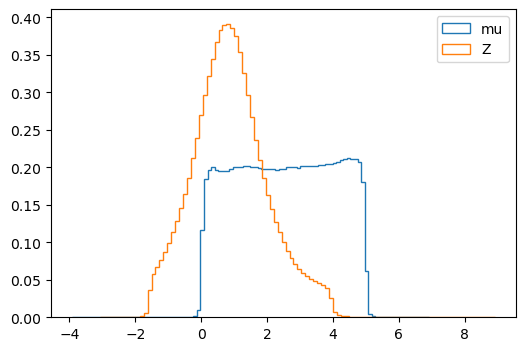

In [88]:
### Single experiment x1000 nominal z
n_data = 500000

n_exp = 1
n_data_nom = n_data

X_sig_data_nom = np.random.normal(0, feature_std, (n_exp, int(n_data_nom*sigScaling), 2))
Y_sig_data_nom = np.ones((n_exp, int(n_data_nom*sigScaling)))

Z_incarnation = np.array([z_nominal])
centres_sig_data_nom = np.expand_dims(r* np.vstack([np.cos(Z_incarnation), np.sin(Z_incarnation)]).T, 1)\

X_sig_data_nom += centres_sig_data_nom


X_back_data_nom = np.random.normal(0, feature_std, (n_exp, int(n_data_nom*backScaling), 2))
Y_back_data_nom = np.zeros((n_exp, int(n_data_nom*backScaling)))

centres_back_data_nom = np.expand_dims(r* np.vstack([-np.cos(Z_incarnation), -np.sin(Z_incarnation)]).T, 1)

X_back_data_nom += centres_back_data_nom

X_data_nom = np.concatenate([X_sig_data_nom,X_back_data_nom], 1)
Y_data_nom = np.hstack([Y_sig_data_nom,Y_back_data_nom])
Z_data_nom = np.zeros_like(Y_data_nom) + np.expand_dims(Z_incarnation, 1)

weights_data_nom = np.ones_like(Y_data_nom)


out = []

for i in range(0, 100):
    with torch.no_grad():
        outputs_flow = model.sample(num_samples = X_data_nom[0].shape[0], noise=None, cond_inputs=torch.tensor(X_data_nom[0]).float()).cpu().numpy()
        out.append(outputs_flow*10.0)
out = np.vstack(out)


fig = plt.figure(figsize=(6,4))
subplot = fig.add_subplot(1,1,1)   

#inputs = torch.cat((z_data.view(-1, 1), mu_data.view(-1, 1)), 1).float()/10.0
#out[:,0]: z
#out[:,1]: mu

c, bins, _ = subplot.hist(out[:,1], histtype='step', label ='mu', linewidth = 1, linestyle = '-', alpha = 1.0, density=True, bins=100)
c, bins, _ = subplot.hist(out[:,0], histtype='step', label ='Z', linewidth = 1, linestyle = '-', alpha = 1.0, density=True, bins=100)
subplot.legend()

In [89]:
nll2d = np.zeros((51, len(z_syst_train)))

for i, mu in enumerate(np.arange(-0.0, 5.1, 0.1)):
    for j, z in enumerate(z_syst_train):
    
    
        dat = torch.tensor(X_data_nom[0]).float().to(device)
        mus = (torch.ones((dat.size(0), 1))*mu).to(device)
        zs  = (torch.ones((dat.size(0), 1))*z).to(device)
        
        inputs = torch.cat((zs, mus), 1)/10.0
        #print(inputs)
        
        with torch.no_grad():
            log_prob = - model.log_probs(inputs, cond_inputs = dat)
            nll2d[i,j] = nll2d[i,j] + np.mean(log_prob.cpu().numpy())
        

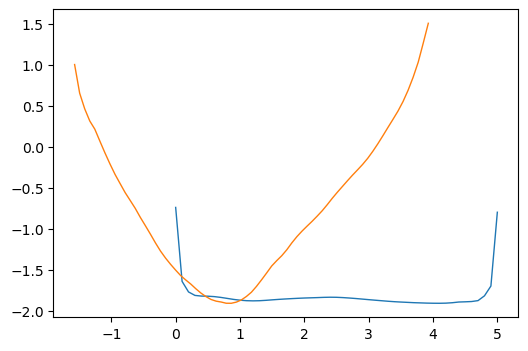

In [90]:
nll1d_mu = np.min(nll2d, 1)
nll1d_z = np.min(nll2d, 0)

fig = plt.figure(figsize=(6,4))
subplot = fig.add_subplot(1,1,1)   

#subplot.set_ylim(-4, 10)

subplot.plot(np.arange(-0.0, 5.1, 0.1), nll1d_mu, label ='Flow', linewidth = 1, linestyle = '-', alpha = 1.0)
subplot.plot(z_syst_train, nll1d_z, label ='Flow', linewidth = 1, linestyle = '-', alpha = 1.0)


In [33]:
class nominalModel:
    def predict(self,X):
        from scipy.stats import multivariate_normal
        angle = np.pi/4
        rv_signal = multivariate_normal((np.cos(angle),np.sin(angle)),(feature_std,feature_std)).pdf
        rv_back = multivariate_normal((-np.cos(angle),-np.sin(angle)),(feature_std,feature_std)).pdf
        score = rv_signal(X)/(rv_signal(X) + rv_back(X))
        return score
nominal_model = nominalModel()

#Y_predict_nomOnSys = nominal_model.predict(X_syst_test[systUpEvents]).reshape(-1)
#Y_predict_nomOnnom = nominal_model.predict(X_syst_test[nominalEvents]).reshape(-1)

In [59]:
size_batch = 10000
n_batch = X_syst_train.shape[0]//size_batch
epochs = 3







# define model settings:
current_settings = {
    # number of MADE blocks
    'num_blocks' : 4,
    # number of actual input variables (NOT counting the conditional inputs)
    'num_inputs' : 2,
    # number of nodes in hidden layers
    'num_hidden' : 16,
    # number of conditional variables
    'num_cond' : 1,
    # activation function to use in the MADE blocks (can be relu, sigmoid or tanh):
    'activation' : 'relu',
    # apply tanh function before calculating the logprobs. This is a recommended setting, as it helps with getting infs/nans in the loss
    'pre_exp_tanh' : True,
    # current pytorch device (CPU or GPU)
    'device' : device,
    
} 
 
# create model

def train_flow(log_scale_data=False, use_log_prob=True, double_scale=False, learning_rate = 1.0e-3):
    model = get_flow_model(current_settings)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    permut = np.random.permutation(X_syst_train.shape[0])
    
    X_syst_train_shuffle = np.array(X_syst_train[permut])
    Y_syst_train_shuffle = np.array(Y_syst_train[permut])
    Z_syst_train_shuffle = np.array(Z_syst_train[permut])
    weights_syst_train_shuffle = np.array(weights_syst_train[permut])
    
    for epoch in range(1, epochs + 1):
        print(f"Starting epoch {epoch}...")
        model.train()
        now_loss = 0
        for i_batch in range(0, n_batch):

            #if isinstance(batch_data, list):
            x_data = nominal_model.predict(X_syst_train_shuffle[i_batch*size_batch:(1+i_batch)*size_batch])
            x_data = torch.tensor(x_data).to(current_settings["device"]).view(-1,1)
            y_data = torch.tensor(Y_syst_train_shuffle[i_batch*size_batch:(1+i_batch)*size_batch]).to(current_settings["device"])
            z_data = torch.tensor(Z_syst_train_shuffle[i_batch*size_batch:(1+i_batch)*size_batch]).to(current_settings["device"])
            mu_data = (torch.torch.rand(z_data.size())*5.0).to(current_settings["device"])
            
            
            weight = torch.tensor(weights_syst_train_shuffle[i_batch*size_batch:(1+i_batch)*size_batch]).to(current_settings["device"])
            weight[y_data==1] = weight[y_data==1]*mu_data[y_data==1]
            weight = weight.view(-1,1)
            
            inputs = torch.cat((z_data.view(-1, 1), mu_data.view(-1, 1)), 1).float()
            
            
            optimizer.zero_grad()
            
            log_prob = model.log_probs(inputs, cond_inputs = x_data.float())
            
            loss_vals = log_prob*weight
            print(loss_vals.shape)
            break
            loss = -loss_vals.mean()

            loss.backward()
            optimizer.step()
            
            if i_batch%200 == 0:
                print('Epoch: {:d}, Batch: {:d}'.format(epoch, i_batch))
                
            #if i_batch == 20000:
            #    break
        
    return model




model = train_flow()


Starting epoch 1...
torch.Size([10000, 10000])
Starting epoch 2...
torch.Size([10000, 10000])
Starting epoch 3...
torch.Size([10000, 10000])


In [38]:
nll2d = np.zeros((51, len(z_syst_train)))

for i, mu in enumerate(np.arange(-0.0, 5.1, 0.1)):
    for j, z in enumerate(z_syst_train):
    
    
        
        dat = nominal_model.predict(X_data_nom[0])
        dat = torch.tensor(dat).to(current_settings["device"]).view(-1,1).float()
        mus = (torch.ones((dat.size(0), 1))*mu).to(device)
        zs  = (torch.ones((dat.size(0), 1))*z).to(device)


        inputs = torch.cat((zs, mus), 1)
        #print(inputs)
        
        with torch.no_grad():
            log_prob = - model.log_probs(inputs, cond_inputs = dat)
            nll2d[i,j] = nll2d[i,j] + np.mean(log_prob.cpu().numpy())
        

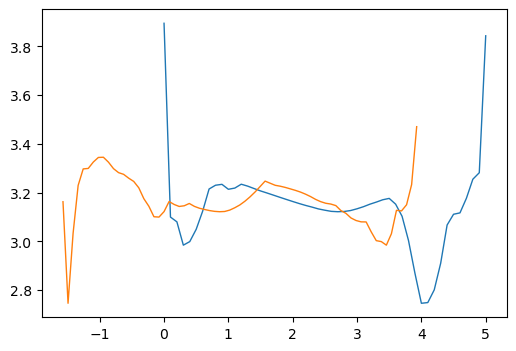

In [39]:
nll1d_mu = np.min(nll2d, 1)
nll1d_z = np.min(nll2d, 0)

fig = plt.figure(figsize=(6,4))
subplot = fig.add_subplot(1,1,1)   

subplot.plot(np.arange(-0.0, 5.1, 0.1), nll1d_mu, label ='Flow', linewidth = 1, linestyle = '-', alpha = 1.0)
subplot.plot(z_syst_train, nll1d_z, label ='Flow', linewidth = 1, linestyle = '-', alpha = 1.0)


In [76]:
size_batch = 10000
n_batch = X_syst_train.shape[0]//size_batch
epochs = 3


weight_decay = 0.0e-6



# define model settings:
current_settings = {
    # number of MADE blocks
    'num_blocks' : 8,
    # number of actual input variables (NOT counting the conditional inputs)
    'num_inputs' : 2,
    # number of nodes in hidden layers
    'num_hidden' : 16,
    # number of conditional variables
    'num_cond' : 2,
    # activation function to use in the MADE blocks (can be relu, sigmoid or tanh):
    'activation' : 'relu',
    # apply tanh function before calculating the logprobs. This is a recommended setting, as it helps with getting infs/nans in the loss
    'pre_exp_tanh' : True,
    # current pytorch device (CPU or GPU)
    'device' : device,
    
} 



# create model

def train_flow(log_scale_data=False, use_log_prob=True, double_scale=False, learning_rate = 1.0e-4):
    model = get_flow_model(current_settings)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    permut = np.random.permutation(X_syst_train.shape[0])
    
    X_syst_train_shuffle = np.array(X_syst_train[permut])
    Y_syst_train_shuffle = np.array(Y_syst_train[permut])
    Z_syst_train_shuffle = np.array(Z_syst_train[permut])
    weights_syst_train_shuffle = np.array(weights_syst_train[permut])
    
    for epoch in range(1, epochs + 1):
        print(f"Starting epoch {epoch}...")
        model.train()
        now_loss = 0
        for i_batch in range(0, n_batch):

            #if isinstance(batch_data, list):
            x_data = torch.tensor(X_syst_train_shuffle[i_batch*size_batch:(1+i_batch)*size_batch]).to(current_settings["device"])
            y_data = torch.tensor(Y_syst_train_shuffle[i_batch*size_batch:(1+i_batch)*size_batch]).to(current_settings["device"])
            z_data = torch.tensor(Z_syst_train_shuffle[i_batch*size_batch:(1+i_batch)*size_batch]).to(current_settings["device"])
            #mu_data = (torch.torch.rand(z_data.size())*5.0).to(current_settings["device"])
            
            pad_data = (torch.torch.randn(z_data.size())).to(current_settings["device"])

            weight = torch.tensor(weights_syst_train_shuffle[i_batch*size_batch:(1+i_batch)*size_batch]).to(current_settings["device"])
            #weight[y_data==1] = weight[y_data==1]*mu_data[y_data==1]
            weight = weight.view(-1,1)

            inputs = torch.cat((z_data.view(-1, 1), pad_data.view(-1, 1)), 1).float()/10.0
            
            
            optimizer.zero_grad()
            
            log_prob = model.log_probs(inputs, cond_inputs = x_data.float())
            
            loss_vals = log_prob*weight
            
            loss = -loss_vals.mean()

            loss.backward()
            optimizer.step()
            
            if i_batch%100 == 0:
                print('Epoch: {:d}, Batch: {:d}, Loss: {:.4f}'.format(epoch, i_batch, loss))
                
            #if i_batch == 20000:
            #    break
        
    return model




model = train_flow()


Starting epoch 1...
Epoch: 1, Batch: 0, Loss: 0.0868
Epoch: 1, Batch: 100, Loss: 0.0444
Epoch: 1, Batch: 200, Loss: 0.0032
Epoch: 1, Batch: 300, Loss: -0.0317
Epoch: 1, Batch: 400, Loss: -0.0595
Epoch: 1, Batch: 500, Loss: -0.0750
Epoch: 1, Batch: 600, Loss: -0.0800
Epoch: 1, Batch: 700, Loss: -0.0839
Epoch: 1, Batch: 800, Loss: -0.0866
Epoch: 1, Batch: 900, Loss: -0.0874
Epoch: 1, Batch: 1000, Loss: -0.0905
Epoch: 1, Batch: 1100, Loss: -0.0897
Epoch: 1, Batch: 1200, Loss: -0.0916
Epoch: 1, Batch: 1300, Loss: -0.0921
Epoch: 1, Batch: 1400, Loss: -0.0900
Epoch: 1, Batch: 1500, Loss: -0.0949
Epoch: 1, Batch: 1600, Loss: -0.0954
Epoch: 1, Batch: 1700, Loss: -0.0918
Epoch: 1, Batch: 1800, Loss: -0.0946
Epoch: 1, Batch: 1900, Loss: -0.0951
Epoch: 1, Batch: 2000, Loss: -0.0939
Epoch: 1, Batch: 2100, Loss: -0.0986
Epoch: 1, Batch: 2200, Loss: -0.0927
Epoch: 1, Batch: 2300, Loss: -0.0959
Epoch: 1, Batch: 2400, Loss: -0.0950
Epoch: 1, Batch: 2500, Loss: -0.0976
Epoch: 1, Batch: 2600, Loss: -0.0

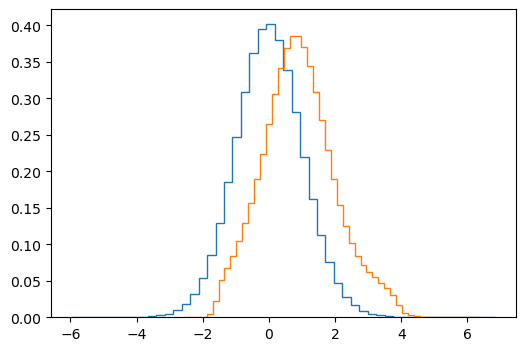

In [78]:
### Single experiment x1000 nominal z
n_data = 500000

n_exp = 1
n_data_nom = n_data

X_sig_data_nom = np.random.normal(0, feature_std, (n_exp, int(n_data_nom*sigScaling), 2))
Y_sig_data_nom = np.ones((n_exp, int(n_data_nom*sigScaling)))

Z_incarnation = np.array([z_nominal])
centres_sig_data_nom = np.expand_dims(r* np.vstack([np.cos(Z_incarnation), np.sin(Z_incarnation)]).T, 1)\

X_sig_data_nom += centres_sig_data_nom


X_back_data_nom = np.random.normal(0, feature_std, (n_exp, int(n_data_nom*backScaling), 2))
Y_back_data_nom = np.zeros((n_exp, int(n_data_nom*backScaling)))

centres_back_data_nom = np.expand_dims(r* np.vstack([-np.cos(Z_incarnation), -np.sin(Z_incarnation)]).T, 1)

X_back_data_nom += centres_back_data_nom

X_data_nom = np.concatenate([X_sig_data_nom,X_back_data_nom], 1)
Y_data_nom = np.hstack([Y_sig_data_nom,Y_back_data_nom])
Z_data_nom = np.zeros_like(Y_data_nom) + np.expand_dims(Z_incarnation, 1)

weights_data_nom = np.ones_like(Y_data_nom)
out = []

for i in range(0, 100):
    with torch.no_grad():
        outputs_flow = model.sample(num_samples = X_data_nom[0].shape[0], noise=None, cond_inputs=torch.tensor(X_data_nom[0]).float()).cpu().numpy()
        out.append(outputs_flow*10.0)
out = np.vstack(out)


fig = plt.figure(figsize=(6,4))
subplot = fig.add_subplot(1,1,1)   

c, bins, _ = subplot.hist(out[:,1], histtype='step', label ='Flow', linewidth = 1, linestyle = '-', alpha = 1.0, density=True, bins=50)
c, bins, _ = subplot.hist(out[:,0], histtype='step', label ='Flow', linewidth = 1, linestyle = '-', alpha = 1.0, density=True, bins=50)


In [79]:
nll2d = np.zeros((51, len(z_syst_train)))

for i, mu in enumerate(np.arange(-0.0, 5.1, 0.1)):
    for j, z in enumerate(z_syst_train):
    
    
        dat = torch.tensor(X_data_nom[0]).float().to(device)
        mus = (torch.ones((dat.size(0), 1))*mu).to(device)
        zs  = (torch.ones((dat.size(0), 1))*z).to(device)
        
        inputs = torch.cat((zs, mus), 1)/10.0
        #print(inputs)
        
        with torch.no_grad():
            log_prob = - model.log_probs(inputs, cond_inputs = dat)
            nll2d[i,j] = nll2d[i,j] + np.mean(log_prob.cpu().numpy())
        

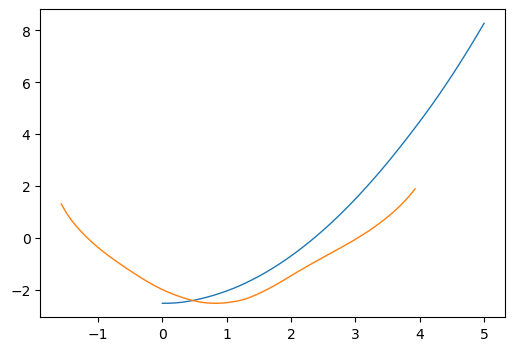

In [80]:
nll1d_mu = np.min(nll2d, 1)
nll1d_z = np.min(nll2d, 0)

fig = plt.figure(figsize=(6,4))
subplot = fig.add_subplot(1,1,1)   

#subplot.set_ylim(-4, 10)

subplot.plot(np.arange(-0.0, 5.1, 0.1), nll1d_mu, label ='Flow', linewidth = 1, linestyle = '-', alpha = 1.0)
subplot.plot(z_syst_train, nll1d_z, label ='Flow', linewidth = 1, linestyle = '-', alpha = 1.0)


In [16]:
sigScaling = 0.1/100.0
backScaling = 0.1


nom_shifts_train = np.ones(n_shifts_train)
z_nom_train =  z_nominal * nom_shifts_train

X_sig_nom_train = np.array([np.vstack( [np.random.normal(0, feature_std, n_data), np.random.normal(0, feature_std, n_data)]).T 
              for i in range (n_shifts_train)])
Y_sig_nom_train = np.array([np.ones(n_data) for i in range (n_shifts_train)])
centres_sig_nom_train = np.array([r* np.vstack([np.cos(z_nom_train[i]), np.sin(z_nom_train[i])]).T for i in range(n_shifts_train)])
X_sig_nom_train += centres_sig_nom_train

X_back_nom_train = np.array([np.vstack( [np.random.normal(0, feature_std, n_data), np.random.normal(0, feature_std, n_data)]).T
                        for i in range (n_shifts_train)])
Y_back_nom_train = np.array([np.zeros(n_data) for i in range (n_shifts_train)])
centres_back_nom_train = np.array([r* np.vstack([-np.cos(z_nom_train[i]), -np.sin(z_nom_train[i])]).T for i in range(n_shifts_train)])
X_back_nom_train += centres_back_nom_train

X_nom_train = np.concatenate([X_sig_nom_train,X_back_nom_train], 1)
Y_nom_train = np.hstack([Y_sig_nom_train,Y_back_nom_train])
Z_nom_train  = np.ones_like(Y_nom_train) * z_nom_train.reshape(-1,1)


X_nom_train = X_nom_train.reshape(-1,X_nom_train.shape[-1])
Y_nom_train = Y_nom_train.reshape(-1)
Z_nom_train = Z_nom_train.reshape(-1)


weights_nom_train = np.ones_like(Y_nom_train)
weights_nom_train[Y_nom_train==1] *=sigScaling
weights_nom_train[Y_nom_train==0] *=backScaling


In [19]:
permut = np.random.permutation(X_nom_train.shape[0])

X_nom_train_shuffle = np.array(X_nom_train[permut])
Y_nom_train_shuffle = np.array(Y_nom_train[permut])
Z_nom_train_shuffle = np.array(Z_nom_train[permut])
weights_nom_train_shuffle = np.array(weights_nom_train[permut])

In [39]:
size_batch = 10000
n_batch = X_nom_train.shape[0]//size_batch
epochs = 4


weight_decay = 0.0e-6



# define model settings:
current_settings = {
    # number of MADE blocks
    'num_blocks' : 8,
    # number of actual input variables (NOT counting the conditional inputs)
    'num_inputs' : 2,
    # number of nodes in hidden layers
    'num_hidden' : 32,
    # number of conditional variables
    'num_cond' : 6,
    # activation function to use in the MADE blocks (can be relu, sigmoid or tanh):
    'activation' : 'relu',
    # apply tanh function before calculating the logprobs. This is a recommended setting, as it helps with getting infs/nans in the loss
    'pre_exp_tanh' : True,
    # current pytorch device (CPU or GPU)
    'device' : device,
    
} 



# create model

def train_flow(log_scale_data=False, use_log_prob=True, double_scale=False, learning_rate = 1.0e-4):
    model = get_flow_model(current_settings)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    #permut = np.random.permutation(X_nom_train.shape[0])
    #X_nom_train_shuffle = np.array(X_nom_train[permut])
    #Y_nom_train_shuffle = np.array(Y_nom_train[permut])
    #Z_nom_train_shuffle = np.array(Z_nom_train[permut])
    #weights_nom_train_shuffle = np.array(weights_nom_train[permut])
    
    for epoch in range(1, epochs + 1):
        print(f"Starting epoch {epoch}...")
        model.train()
        now_loss = 0
        for i_batch in range(0, n_batch):

            #if isinstance(batch_data, list):

            y_data = torch.tensor(Y_nom_train_shuffle[i_batch*size_batch:(1+i_batch)*size_batch]).to(current_settings["device"])
            z_data = torch.tensor(Z_nom_train_shuffle[i_batch*size_batch:(1+i_batch)*size_batch]).to(current_settings["device"])
            
            pad_data = (torch.torch.randn(z_data.size())).to(current_settings["device"])
            mu_data = ((torch.torch.rand(1)*5.0)*torch.torch.ones(z_data.size())).to(current_settings["device"])
                        
            weight = torch.tensor(weights_nom_train_shuffle[i_batch*size_batch:(1+i_batch)*size_batch]).to(current_settings["device"])
            weight[y_data==1] = weight[y_data==1]*mu_data[y_data==1]
            weight_np = weight.cpu().numpy()
            weight = weight.view(-1,1)

            #print(y_data)
            
            x_data = X_nom_train_shuffle[i_batch*size_batch:(1+i_batch)*size_batch]
            
            x_batch_data_avg = np.average(x_data, weights=weight_np, axis=0)
            x_batch_data_std = np.sqrt(np.average((x_data-x_batch_data_avg)**2, weights=weight_np, axis=0))
            
            x_data = torch.tensor(x_data).to(current_settings["device"])            
            x_batch_data_avg = torch.tensor(x_batch_data_avg).to(current_settings["device"]).view(1,-1).repeat(x_data.size(0), 1)
            x_batch_data_std = torch.tensor(x_batch_data_std).to(current_settings["device"]).view(1,-1).repeat(x_data.size(0), 1)

            
            inputs = torch.cat((pad_data.view(-1, 1), mu_data.view(-1, 1)), 1).float()/10.0
            
            cond_inputs = torch.cat((x_data,
                                     x_batch_data_avg,
                                     x_batch_data_std), 1)
            
            
            optimizer.zero_grad()
            
            log_prob = model.log_probs(inputs, cond_inputs = cond_inputs.float())
            
            loss_vals = log_prob*weight

            loss = -loss_vals.mean()

            loss.backward()
            optimizer.step()
            
            if i_batch%100 == 0:
                print('Epoch: {:d}, Batch: {:d}, Loss: {:.4f}'.format(epoch, i_batch, loss))
                
            #if i_batch == 20000:
            #    break
        
    return model




model = train_flow()


Starting epoch 1...
Epoch: 1, Batch: 0, Loss: 0.1031
Epoch: 1, Batch: 100, Loss: 0.0059
Epoch: 1, Batch: 200, Loss: -0.0586
Epoch: 1, Batch: 300, Loss: -0.0827
Epoch: 1, Batch: 400, Loss: -0.0798
Epoch: 1, Batch: 500, Loss: -0.0713
Epoch: 1, Batch: 600, Loss: -0.0391
Epoch: 1, Batch: 700, Loss: -0.0325
Epoch: 1, Batch: 800, Loss: -0.0888
Epoch: 1, Batch: 900, Loss: -0.0909
Epoch: 1, Batch: 1000, Loss: -0.0974
Epoch: 1, Batch: 1100, Loss: -0.0982
Epoch: 1, Batch: 1200, Loss: -0.0751
Epoch: 1, Batch: 1300, Loss: -0.0324
Epoch: 1, Batch: 1400, Loss: -0.0981
Epoch: 1, Batch: 1500, Loss: -0.0556
Epoch: 1, Batch: 1600, Loss: -0.0824
Epoch: 1, Batch: 1700, Loss: -0.0796
Epoch: 1, Batch: 1800, Loss: -0.0903
Epoch: 1, Batch: 1900, Loss: -0.0951
Epoch: 1, Batch: 2000, Loss: -0.0923
Epoch: 1, Batch: 2100, Loss: -0.0697
Epoch: 1, Batch: 2200, Loss: -0.0657
Epoch: 1, Batch: 2300, Loss: -0.0926
Epoch: 1, Batch: 2400, Loss: -0.0922
Epoch: 1, Batch: 2500, Loss: -0.0885
Epoch: 1, Batch: 2600, Loss: -0.

Epoch: 4, Batch: 800, Loss: -0.1607
Epoch: 4, Batch: 900, Loss: -0.1592
Epoch: 4, Batch: 1000, Loss: -0.1617
Epoch: 4, Batch: 1100, Loss: -0.1648
Epoch: 4, Batch: 1200, Loss: -0.1351
Epoch: 4, Batch: 1300, Loss: -0.1348
Epoch: 4, Batch: 1400, Loss: -0.1222
Epoch: 4, Batch: 1500, Loss: -0.1681
Epoch: 4, Batch: 1600, Loss: -0.1463
Epoch: 4, Batch: 1700, Loss: -0.1655
Epoch: 4, Batch: 1800, Loss: -0.0995
Epoch: 4, Batch: 1900, Loss: -0.1509
Epoch: 4, Batch: 2000, Loss: -0.1640
Epoch: 4, Batch: 2100, Loss: -0.1070
Epoch: 4, Batch: 2200, Loss: -0.0402
Epoch: 4, Batch: 2300, Loss: -0.1512
Epoch: 4, Batch: 2400, Loss: -0.1644
Epoch: 4, Batch: 2500, Loss: -0.1667
Epoch: 4, Batch: 2600, Loss: -0.1623
Epoch: 4, Batch: 2700, Loss: -0.1586
Epoch: 4, Batch: 2800, Loss: -0.1561
Epoch: 4, Batch: 2900, Loss: -0.1627
Epoch: 4, Batch: 3000, Loss: -0.1446
Epoch: 4, Batch: 3100, Loss: -0.1656
Epoch: 4, Batch: 3200, Loss: -0.1596
Epoch: 4, Batch: 3300, Loss: -0.1514
Epoch: 4, Batch: 3400, Loss: -0.1610
Epo

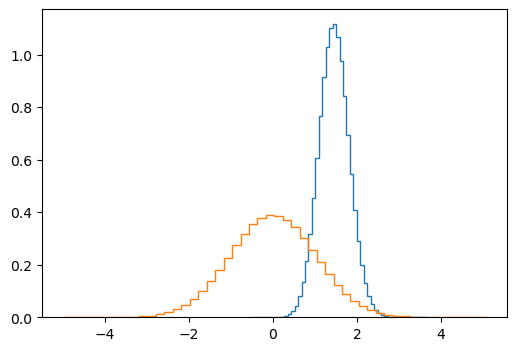

In [41]:
### Single experiment x1000 nominal z
n_data = 500000

n_exp = 1
n_data_nom = n_data

X_sig_data_nom = np.random.normal(0, feature_std, (n_exp, int(n_data_nom*sigScaling), 2))
Y_sig_data_nom = np.ones((n_exp, int(n_data_nom*sigScaling)))

Z_incarnation = np.array([z_nominal])
centres_sig_data_nom = np.expand_dims(r* np.vstack([np.cos(Z_incarnation), np.sin(Z_incarnation)]).T, 1)\

X_sig_data_nom += centres_sig_data_nom


X_back_data_nom = np.random.normal(0, feature_std, (n_exp, int(n_data_nom*backScaling), 2))
Y_back_data_nom = np.zeros((n_exp, int(n_data_nom*backScaling)))

centres_back_data_nom = np.expand_dims(r* np.vstack([-np.cos(Z_incarnation), -np.sin(Z_incarnation)]).T, 1)

X_back_data_nom += centres_back_data_nom

X_data_nom = np.concatenate([X_sig_data_nom,X_back_data_nom], 1)
Y_data_nom = np.hstack([Y_sig_data_nom,Y_back_data_nom])
Z_data_nom = np.zeros_like(Y_data_nom) + np.expand_dims(Z_incarnation, 1)

weights_data_nom = np.ones_like(Y_data_nom)
out = []


x_batch_data_avg = np.average(X_data_nom[0], weights=weights_data_nom[0], axis=0)
x_batch_data_std = np.sqrt(np.average((X_data_nom[0]-x_batch_data_avg)**2, weights=weights_data_nom[0], axis=0))

x_data = torch.tensor(X_data_nom[0]).to(current_settings["device"])            
x_batch_data_avg = torch.tensor(x_batch_data_avg).to(current_settings["device"]).view(1,-1).repeat(x_data.size(0), 1)
x_batch_data_std = torch.tensor(x_batch_data_std).to(current_settings["device"]).view(1,-1).repeat(x_data.size(0), 1)

cond_inputs = torch.cat((x_data, x_batch_data_avg, x_batch_data_std), 1)

for i in range(0, 100):
    with torch.no_grad():
        outputs_flow = model.sample(num_samples = X_data_nom[0].shape[0], noise=None, cond_inputs=cond_inputs.float()).cpu().numpy()
        out.append(outputs_flow*10.0)
out = np.vstack(out)


fig = plt.figure(figsize=(6,4))
subplot = fig.add_subplot(1,1,1)   

c, bins, _ = subplot.hist(out[:,1], histtype='step', label ='Flow', linewidth = 1, linestyle = '-', alpha = 1.0, density=True, bins=50)
c, bins, _ = subplot.hist(out[:,0], histtype='step', label ='Flow', linewidth = 1, linestyle = '-', alpha = 1.0, density=True, bins=50)


In [11]:
n_data = 500000
true_mu = 1; # variable never used
sigScaling = 1/(10**3.) # because signal is usually much smaller than background but we produced equal
backScaling = sigScaling*100 


n_shifts_train = 61
syst_shifts_train = np.arange(-20,41)/10
z_syst_train =  z_nominal * syst_shifts_train

#syst_shifts_train = np.ones(n_shifts_train)
#z_syst_train =  z_nominal * syst_shifts_train



X_sig_syst_train = np.array([np.vstack( [np.random.normal(0, feature_std, n_data), np.random.normal(0, feature_std, n_data)]).T 
              for i in range (n_shifts_train)])
Y_sig_syst_train = np.array([np.ones(n_data) for i in range (n_shifts_train)])
centres_sig_syst_train = np.array([r* np.vstack([np.cos(z_syst_train[i]), np.sin(z_syst_train[i])]).T for i in range(n_shifts_train)])
X_sig_syst_train += centres_sig_syst_train

X_back_syst_train = np.array([np.vstack( [np.random.normal(0, feature_std, n_data), np.random.normal(0, feature_std, n_data)]).T
                        for i in range (n_shifts_train)])
Y_back_syst_train = np.array([np.zeros(n_data) for i in range (n_shifts_train)])
centres_back_syst_train = np.array([r* np.vstack([-np.cos(z_syst_train[i]), -np.sin(z_syst_train[i])]).T for i in range(n_shifts_train)])
X_back_syst_train += centres_back_syst_train

X_syst_train = np.concatenate([X_sig_syst_train,X_back_syst_train], 1)
Y_syst_train = np.hstack([Y_sig_syst_train,Y_back_syst_train])
Z_syst_train  = np.ones_like(Y_syst_train) * z_syst_train.reshape(-1,1)


#X_syst_train = X_syst_train.reshape(-1,X_syst_train.shape[-1])
#Y_syst_train = Y_syst_train.reshape(-1)
#Z_syst_train = Z_syst_train.reshape(-1)


weights_syst_train = np.ones_like(Y_syst_train)
weights_syst_train[Y_syst_train==1] *=sigScaling
weights_syst_train[Y_syst_train==0] *=backScaling


print(X_syst_train.shape[0], X_syst_train.shape, Y_syst_train.shape, Z_syst_train.shape)


61 (61, 1000000, 2) (61, 1000000) (61, 1000000)


In [12]:
size_batch = 10000
n_batch = X_syst_train.shape[0]//size_batch
epochs = 20


weight_decay = 0.0e-6



# define model settings:
current_settings = {
    # number of MADE blocks
    'num_blocks' : 8,
    # number of actual input variables (NOT counting the conditional inputs)
    'num_inputs' : 2,
    # number of nodes in hidden layers
    'num_hidden' : 32,
    # number of conditional variables
    'num_cond' : 6,
    # activation function to use in the MADE blocks (can be relu, sigmoid or tanh):
    'activation' : 'relu',
    # apply tanh function before calculating the logprobs. This is a recommended setting, as it helps with getting infs/nans in the loss
    'pre_exp_tanh' : True,
    # current pytorch device (CPU or GPU)
    'device' : device,
    
} 



# create model

#def train_flow(log_scale_data=False, use_log_prob=True, double_scale=False, learning_rate = 1.0e-4):
#def train_flow(
log_scale_data=False
use_log_prob=True
double_scale=False
learning_rate = 1.0e-4


model = get_flow_model(current_settings)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


for epoch in range(1, epochs + 1):
    print(f"Starting epoch {epoch}...")
    model.train()
    now_loss = 0 
    permut_Z = np.random.permutation(X_syst_train.shape[0])
    print(permut_Z)


    for i_z in permut_Z:

        permut = np.random.permutation(X_syst_train[i_z].shape[0])
        X_syst_train_shuffle = np.array(X_syst_train[i_z,permut])
        Y_syst_train_shuffle = np.array(Y_syst_train[i_z,permut])
        Z_syst_train_shuffle = np.array(Z_syst_train[i_z,permut])
        weights_syst_train_shuffle = np.array(weights_syst_train[i_z,permut])


        n_batch = X_syst_train[i_z].shape[0]//size_batch



        for i_batch in range(0, n_batch):

            #if isinstance(batch_data, list):

            y_data = torch.tensor(Y_syst_train_shuffle[i_batch*size_batch:(1+i_batch)*size_batch]).to(current_settings["device"])
            z_data = torch.tensor(Z_syst_train_shuffle[i_batch*size_batch:(1+i_batch)*size_batch]).to(current_settings["device"])

            #pad_data = (torch.torch.randn(z_data.size())).to(current_settings["device"])
            mu_data = ((torch.torch.rand(1)*5.0)*torch.torch.ones(z_data.size())).to(current_settings["device"])

            weight = torch.tensor(weights_syst_train_shuffle[i_batch*size_batch:(1+i_batch)*size_batch]).to(current_settings["device"])
            weight[y_data==1] = weight[y_data==1]*mu_data[y_data==1]
            weight_np = weight.cpu().numpy()
            weight = weight.view(-1,1)

            #print(y_data)

            x_data = X_syst_train_shuffle[i_batch*size_batch:(1+i_batch)*size_batch]

            x_batch_data_avg = np.average(x_data, weights=weight_np, axis=0)
            x_batch_data_std = np.sqrt(np.average((x_data-x_batch_data_avg)**2, weights=weight_np, axis=0))

            x_data = torch.tensor(x_data).to(current_settings["device"])            
            x_batch_data_avg = torch.tensor(x_batch_data_avg).to(current_settings["device"]).view(1,-1).repeat(x_data.size(0), 1)
            x_batch_data_std = torch.tensor(x_batch_data_std).to(current_settings["device"]).view(1,-1).repeat(x_data.size(0), 1)


            inputs = torch.cat((z_data.view(-1, 1), mu_data.view(-1, 1)), 1).float()/10.0

            cond_inputs = torch.cat((x_data,
                                     x_batch_data_avg,
                                     x_batch_data_std), 1)


            optimizer.zero_grad()

            log_prob = model.log_probs(inputs, cond_inputs = cond_inputs.float())

            loss_vals = log_prob*weight

            loss = -loss_vals.mean()

            loss.backward()
            optimizer.step()

        print('Epoch: {:d}, Batch: {:d}, Loss: {:.4f}'.format(epoch, i_z, loss))





#model = train_flow()


Starting epoch 1...
[16 32 40 46 20 22  0 35 11  6 45 10 54 37  5 12 23 55 29 39 33 17 44  3
  4 26 52 13 56 27 53 24 21 19 18 38 41 43 42 49  7  8 57 60  9 28 51 59
  2  1 36 50 34 15 30 31 47 14 58 48 25]
Epoch: 1, Batch: 16, Loss: 0.0028
Epoch: 1, Batch: 32, Loss: -0.0759
Epoch: 1, Batch: 40, Loss: -0.1000
Epoch: 1, Batch: 46, Loss: -0.1494
Epoch: 1, Batch: 20, Loss: -0.0793
Epoch: 1, Batch: 22, Loss: -0.1364
Epoch: 1, Batch: 0, Loss: -0.1311
Epoch: 1, Batch: 35, Loss: -0.1283
Epoch: 1, Batch: 11, Loss: -0.1751
Epoch: 1, Batch: 6, Loss: -0.1910
Epoch: 1, Batch: 45, Loss: -0.1400
Epoch: 1, Batch: 10, Loss: -0.1436
Epoch: 1, Batch: 54, Loss: -0.1605
Epoch: 1, Batch: 37, Loss: -0.1436
Epoch: 1, Batch: 5, Loss: -0.1643
Epoch: 1, Batch: 12, Loss: -0.1986
Epoch: 1, Batch: 23, Loss: -0.1391
Epoch: 1, Batch: 55, Loss: -0.1567
Epoch: 1, Batch: 29, Loss: -0.1577
Epoch: 1, Batch: 39, Loss: -0.1763
Epoch: 1, Batch: 33, Loss: -0.1262
Epoch: 1, Batch: 17, Loss: -0.2131
Epoch: 1, Batch: 44, Loss: 

Epoch: 4, Batch: 11, Loss: -0.2769
Epoch: 4, Batch: 0, Loss: -0.2238
Epoch: 4, Batch: 51, Loss: -0.2525
Epoch: 4, Batch: 48, Loss: -0.2529
Epoch: 4, Batch: 6, Loss: -0.2614
Epoch: 4, Batch: 36, Loss: -0.2764
Epoch: 4, Batch: 35, Loss: -0.2720
Epoch: 4, Batch: 13, Loss: -0.2795
Epoch: 4, Batch: 56, Loss: -0.2554
Epoch: 4, Batch: 39, Loss: -0.2472
Epoch: 4, Batch: 49, Loss: -0.2671
Epoch: 4, Batch: 41, Loss: -0.2724
Epoch: 4, Batch: 24, Loss: -0.2835
Epoch: 4, Batch: 40, Loss: -0.2724
Epoch: 4, Batch: 52, Loss: -0.2518
Epoch: 4, Batch: 18, Loss: -0.2741
Epoch: 4, Batch: 38, Loss: -0.2872
Epoch: 4, Batch: 20, Loss: -0.2613
Epoch: 4, Batch: 45, Loss: -0.2378
Epoch: 4, Batch: 28, Loss: -0.2534
Epoch: 4, Batch: 32, Loss: -0.2751
Epoch: 4, Batch: 4, Loss: -0.2586
Epoch: 4, Batch: 21, Loss: -0.2537
Epoch: 4, Batch: 57, Loss: -0.2562
Epoch: 4, Batch: 15, Loss: -0.2148
Epoch: 4, Batch: 37, Loss: -0.2916
Epoch: 4, Batch: 2, Loss: -0.2405
Epoch: 4, Batch: 22, Loss: -0.2753
Epoch: 4, Batch: 25, Los

Epoch: 8, Batch: 40, Loss: -0.3063
Epoch: 8, Batch: 13, Loss: -0.3171
Epoch: 8, Batch: 12, Loss: -0.3206
Epoch: 8, Batch: 16, Loss: -0.3159
Epoch: 8, Batch: 45, Loss: -0.2840
Epoch: 8, Batch: 57, Loss: -0.2975
Epoch: 8, Batch: 2, Loss: -0.2651
Epoch: 8, Batch: 43, Loss: -0.3099
Epoch: 8, Batch: 44, Loss: -0.2970
Epoch: 8, Batch: 9, Loss: -0.3158
Epoch: 8, Batch: 4, Loss: -0.2476
Epoch: 8, Batch: 19, Loss: -0.3397
Epoch: 8, Batch: 6, Loss: -0.2989
Epoch: 8, Batch: 60, Loss: -0.2915
Epoch: 8, Batch: 53, Loss: -0.2900
Epoch: 8, Batch: 56, Loss: -0.3017
Epoch: 8, Batch: 18, Loss: -0.3315
Epoch: 8, Batch: 8, Loss: -0.2978
Epoch: 8, Batch: 50, Loss: -0.3202
Epoch: 8, Batch: 29, Loss: -0.3193
Epoch: 8, Batch: 20, Loss: -0.3360
Epoch: 8, Batch: 31, Loss: -0.3028
Epoch: 8, Batch: 37, Loss: -0.2923
Epoch: 8, Batch: 30, Loss: -0.2287
Epoch: 8, Batch: 32, Loss: -0.3301
Epoch: 8, Batch: 34, Loss: -0.3405
Epoch: 8, Batch: 28, Loss: -0.3516
Epoch: 8, Batch: 22, Loss: -0.2829
Epoch: 8, Batch: 25, Loss

Epoch: 11, Batch: 33, Loss: -0.3638
Epoch: 11, Batch: 19, Loss: -0.3496
Epoch: 11, Batch: 22, Loss: -0.3328
Epoch: 11, Batch: 24, Loss: -0.3670
Epoch: 11, Batch: 23, Loss: -0.3413
Epoch: 11, Batch: 60, Loss: -0.3125
Epoch: 11, Batch: 39, Loss: -0.3731
Epoch: 11, Batch: 36, Loss: -0.3271
Epoch: 11, Batch: 16, Loss: -0.3569
Epoch: 11, Batch: 8, Loss: -0.3398
Epoch: 11, Batch: 56, Loss: -0.3219
Epoch: 11, Batch: 51, Loss: -0.3411
Epoch: 11, Batch: 57, Loss: -0.2541
Epoch: 11, Batch: 1, Loss: -0.3229
Epoch: 11, Batch: 12, Loss: -0.3180
Epoch: 11, Batch: 21, Loss: -0.3684
Epoch: 11, Batch: 18, Loss: -0.2988
Epoch: 11, Batch: 44, Loss: -0.3422
Epoch: 11, Batch: 40, Loss: -0.3621
Epoch: 11, Batch: 41, Loss: -0.3496
Epoch: 11, Batch: 53, Loss: -0.3235
Epoch: 11, Batch: 11, Loss: -0.3357
Epoch: 11, Batch: 9, Loss: -0.2893
Epoch: 11, Batch: 47, Loss: -0.3035
Epoch: 11, Batch: 37, Loss: -0.3532
Epoch: 11, Batch: 52, Loss: -0.3035
Epoch: 11, Batch: 28, Loss: -0.3581
Epoch: 11, Batch: 14, Loss: -0.

Epoch: 15, Batch: 35, Loss: -0.3403
Epoch: 15, Batch: 4, Loss: -0.3521
Epoch: 15, Batch: 58, Loss: -0.3372
Epoch: 15, Batch: 24, Loss: -0.3620
Epoch: 15, Batch: 28, Loss: -0.3849
Epoch: 15, Batch: 54, Loss: -0.3570
Epoch: 15, Batch: 0, Loss: -0.3208
Epoch: 15, Batch: 6, Loss: -0.3401
Epoch: 15, Batch: 33, Loss: -0.3376
Epoch: 15, Batch: 7, Loss: -0.3353
Epoch: 15, Batch: 34, Loss: -0.3764
Epoch: 15, Batch: 52, Loss: -0.3180
Epoch: 15, Batch: 1, Loss: -0.3476
Epoch: 15, Batch: 38, Loss: -0.3547
Epoch: 15, Batch: 45, Loss: -0.3473
Epoch: 15, Batch: 25, Loss: -0.3748
Epoch: 15, Batch: 21, Loss: -0.3736
Epoch: 15, Batch: 47, Loss: -0.2799
Epoch: 15, Batch: 12, Loss: -0.3629
Epoch: 15, Batch: 15, Loss: -0.3708
Epoch: 15, Batch: 51, Loss: -0.3540
Epoch: 15, Batch: 11, Loss: -0.3359
Epoch: 15, Batch: 16, Loss: -0.3140
Epoch: 15, Batch: 49, Loss: -0.3649
Epoch: 15, Batch: 50, Loss: -0.3468
Epoch: 15, Batch: 18, Loss: -0.3555
Epoch: 15, Batch: 27, Loss: -0.3696
Epoch: 15, Batch: 19, Loss: -0.29

Epoch: 18, Batch: 55, Loss: -0.3579
Epoch: 18, Batch: 48, Loss: -0.3578
Epoch: 18, Batch: 44, Loss: -0.3809
Epoch: 18, Batch: 40, Loss: -0.3577
Epoch: 18, Batch: 37, Loss: -0.3511
Epoch: 18, Batch: 11, Loss: -0.3319
Epoch: 18, Batch: 15, Loss: -0.3288
Epoch: 18, Batch: 16, Loss: -0.2945
Epoch: 18, Batch: 43, Loss: -0.3771
Epoch: 18, Batch: 0, Loss: -0.3589
Epoch: 18, Batch: 23, Loss: -0.2048
Epoch: 18, Batch: 32, Loss: -0.3467
Epoch: 18, Batch: 12, Loss: -0.3155
Epoch: 18, Batch: 4, Loss: -0.3278
Epoch: 18, Batch: 7, Loss: -0.3722
Epoch: 18, Batch: 20, Loss: -0.3153
Epoch: 18, Batch: 27, Loss: -0.3894
Epoch: 18, Batch: 19, Loss: -0.3765
Epoch: 18, Batch: 47, Loss: -0.3512
Epoch: 18, Batch: 52, Loss: -0.3487
Epoch: 18, Batch: 56, Loss: -0.3621
Epoch: 18, Batch: 22, Loss: -0.3575
Epoch: 18, Batch: 33, Loss: -0.3247
Epoch: 18, Batch: 17, Loss: -0.3824
Epoch: 18, Batch: 51, Loss: -0.3135
Epoch: 18, Batch: 8, Loss: -0.3183
Epoch: 18, Batch: 35, Loss: -0.1964
Epoch: 18, Batch: 46, Loss: -0.3

(1, 50500) [[1. 1. 1. ... 1. 1. 1.]]
tensor([[ 1.0441,  1.1684, -0.6935, -0.6932,  0.7135,  0.7165],
        [ 0.6818,  0.5585, -0.6935, -0.6932,  0.7135,  0.7165],
        [ 1.8506,  1.3106, -0.6935, -0.6932,  0.7135,  0.7165],
        ...,
        [-0.7766, -1.6229, -0.6935, -0.6932,  0.7135,  0.7165],
        [-2.1876, -0.7988, -0.6935, -0.6932,  0.7135,  0.7165],
        [-1.1384, -0.9328, -0.6935, -0.6932,  0.7135,  0.7165]],
       device='cuda:1', dtype=torch.float64)


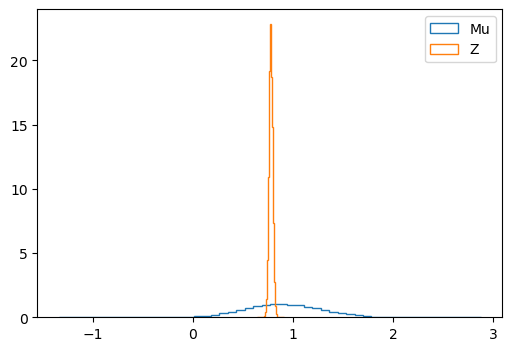

In [16]:
### Single experiment x1000 nominal z
n_data = 500000

n_exp = 1
n_data_nom = n_data

X_sig_data_nom = np.random.normal(0, feature_std, (n_exp, int(n_data_nom*sigScaling), 2))
#X_sig_data_nom = np.random.normal(0, feature_std, (n_exp, int(n_data_nom), 2))
Y_sig_data_nom = np.ones((n_exp, int(n_data_nom*sigScaling)))
#Y_sig_data_nom = np.ones((n_exp, int(n_data_nom)))

Z_incarnation = np.array([z_nominal])
centres_sig_data_nom = np.expand_dims(r* np.vstack([np.cos(Z_incarnation), np.sin(Z_incarnation)]).T, 1)\

X_sig_data_nom += centres_sig_data_nom


X_back_data_nom = np.random.normal(0, feature_std, (n_exp, int(n_data_nom*backScaling), 2))
#X_back_data_nom = np.random.normal(0, feature_std, (n_exp, int(n_data_nom), 2))
Y_back_data_nom = np.zeros((n_exp, int(n_data_nom*backScaling)))
#Y_back_data_nom = np.zeros((n_exp, int(n_data_nom)))

centres_back_data_nom = np.expand_dims(r* np.vstack([-np.cos(Z_incarnation), -np.sin(Z_incarnation)]).T, 1)

X_back_data_nom += centres_back_data_nom

X_data_nom = np.concatenate([X_sig_data_nom,X_back_data_nom], 1)
Y_data_nom = np.hstack([Y_sig_data_nom,Y_back_data_nom])
Z_data_nom = np.zeros_like(Y_data_nom) + np.expand_dims(Z_incarnation, 1)

weights_data_nom = np.ones_like(Y_data_nom)
#weights_data_nom[Y_data_nom==1] *=sigScaling
#weights_data_nom[Y_data_nom==0] *=backScaling


out = []

print(weights_data_nom.shape, weights_data_nom)


x_batch_data_avg = np.average(X_data_nom[0], weights=weights_data_nom[0], axis=0)
x_batch_data_std = np.sqrt(np.average((X_data_nom[0]-x_batch_data_avg)**2, weights=weights_data_nom[0], axis=0))

x_data = torch.tensor(X_data_nom[0]).to(current_settings["device"])            
x_batch_data_avg = torch.tensor(x_batch_data_avg).to(current_settings["device"]).view(1,-1).repeat(x_data.size(0), 1)
x_batch_data_std = torch.tensor(x_batch_data_std).to(current_settings["device"]).view(1,-1).repeat(x_data.size(0), 1)

cond_inputs = torch.cat((x_data, x_batch_data_avg, x_batch_data_std), 1)

print(cond_inputs)

for i in range(0, 100):
    with torch.no_grad():
        outputs_flow = model.sample(num_samples = X_data_nom[0].shape[0], noise=None, cond_inputs=cond_inputs.float()).cpu().numpy()
        out.append(outputs_flow*10.0)
out = np.vstack(out)


fig = plt.figure(figsize=(6,4))
subplot = fig.add_subplot(1,1,1)   

c, bins, _ = subplot.hist(out[:,1], histtype='step', label ='Mu', linewidth = 1, linestyle = '-', alpha = 1.0, density=True, bins=50)
c, bins, _ = subplot.hist(out[:,0], histtype='step', label ='Z', linewidth = 1, linestyle = '-', alpha = 1.0, density=True, bins=50)
subplot.legend()


In [17]:
n_data = 500000
true_mu = 1; # variable never used
sigScaling = 1/(10**3.) # because signal is usually much smaller than background but we produced equal
backScaling = sigScaling*100 


n_shifts_train = 61
syst_shifts_train = np.arange(-20,41)/10
z_syst_train =  z_nominal * syst_shifts_train

#syst_shifts_train = np.ones(n_shifts_train)
#z_syst_train =  z_nominal * syst_shifts_train



X_sig_syst_train = np.array([np.vstack( [np.random.normal(0, feature_std, n_data), np.random.normal(0, feature_std, n_data)]).T 
              for i in range (n_shifts_train)])
Y_sig_syst_train = np.array([np.ones(n_data) for i in range (n_shifts_train)])
centres_sig_syst_train = np.array([r* np.vstack([np.cos(z_syst_train[i]), np.sin(z_syst_train[i])]).T for i in range(n_shifts_train)])
X_sig_syst_train += centres_sig_syst_train

X_back_syst_train = np.array([np.vstack( [np.random.normal(0, feature_std, n_data), np.random.normal(0, feature_std, n_data)]).T
                        for i in range (n_shifts_train)])
Y_back_syst_train = np.array([np.zeros(n_data) for i in range (n_shifts_train)])
centres_back_syst_train = np.array([r* np.vstack([-np.cos(z_syst_train[i]), -np.sin(z_syst_train[i])]).T for i in range(n_shifts_train)])
X_back_syst_train += centres_back_syst_train

X_syst_train = np.concatenate([X_sig_syst_train,X_back_syst_train], 1)
Y_syst_train = np.hstack([Y_sig_syst_train,Y_back_syst_train])
Z_syst_train  = np.ones_like(Y_syst_train) * z_syst_train.reshape(-1,1)


#X_syst_train = X_syst_train.reshape(-1,X_syst_train.shape[-1])
#Y_syst_train = Y_syst_train.reshape(-1)
#Z_syst_train = Z_syst_train.reshape(-1)


weights_syst_train = np.ones_like(Y_syst_train)
weights_syst_train[Y_syst_train==1] *=sigScaling
weights_syst_train[Y_syst_train==0] *=backScaling


print(X_syst_train.shape[0], X_syst_train.shape, Y_syst_train.shape, Z_syst_train.shape)


61 (61, 1000000, 2) (61, 1000000) (61, 1000000)


In [37]:


# This function returns the flow model
def get_flow_model_embed(settings):
    modules = []
    for _ in range(settings['num_blocks']):
        modules += [
            fnn.MADE(settings['num_inputs'], settings['num_hidden'], num_cond_inputs=settings['num_out_embed'], act=settings['activation'],
            pre_exp_tanh=settings['pre_exp_tanh']),
            fnn.Reverse(settings['num_inputs'])
        ]
    model = fnn.FlowSequential(*modules)
    for module in model.modules():
        if isinstance(module, nn.Linear):
            nn.init.orthogonal_(module.weight)
            if hasattr(module, 'bias') and module.bias is not None:
                module.bias.data.fill_(0)
    model.to(settings['device'])
    return model    


weight_decay = 0.0e-6

# define model settings:
current_settings = {
    # number of MADE blocks
    'num_blocks' : 8,
    # number of actual input variables (NOT counting the conditional inputs)
    'num_inputs' : 2,
    # number of nodes in hidden layers
    'num_hidden' : 32,
    # number of nodes in hidden layers
    'num_hidden_embed' : 32,
    # number of nodes in hidden layers
    'num_out_embed' : 32,
    # number of conditional variables
    'num_cond' : 2,
    # activation function to use in the MADE blocks (can be relu, sigmoid or tanh):
    'activation' : 'relu',
    # apply tanh function before calculating the logprobs. This is a recommended setting, as it helps with getting infs/nans in the loss
    'pre_exp_tanh' : True,
    # current pytorch device (CPU or GPU)
    'device' : device,
    
} 


class PointEmbeddingFlow(nn.Module):
    
    def __init__(self, settings):
        super(PointEmbeddingFlow, self).__init__()
        
        self.point_net = nn.Sequential(
            nn.Linear(settings['num_cond'], settings['num_hidden_embed']), nn.ReLU(),
            nn.Linear(settings['num_hidden_embed'], settings['num_hidden_embed']), nn.ReLU(),
            nn.Linear(settings['num_hidden_embed'], settings['num_hidden_embed']//2))
        
        self.point_net = self.point_net.to(current_settings["device"])
        
        self.embedd_net = nn.Sequential(
            nn.Linear((settings['num_hidden_embed']//2*2)+settings['num_cond'], 
                      settings['num_hidden_embed']), nn.ReLU(),
            nn.Linear(settings['num_hidden_embed'], settings['num_hidden_embed']), nn.ReLU(),
            nn.Linear(settings['num_hidden_embed'], settings['num_out_embed']))
       
        self.embedd_net = self.embedd_net.to(current_settings["device"])

        self.flow_model = get_flow_model_embed(settings).to(current_settings["device"])
  

    def log_probs(self, inputs, cond_inputs = None, weights = None):
        
        if weights is None:
            weights = torch.ones(inputs.size(0), 1)


        
        agg = self.point_net(cond_inputs)
        
        
        agg_mean = torch.mul(agg, weights).sum(0)/weights.sum(0)
        agg_std  = torch.sqrt((torch.mul(((agg-agg_mean)**2), weights).sum(0))/weights.sum(0))
    
        agg = torch.cat((agg_mean, agg_std))
        agg = agg.view(1,-1).repeat(inputs.size(0), 1)
        
        
        
        cond_inputs = torch.cat((cond_inputs, agg), 1)                
        cond_inputs = self.embedd_net(cond_inputs)

        log_prob = self.flow_model.log_probs(inputs=inputs, cond_inputs=cond_inputs)

        return log_prob
    
    

    def sample(self, num_samples=None, noise=None, cond_inputs=None, weights = None):
        
        
        if weights is None:
            weights = torch.ones(num_samples, 1)


        
        agg = self.point_net(cond_inputs)
        
        
        agg_mean = torch.mul(agg, weights).sum(0)/weights.sum(0)
        agg_std  = torch.sqrt((torch.mul(((agg-agg_mean)**2), weights).sum(0))/weights.sum(0))
    
        agg = torch.cat((agg_mean, agg_std))
        agg = agg.view(1,-1).repeat(num_samples, 1)
        cond_inputs = torch.cat((cond_inputs, agg), 1)
        
                
        cond_inputs = self.embedd_net(cond_inputs)


        samples = self.flow_model.sample(num_samples=num_samples, noise=noise, cond_inputs=cond_inputs)
        
        return samples






In [38]:

size_batch = 10000
n_batch = X_syst_train.shape[0]//size_batch
epochs = 20

# create model

#def train_flow(log_scale_data=False, use_log_prob=True, double_scale=False, learning_rate = 1.0e-4):
#def train_flow(
log_scale_data=False
use_log_prob=True
double_scale=False
learning_rate = 1.0e-4


model = PointEmbeddingFlow(current_settings)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


for epoch in range(1, epochs + 1):
    print(f"Starting epoch {epoch}...")
    model.train()
    now_loss = 0 
    permut_Z = np.random.permutation(X_syst_train.shape[0])
    print(permut_Z)


    for i_z in permut_Z:

        permut = np.random.permutation(X_syst_train[i_z].shape[0])
        X_syst_train_shuffle = np.array(X_syst_train[i_z,permut])
        Y_syst_train_shuffle = np.array(Y_syst_train[i_z,permut])
        Z_syst_train_shuffle = np.array(Z_syst_train[i_z,permut])
        weights_syst_train_shuffle = np.array(weights_syst_train[i_z,permut])


        n_batch = X_syst_train[i_z].shape[0]//size_batch



        for i_batch in range(0, n_batch):

            #if isinstance(batch_data, list):

            y_data = torch.tensor(Y_syst_train_shuffle[i_batch*size_batch:(1+i_batch)*size_batch]).to(current_settings["device"])
            z_data = torch.tensor(Z_syst_train_shuffle[i_batch*size_batch:(1+i_batch)*size_batch]).to(current_settings["device"])

            #pad_data = (torch.torch.randn(z_data.size())).to(current_settings["device"])
            mu_data = ((torch.torch.rand(1)*5.0)*torch.torch.ones(z_data.size())).to(current_settings["device"])

            weight = torch.tensor(weights_syst_train_shuffle[i_batch*size_batch:(1+i_batch)*size_batch]).to(current_settings["device"])
            weight[y_data==1] = weight[y_data==1]*mu_data[y_data==1]
            weight_np = weight.cpu().numpy()
            weight = weight.view(-1,1)

            #print(y_data)

            x_data = X_syst_train_shuffle[i_batch*size_batch:(1+i_batch)*size_batch]

            x_batch_data_avg = np.average(x_data, weights=weight_np, axis=0)
            x_batch_data_std = np.sqrt(np.average((x_data-x_batch_data_avg)**2, weights=weight_np, axis=0))


            
            x_data = torch.tensor(x_data).to(current_settings["device"])            

            inputs = torch.cat((z_data.view(-1, 1), mu_data.view(-1, 1)), 1).float()/10.0

            cond_inputs = x_data

            optimizer.zero_grad()

            log_prob = model.log_probs(inputs, cond_inputs = cond_inputs.float(), weights=weight.float())

            loss_vals = log_prob*weight

            loss = -loss_vals.mean()

            loss.backward()
            optimizer.step()

        print('Epoch: {:d}, Batch: {:d}, Loss: {:.4f}'.format(epoch, i_z, loss))




#model = train_flow()


Starting epoch 1...
[58 37 25  8 59 19 43 29 46 54  4 48  3 31 34  7 27 38 15 12 17 13 55 26
  5 60 20 50  2 30 10 52 51 35 47 32 21 23 56  1 40 39 57 33 44  0 28 22
 36  6 45  9 42 24 41 14 49 18 11 53 16]
Epoch: 1, Batch: 58, Loss: 0.0132
Epoch: 1, Batch: 37, Loss: -0.1377
Epoch: 1, Batch: 25, Loss: -0.1458
Epoch: 1, Batch: 8, Loss: -0.1769
Epoch: 1, Batch: 59, Loss: -0.1377
Epoch: 1, Batch: 19, Loss: -0.1235
Epoch: 1, Batch: 43, Loss: -0.1258
Epoch: 1, Batch: 29, Loss: -0.1407
Epoch: 1, Batch: 46, Loss: -0.1488
Epoch: 1, Batch: 54, Loss: -0.1526
Epoch: 1, Batch: 4, Loss: -0.0608
Epoch: 1, Batch: 48, Loss: -0.0541
Epoch: 1, Batch: 3, Loss: -0.0571
Epoch: 1, Batch: 31, Loss: -0.1249
Epoch: 1, Batch: 34, Loss: -0.1067
Epoch: 1, Batch: 7, Loss: -0.0822
Epoch: 1, Batch: 27, Loss: -0.1518
Epoch: 1, Batch: 38, Loss: -0.1614
Epoch: 1, Batch: 15, Loss: -0.0890
Epoch: 1, Batch: 12, Loss: -0.1252
Epoch: 1, Batch: 17, Loss: -0.1718
Epoch: 1, Batch: 13, Loss: -0.1884
Epoch: 1, Batch: 55, Loss: -

Epoch: 4, Batch: 2, Loss: -0.2468
Epoch: 4, Batch: 53, Loss: -0.2521
Epoch: 4, Batch: 7, Loss: -0.2360
Epoch: 4, Batch: 38, Loss: -0.2045
Epoch: 4, Batch: 34, Loss: -0.2494
Epoch: 4, Batch: 9, Loss: -0.2350
Epoch: 4, Batch: 23, Loss: -0.2631
Epoch: 4, Batch: 4, Loss: -0.2459
Epoch: 4, Batch: 33, Loss: -0.2668
Epoch: 4, Batch: 51, Loss: -0.2730
Epoch: 4, Batch: 13, Loss: -0.2358
Epoch: 4, Batch: 20, Loss: -0.2378
Epoch: 4, Batch: 37, Loss: -0.2513
Epoch: 4, Batch: 49, Loss: -0.2738
Epoch: 4, Batch: 14, Loss: -0.2681
Epoch: 4, Batch: 10, Loss: -0.2520
Epoch: 4, Batch: 18, Loss: -0.2773
Epoch: 4, Batch: 30, Loss: -0.2611
Epoch: 4, Batch: 26, Loss: -0.2694
Epoch: 4, Batch: 47, Loss: -0.2582
Epoch: 4, Batch: 21, Loss: -0.2805
Epoch: 4, Batch: 39, Loss: -0.2860
Epoch: 4, Batch: 54, Loss: -0.2347
Epoch: 4, Batch: 6, Loss: -0.2636
Epoch: 4, Batch: 58, Loss: -0.2501
Epoch: 4, Batch: 44, Loss: -0.2316
Epoch: 4, Batch: 1, Loss: -0.2509
Epoch: 4, Batch: 3, Loss: -0.2574
Epoch: 4, Batch: 45, Loss: 

Epoch: 8, Batch: 23, Loss: -0.3092
Epoch: 8, Batch: 56, Loss: -0.2848
Epoch: 8, Batch: 37, Loss: -0.3124
Epoch: 8, Batch: 31, Loss: -0.2600
Epoch: 8, Batch: 3, Loss: -0.3179
Epoch: 8, Batch: 42, Loss: -0.2949
Epoch: 8, Batch: 1, Loss: -0.2736
Epoch: 8, Batch: 46, Loss: -0.3113
Epoch: 8, Batch: 6, Loss: -0.3011
Epoch: 8, Batch: 22, Loss: -0.3222
Epoch: 8, Batch: 13, Loss: -0.3308
Epoch: 8, Batch: 7, Loss: -0.3348
Epoch: 8, Batch: 5, Loss: -0.3233
Epoch: 8, Batch: 29, Loss: -0.3020
Epoch: 8, Batch: 34, Loss: -0.3194
Epoch: 8, Batch: 53, Loss: -0.3081
Epoch: 8, Batch: 48, Loss: -0.2828
Epoch: 8, Batch: 39, Loss: -0.3241
Epoch: 8, Batch: 43, Loss: -0.3322
Epoch: 8, Batch: 50, Loss: -0.3160
Epoch: 8, Batch: 20, Loss: -0.3372
Epoch: 8, Batch: 59, Loss: -0.2895
Epoch: 8, Batch: 30, Loss: -0.2780
Epoch: 8, Batch: 28, Loss: -0.3129
Epoch: 8, Batch: 19, Loss: -0.3302
Epoch: 8, Batch: 21, Loss: -0.3252
Epoch: 8, Batch: 40, Loss: -0.2954
Epoch: 8, Batch: 27, Loss: -0.3245
Epoch: 8, Batch: 35, Loss

Epoch: 11, Batch: 18, Loss: -0.3867
Epoch: 11, Batch: 11, Loss: -0.3677
Epoch: 11, Batch: 20, Loss: -0.3391
Epoch: 11, Batch: 39, Loss: -0.3730
Epoch: 11, Batch: 0, Loss: -0.3246
Epoch: 11, Batch: 8, Loss: -0.3338
Epoch: 11, Batch: 54, Loss: -0.2993
Epoch: 11, Batch: 36, Loss: -0.3641
Epoch: 11, Batch: 43, Loss: -0.3343
Epoch: 11, Batch: 57, Loss: -0.3111
Epoch: 11, Batch: 10, Loss: -0.3687
Epoch: 11, Batch: 55, Loss: -0.3371
Epoch: 11, Batch: 9, Loss: -0.3518
Epoch: 11, Batch: 31, Loss: -0.3819
Epoch: 11, Batch: 24, Loss: -0.3688
Epoch: 11, Batch: 19, Loss: -0.3825
Epoch: 11, Batch: 50, Loss: -0.3449
Epoch: 11, Batch: 51, Loss: -0.3496
Epoch: 11, Batch: 2, Loss: -0.3185
Epoch: 11, Batch: 23, Loss: -0.3878
Epoch: 11, Batch: 22, Loss: -0.3139
Epoch: 11, Batch: 25, Loss: -0.2279
Epoch: 11, Batch: 34, Loss: -0.3782
Epoch: 11, Batch: 4, Loss: -0.3218
Epoch: 11, Batch: 38, Loss: -0.2155
Epoch: 11, Batch: 21, Loss: -0.2807
Epoch: 11, Batch: 29, Loss: -0.3958
Epoch: 11, Batch: 14, Loss: -0.37

Epoch: 15, Batch: 6, Loss: -0.3203
Epoch: 15, Batch: 2, Loss: -0.3338
Epoch: 15, Batch: 42, Loss: -0.3740
Epoch: 15, Batch: 34, Loss: -0.3808
Epoch: 15, Batch: 30, Loss: -0.3186
Epoch: 15, Batch: 58, Loss: -0.2826
Epoch: 15, Batch: 29, Loss: -0.3799
Epoch: 15, Batch: 22, Loss: -0.3609
Epoch: 15, Batch: 27, Loss: -0.4051
Epoch: 15, Batch: 41, Loss: -0.3865
Epoch: 15, Batch: 12, Loss: -0.3699
Epoch: 15, Batch: 46, Loss: -0.3946
Epoch: 15, Batch: 9, Loss: -0.3361
Epoch: 15, Batch: 43, Loss: -0.3244
Epoch: 15, Batch: 16, Loss: -0.3682
Epoch: 15, Batch: 39, Loss: -0.3298
Epoch: 15, Batch: 56, Loss: -0.3275
Epoch: 15, Batch: 4, Loss: -0.3570
Epoch: 15, Batch: 40, Loss: -0.3183
Epoch: 15, Batch: 11, Loss: -0.3623
Epoch: 15, Batch: 49, Loss: -0.3493
Epoch: 15, Batch: 33, Loss: -0.3728
Epoch: 15, Batch: 35, Loss: -0.4091
Epoch: 15, Batch: 57, Loss: -0.2959
Epoch: 15, Batch: 20, Loss: -0.3717
Epoch: 15, Batch: 15, Loss: -0.3887
Epoch: 15, Batch: 5, Loss: -0.3581
Epoch: 15, Batch: 45, Loss: -0.40

Epoch: 18, Batch: 18, Loss: -0.3704
Epoch: 18, Batch: 59, Loss: -0.3200
Epoch: 18, Batch: 35, Loss: -0.3954
Epoch: 18, Batch: 41, Loss: -0.3850
Epoch: 18, Batch: 11, Loss: -0.3659
Epoch: 18, Batch: 30, Loss: -0.4018
Epoch: 18, Batch: 5, Loss: -0.3411
Epoch: 18, Batch: 45, Loss: -0.4010
Epoch: 18, Batch: 9, Loss: -0.3867
Epoch: 18, Batch: 49, Loss: -0.3685
Epoch: 18, Batch: 34, Loss: -0.4093
Epoch: 18, Batch: 26, Loss: -0.2871
Epoch: 18, Batch: 20, Loss: -0.4008
Epoch: 18, Batch: 6, Loss: -0.3623
Epoch: 18, Batch: 60, Loss: -0.2459
Epoch: 18, Batch: 17, Loss: -0.3918
Epoch: 18, Batch: 15, Loss: -0.3737
Epoch: 18, Batch: 23, Loss: -0.4055
Epoch: 18, Batch: 54, Loss: -0.3516
Epoch: 18, Batch: 25, Loss: -0.2667
Epoch: 18, Batch: 0, Loss: -0.3407
Epoch: 18, Batch: 24, Loss: -0.3829
Epoch: 18, Batch: 46, Loss: -0.3660
Epoch: 18, Batch: 56, Loss: -0.3243
Epoch: 18, Batch: 27, Loss: -0.3730
Epoch: 18, Batch: 44, Loss: -0.3167
Epoch: 18, Batch: 53, Loss: -0.3670
Epoch: 18, Batch: 55, Loss: -0.3

(1, 50500)
(1, 50500, 2)
torch.Size([10000, 2])


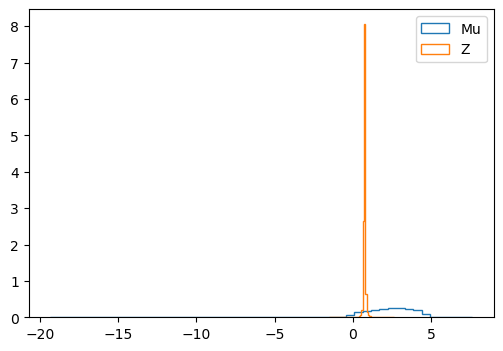

In [36]:
### Single experiment x1000 nominal z
n_data = 500000

n_exp = 1
n_data_nom = n_data

X_sig_data_nom = np.random.normal(0, feature_std, (n_exp, int(n_data_nom*sigScaling), 2))
#X_sig_data_nom = np.random.normal(0, feature_std, (n_exp, int(n_data_nom), 2))
Y_sig_data_nom = np.ones((n_exp, int(n_data_nom*sigScaling)))
#Y_sig_data_nom = np.ones((n_exp, int(n_data_nom)))

Z_incarnation = np.array([z_nominal])
centres_sig_data_nom = np.expand_dims(r* np.vstack([np.cos(Z_incarnation), np.sin(Z_incarnation)]).T, 1)\

X_sig_data_nom += centres_sig_data_nom


X_back_data_nom = np.random.normal(0, feature_std, (n_exp, int(n_data_nom*backScaling), 2))
#X_back_data_nom = np.random.normal(0, feature_std, (n_exp, int(n_data_nom), 2))
Y_back_data_nom = np.zeros((n_exp, int(n_data_nom*backScaling)))
#Y_back_data_nom = np.zeros((n_exp, int(n_data_nom)))

centres_back_data_nom = np.expand_dims(r* np.vstack([-np.cos(Z_incarnation), -np.sin(Z_incarnation)]).T, 1)

X_back_data_nom += centres_back_data_nom

X_data_nom = np.concatenate([X_sig_data_nom,X_back_data_nom], 1)
Y_data_nom = np.hstack([Y_sig_data_nom,Y_back_data_nom])
Z_data_nom = np.zeros_like(Y_data_nom) + np.expand_dims(Z_incarnation, 1)

weights_data_nom = np.ones_like(Y_data_nom)
#weights_data_nom[Y_data_nom==1] *=sigScaling
#weights_data_nom[Y_data_nom==0] *=backScaling


print(weights_data_nom.shape)
print(X_data_nom.shape)

print(cond_inputs.shape)
out = []
for i in range(0, 100):
    with torch.no_grad():
        outputs_flow = model.sample(num_samples = X_data_nom[0].shape[0], noise=None, 
                                    cond_inputs=torch.tensor(X_data_nom[0]).to(current_settings["device"]).float(), 
                                    weights = torch.tensor(weights_data_nom[0]).to(current_settings["device"]).float().view(-1,1)
                                   ).cpu().numpy()
        out.append(outputs_flow*10.0)
out = np.vstack(out)


fig = plt.figure(figsize=(6,4))
subplot = fig.add_subplot(1,1,1)   

c, bins, _ = subplot.hist(out[:,1], histtype='step', label ='Mu', linewidth = 1, linestyle = '-', alpha = 1.0, density=True, bins=50)
c, bins, _ = subplot.hist(out[:,0], histtype='step', label ='Z', linewidth = 1, linestyle = '-', alpha = 1.0, density=True, bins=50)
subplot.legend()


In [7]:

X_double_syst_train = []
Y_double_syst_train = []
Z_double_syst_train = []
weights_double_syst_train = []


n_data = 500000
true_mu = 1; # variable never used

sigScaling = 1/(10**3.) # because signal is usually much smaller than background but we produced equal
backScaling = sigScaling*100 

#sigScaling = 0.1
#backScaling = 0.1

n_shifts_train = 61
syst_shifts_train = np.arange(-20,41)/10
z_syst_train =  z_nominal * syst_shifts_train

mu_shifts_train = 51
mu_syst_train = np.arange(0,51)/10



for mu_syst in mu_syst_train:

    X_sig_syst_train = np.array([np.vstack( [np.random.normal(0, feature_std, int(n_data*mu_syst*sigScaling)), 
                                             np.random.normal(0, feature_std, int(n_data*mu_syst*sigScaling))]).T 
                  for i in range (n_shifts_train)])
    Y_sig_syst_train = np.array([np.ones(int(n_data*mu_syst*sigScaling)) for i in range (n_shifts_train)])
    centres_sig_syst_train = np.array([r* np.vstack([np.cos(z_syst_train[i]), 
                                                     np.sin(z_syst_train[i])]).T for i in range(n_shifts_train)])
    X_sig_syst_train += centres_sig_syst_train

    X_back_syst_train = np.array([np.vstack( [np.random.normal(0, feature_std, int(n_data*backScaling)), 
                                              np.random.normal(0, feature_std, int(n_data*backScaling))]).T
                            for i in range (n_shifts_train)])
    Y_back_syst_train = np.array([np.zeros(int(n_data*backScaling)) for i in range (n_shifts_train)])
    centres_back_syst_train = np.array([r* np.vstack([-np.cos(z_syst_train[i]), 
                                                      -np.sin(z_syst_train[i])]).T for i in range(n_shifts_train)])
    X_back_syst_train += centres_back_syst_train

    X_syst_train = np.concatenate([X_sig_syst_train,X_back_syst_train], 1)
    Y_syst_train = np.hstack([Y_sig_syst_train,Y_back_syst_train])
    Z_syst_train  = np.ones_like(Y_syst_train) * z_syst_train.reshape(-1,1)

    weights_syst_train = np.ones_like(Y_syst_train)


    X_double_syst_train.append(X_syst_train)
    Y_double_syst_train.append(Y_syst_train)
    Z_double_syst_train.append(Z_syst_train)
    weights_double_syst_train.append(weights_syst_train)

    
    print(X_syst_train.shape[0], X_syst_train.shape, Y_syst_train.shape, Z_syst_train.shape)
    
    

#X_double_syst_train = np.array(X_double_syst_train)
#Y_double_syst_train = np.array(Y_double_syst_train)
#Z_double_syst_train = np.array(Z_double_syst_train)
#weights_double_syst_train = np.array(weights_double_syst_train)

#print(X_double_syst_train.shape, Y_double_syst_train.shape, Z_double_syst_train.shape, weights_double_syst_train.shape)


61 (61, 50000, 2) (61, 50000) (61, 50000)
61 (61, 50050, 2) (61, 50050) (61, 50050)
61 (61, 50100, 2) (61, 50100) (61, 50100)
61 (61, 50150, 2) (61, 50150) (61, 50150)
61 (61, 50200, 2) (61, 50200) (61, 50200)
61 (61, 50250, 2) (61, 50250) (61, 50250)
61 (61, 50300, 2) (61, 50300) (61, 50300)
61 (61, 50350, 2) (61, 50350) (61, 50350)
61 (61, 50400, 2) (61, 50400) (61, 50400)
61 (61, 50450, 2) (61, 50450) (61, 50450)
61 (61, 50500, 2) (61, 50500) (61, 50500)
61 (61, 50550, 2) (61, 50550) (61, 50550)
61 (61, 50600, 2) (61, 50600) (61, 50600)
61 (61, 50650, 2) (61, 50650) (61, 50650)
61 (61, 50700, 2) (61, 50700) (61, 50700)
61 (61, 50750, 2) (61, 50750) (61, 50750)
61 (61, 50800, 2) (61, 50800) (61, 50800)
61 (61, 50850, 2) (61, 50850) (61, 50850)
61 (61, 50900, 2) (61, 50900) (61, 50900)
61 (61, 50950, 2) (61, 50950) (61, 50950)
61 (61, 51000, 2) (61, 51000) (61, 51000)
61 (61, 51050, 2) (61, 51050) (61, 51050)
61 (61, 51100, 2) (61, 51100) (61, 51100)
61 (61, 51150, 2) (61, 51150) (61,

In [8]:
size_batch = 20000


# This function returns the flow model
def get_flow_model_embed(settings):
    modules = []
    for _ in range(settings['num_blocks']):
        modules += [
            fnn.MADE(settings['num_inputs'], settings['num_hidden'], num_cond_inputs=settings['num_out_embed'], act=settings['activation'],
            pre_exp_tanh=settings['pre_exp_tanh']),
            fnn.Reverse(settings['num_inputs'])
        ]
    model = fnn.FlowSequential(*modules)
    for module in model.modules():
        if isinstance(module, nn.Linear):
            nn.init.orthogonal_(module.weight)
            if hasattr(module, 'bias') and module.bias is not None:
                module.bias.data.fill_(0)
    model.to(settings['device'])
    return model    


weight_decay = 0.0e-6

# define model settings:
current_settings = {
    # number of MADE blocks
    'num_blocks' : 8,
    # number of actual input variables (NOT counting the conditional inputs)
    'num_inputs' : 8,
    # number of nodes in hidden layers
    'num_hidden' : 64,
    # number of nodes in hidden layers
    'num_hidden_embed' : 128,
    # number of nodes in hidden layers
    'num_out_embed' : 64,
    # number of conditional variables
    'num_cond' : 2*size_batch,
    # activation function to use in the MADE blocks (can be relu, sigmoid or tanh):
    'activation' : 'relu',
    # apply tanh function before calculating the logprobs. This is a recommended setting, as it helps with getting infs/nans in the loss
    'pre_exp_tanh' : True,
    # current pytorch device (CPU or GPU)
    'device' : device,
    
} 


class PointEmbeddingFlow(nn.Module):
    
    def __init__(self, settings):
        super(PointEmbeddingFlow, self).__init__()
        
        self.embedd_net = nn.Sequential(
            nn.Linear(settings['num_cond'], settings['num_hidden_embed']), nn.ReLU(),
            nn.Linear(settings['num_hidden_embed'], settings['num_hidden_embed']), nn.ReLU(),
            nn.Linear(settings['num_hidden_embed'], settings['num_out_embed']))
       
        self.embedd_net = self.embedd_net.to(current_settings["device"])

        self.flow_model = get_flow_model_embed(settings).to(current_settings["device"])
  

    def log_probs(self, inputs, cond_inputs = None, weights = None):
        
        cond_inputs = self.embedd_net(cond_inputs)

        log_prob = self.flow_model.log_probs(inputs=inputs, cond_inputs=cond_inputs)

        return log_prob
    
    

    def sample(self, num_samples=None, noise=None, cond_inputs=None, weights = None):

        cond_inputs = self.embedd_net(cond_inputs)

        samples = self.flow_model.sample(num_samples=num_samples, noise=noise, cond_inputs=cond_inputs)
        
        return samples






In [17]:

n_batch = int(n_data*backScaling*2)//size_batch
n_batch = 1
epochs = 10

# create model

#def train_flow(log_scale_data=False, use_log_prob=True, double_scale=False, learning_rate = 1.0e-4):
#def train_flow(
log_scale_data=False
use_log_prob=True
double_scale=False
learning_rate = 1.0e-4


model = PointEmbeddingFlow(current_settings)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


#X_double_syst_train
#Y_double_syst_train
#Z_double_syst_train
#weights_double_syst_train

for epoch in range(1, epochs + 1):
    print(f"Starting epoch {epoch}...")
    model.train()
    now_loss = 0 
    
    permut_mu = np.random.permutation(len(X_double_syst_train))
    print(permut_mu)
    
    for i_mu in permut_mu:

        
        X_mu_slice_syst_train = X_double_syst_train[i_mu]
        Y_mu_slice_syst_train = Y_double_syst_train[i_mu]
        #Z_mu_slice_syst_train = Z_double_syst_train[i_mu]
        weights_mu_slice_syst_train = weights_double_syst_train[i_mu]
        
        
        
        permut_z = np.random.permutation(X_mu_slice_syst_train.shape[0])

        for i_z in permut_z:

            X_mu_z_slice_syst_train = np.array(X_mu_slice_syst_train[i_z])
            Y_mu_z_slice_syst_train = np.array(Y_mu_slice_syst_train[i_z])
            #Z_mu_z_slice_syst_train = np.array(Z_mu_slice_syst_train[i_z])
            weights_mu_z_slice_syst_train = np.array(weights_mu_slice_syst_train[i_z])


            for i_batch in range(0, n_batch):
                batch_indices = np.random.permutation(X_mu_z_slice_syst_train.shape[0])[:size_batch]

                x_data = torch.tensor(X_mu_z_slice_syst_train[batch_indices]).to(current_settings["device"]).view(1,-1)
                y_data = torch.tensor(Y_mu_z_slice_syst_train[batch_indices]).to(current_settings["device"]).view(1,-1)
                #z_data = torch.tensor(Z_mu_z_slice_syst_train[batch_indices]).to(current_settings["device"])

                #weight = torch.tensor(weights_mu_z_slice_syst_train[batch_indices]).to(current_settings["device"])
                #weight = weight.view(-1,1)

                mu_data = torch.tensor(mu_syst_train[i_mu]).to(current_settings["device"])
                z_data = torch.tensor(z_syst_train[i_z]).to(current_settings["device"])

                pad_data = (torch.torch.randn(z_data.size())).to(current_settings["device"])

                inputs = torch.cat((z_data.view(-1, 1), mu_data.view(-1, 1)), 1).float()/10.0

                cond_inputs = x_data

                optimizer.zero_grad()

                log_prob = model.log_probs(inputs, cond_inputs = cond_inputs.float())

                loss_vals = log_prob

                loss = -loss_vals.mean()

                loss.backward()
                optimizer.step()

        print('Epoch: {:d}, Mu: {:.2f}, Z: {:.2f}, Loss: {:.4f}'.format(epoch, mu_syst_train[i_mu], z_syst_train[i_z],loss))




#model = train_flow()


Starting epoch 1...
[23 33  9 26 19 24  5 37 46 41 32 29  0 18 30 50 40 28  7 31 47  6  3 11
  8 13 42 22 39 16 48 14 49 45 15 10 12 38 20 17 36 25  1 21 44 27 35 43
  2  4 34]
Epoch: 1, Mu: 2.30, Z: 3.06, Loss: 0.5403
Epoch: 1, Mu: 3.30, Z: -1.10, Loss: -0.0915
Epoch: 1, Mu: 0.90, Z: 1.57, Loss: -2.3229
Epoch: 1, Mu: 2.60, Z: -1.02, Loss: 10.9613
Epoch: 1, Mu: 1.90, Z: -1.41, Loss: 0.6017
Epoch: 1, Mu: 2.40, Z: 0.08, Loss: -1.8347
Epoch: 1, Mu: 0.50, Z: 0.24, Loss: -1.6626
Epoch: 1, Mu: 3.70, Z: -0.71, Loss: 2.9040
Epoch: 1, Mu: 4.60, Z: 1.41, Loss: -1.8810
Epoch: 1, Mu: 4.10, Z: 1.26, Loss: 0.2076
Epoch: 1, Mu: 3.20, Z: 3.14, Loss: 0.2429
Epoch: 1, Mu: 2.90, Z: -1.10, Loss: -0.0997
Epoch: 1, Mu: 0.00, Z: -0.86, Loss: 0.4136
Epoch: 1, Mu: 1.80, Z: 1.18, Loss: -1.4928
Epoch: 1, Mu: 3.00, Z: -0.55, Loss: -0.7423
Epoch: 1, Mu: 5.00, Z: 1.41, Loss: 1.2356
Epoch: 1, Mu: 4.00, Z: 0.79, Loss: -1.8567
Epoch: 1, Mu: 2.80, Z: 2.91, Loss: 4.1499
Epoch: 1, Mu: 0.70, Z: -0.71, Loss: -1.7689
Epoch:

Epoch: 4, Mu: 3.70, Z: -0.86, Loss: -4.3274
Epoch: 4, Mu: 0.70, Z: 1.26, Loss: -4.3828
Epoch: 4, Mu: 0.90, Z: 0.79, Loss: -3.4853
Epoch: 4, Mu: 2.40, Z: 0.86, Loss: -4.6559
Epoch: 4, Mu: 0.80, Z: 1.34, Loss: -4.8236
Epoch: 4, Mu: 0.60, Z: 3.06, Loss: -1.7584
Epoch: 4, Mu: 3.40, Z: 0.16, Loss: -4.7692
Epoch: 4, Mu: 3.30, Z: -1.26, Loss: -4.0134
Epoch: 4, Mu: 0.30, Z: 0.47, Loss: -1.4439
Epoch: 4, Mu: 4.30, Z: -0.47, Loss: -2.5636
Epoch: 4, Mu: 1.20, Z: -1.34, Loss: -3.7908
Epoch: 4, Mu: 2.30, Z: 1.81, Loss: -1.9168
Epoch: 4, Mu: 0.00, Z: 0.63, Loss: -3.6004
Epoch: 4, Mu: 0.40, Z: 2.67, Loss: -2.8096
Epoch: 4, Mu: 1.30, Z: 3.06, Loss: -4.2517
Epoch: 4, Mu: 3.80, Z: 1.65, Loss: -4.2074
Epoch: 4, Mu: 2.50, Z: 1.26, Loss: -3.8053
Epoch: 4, Mu: 4.00, Z: -0.24, Loss: -4.0799
Epoch: 4, Mu: 1.10, Z: -0.79, Loss: -4.2742
Epoch: 4, Mu: 0.50, Z: 0.24, Loss: -4.7504
Epoch: 4, Mu: 4.80, Z: -0.39, Loss: -3.7739
Epoch: 4, Mu: 4.20, Z: 2.75, Loss: -4.0368
Epoch: 4, Mu: 1.70, Z: -0.55, Loss: -2.6203
Epo

Epoch: 7, Mu: 1.20, Z: 1.18, Loss: -5.0219
Epoch: 7, Mu: 0.00, Z: 0.31, Loss: -1.9181
Epoch: 7, Mu: 1.00, Z: 3.14, Loss: -3.4795
Epoch: 7, Mu: 4.90, Z: -0.63, Loss: -2.9276
Epoch: 7, Mu: 1.90, Z: 2.20, Loss: -4.0039
Epoch: 7, Mu: 3.60, Z: -0.24, Loss: -4.6521
Starting epoch 8...
[44 37 41 20 35 26 10  7 46 31 34 13  0 33 23 18 45 43 39 12  5  2 24  8
 32 27 15 36 50 49 16 22  3 48  4  9 28 38 14 40 30 29 19  6 17 11 21  1
 25 47 42]
Epoch: 8, Mu: 4.40, Z: -0.47, Loss: -3.3392
Epoch: 8, Mu: 3.70, Z: -0.31, Loss: -5.4195
Epoch: 8, Mu: 4.10, Z: -1.34, Loss: -4.6626
Epoch: 8, Mu: 2.00, Z: -0.39, Loss: -4.4617
Epoch: 8, Mu: 3.50, Z: 0.71, Loss: -5.1514
Epoch: 8, Mu: 2.60, Z: -1.34, Loss: -4.6865
Epoch: 8, Mu: 1.00, Z: -0.24, Loss: -5.4374
Epoch: 8, Mu: 0.70, Z: 0.31, Loss: -5.3930
Epoch: 8, Mu: 4.60, Z: 2.67, Loss: -4.2649
Epoch: 8, Mu: 3.10, Z: -0.55, Loss: -3.9980
Epoch: 8, Mu: 3.40, Z: 2.67, Loss: 1.6879
Epoch: 8, Mu: 1.30, Z: 0.63, Loss: -4.8568
Epoch: 8, Mu: 0.00, Z: -0.16, Loss: -4.88

Epoch: 11, Mu: 1.10, Z: 0.86, Loss: -5.8370
Epoch: 11, Mu: 0.90, Z: -0.47, Loss: -5.6885
Epoch: 11, Mu: 3.30, Z: -0.86, Loss: -3.7638
Epoch: 11, Mu: 2.70, Z: 1.88, Loss: -5.3859
Epoch: 11, Mu: 0.30, Z: 2.75, Loss: -4.5818
Epoch: 11, Mu: 0.20, Z: -1.57, Loss: -4.9366
Epoch: 11, Mu: 4.60, Z: 0.71, Loss: -3.9871
Epoch: 11, Mu: 4.20, Z: 1.02, Loss: -4.2922
Epoch: 11, Mu: 4.10, Z: 2.36, Loss: -4.7414
Epoch: 11, Mu: 4.50, Z: -1.10, Loss: -4.0551
Epoch: 11, Mu: 1.00, Z: -0.86, Loss: -3.5496
Epoch: 11, Mu: 3.60, Z: 0.94, Loss: -4.5235
Epoch: 11, Mu: 1.30, Z: -1.10, Loss: -4.1554
Epoch: 11, Mu: 3.90, Z: 0.08, Loss: -4.3449
Epoch: 11, Mu: 0.60, Z: 1.65, Loss: -1.9758
Epoch: 11, Mu: 2.40, Z: 2.67, Loss: -4.2621
Epoch: 11, Mu: 2.00, Z: 1.26, Loss: -5.0291
Epoch: 11, Mu: 4.40, Z: 2.59, Loss: -4.2013
Epoch: 11, Mu: 0.70, Z: 2.12, Loss: -3.4997
Epoch: 11, Mu: 2.20, Z: -1.57, Loss: -4.8949
Epoch: 11, Mu: 3.70, Z: 2.20, Loss: -3.2575
Epoch: 11, Mu: 4.70, Z: 0.86, Loss: -4.5195
Epoch: 11, Mu: 0.10, Z: 0

Epoch: 14, Mu: 3.40, Z: 0.47, Loss: -4.7069
Epoch: 14, Mu: 2.10, Z: -0.08, Loss: -5.1232
Epoch: 14, Mu: 4.70, Z: 2.36, Loss: -4.3653
Epoch: 14, Mu: 4.90, Z: -0.31, Loss: -4.4079
Epoch: 14, Mu: 1.70, Z: 2.28, Loss: -4.3886
Epoch: 14, Mu: 0.10, Z: 3.14, Loss: -4.6718
Epoch: 14, Mu: 5.00, Z: 1.18, Loss: -4.0483
Epoch: 14, Mu: 3.60, Z: -0.31, Loss: -4.3600
Epoch: 14, Mu: 0.70, Z: 0.94, Loss: -4.2317
Epoch: 14, Mu: 2.20, Z: 2.75, Loss: -4.8570
Epoch: 14, Mu: 3.70, Z: -0.71, Loss: -4.4049
Epoch: 14, Mu: 1.60, Z: 2.98, Loss: -4.9378
Epoch: 14, Mu: 4.60, Z: -0.08, Loss: -4.2264
Epoch: 14, Mu: 3.30, Z: -0.39, Loss: -4.5198
Epoch: 14, Mu: 2.40, Z: 3.14, Loss: -4.0753
Epoch: 14, Mu: 4.50, Z: 1.96, Loss: -4.8666
Epoch: 14, Mu: 3.10, Z: 3.06, Loss: -4.3231
Epoch: 14, Mu: 4.10, Z: -1.18, Loss: -3.0039
Starting epoch 15...
[38 30 28 33 24 15  6 49  3  7 47 10 22  2 14 11 25 26 29 34 16 13 36  4
 39 50 45 32 17  5 27 21  9 42  1 37 19  8 44 18 35 20 46 48 40 41 43 31
  0 12 23]
Epoch: 15, Mu: 3.80, Z:

Epoch: 18, Mu: 2.60, Z: -1.18, Loss: -5.3124
Epoch: 18, Mu: 4.10, Z: 2.04, Loss: -4.2366
Epoch: 18, Mu: 4.40, Z: -1.41, Loss: -5.3663
Epoch: 18, Mu: 0.50, Z: 0.86, Loss: -3.4853
Epoch: 18, Mu: 5.00, Z: 0.08, Loss: -4.2407
Epoch: 18, Mu: 2.10, Z: 1.81, Loss: -4.0081
Epoch: 18, Mu: 0.30, Z: 0.63, Loss: -4.4732
Epoch: 18, Mu: 0.80, Z: 0.63, Loss: -4.2601
Epoch: 18, Mu: 0.40, Z: -0.47, Loss: -5.5629
Epoch: 18, Mu: 4.90, Z: -0.39, Loss: -3.8611
Epoch: 18, Mu: 3.10, Z: -1.34, Loss: -4.8319
Epoch: 18, Mu: 3.60, Z: 1.88, Loss: -4.4566
Epoch: 18, Mu: 1.00, Z: -0.31, Loss: -4.5994
Epoch: 18, Mu: 1.90, Z: 0.79, Loss: -5.4425
Epoch: 18, Mu: 4.70, Z: 3.14, Loss: -4.6502
Epoch: 18, Mu: 4.30, Z: 3.14, Loss: -3.8878
Epoch: 18, Mu: 3.40, Z: -1.02, Loss: -4.7774
Epoch: 18, Mu: 2.40, Z: 2.36, Loss: -5.2382
Epoch: 18, Mu: 1.70, Z: 0.47, Loss: -4.6813
Epoch: 18, Mu: 4.80, Z: -0.55, Loss: -4.3155
Epoch: 18, Mu: 4.20, Z: 2.28, Loss: -5.1102
Epoch: 18, Mu: 1.30, Z: -0.08, Loss: -5.2651
Epoch: 18, Mu: 2.20, Z:

Epoch: 21, Mu: 3.80, Z: 0.47, Loss: -4.7114
Epoch: 21, Mu: 2.20, Z: 2.59, Loss: -5.0715
Epoch: 21, Mu: 3.10, Z: 0.00, Loss: -4.9000
Epoch: 21, Mu: 1.10, Z: 0.16, Loss: -5.0176
Epoch: 21, Mu: 0.60, Z: 0.71, Loss: -4.9342
Epoch: 21, Mu: 0.70, Z: 2.59, Loss: -5.2216
Epoch: 21, Mu: 4.20, Z: 2.83, Loss: -4.0851
Epoch: 21, Mu: 3.40, Z: 0.00, Loss: -4.9009
Epoch: 21, Mu: 2.90, Z: -0.94, Loss: -5.2681
Epoch: 21, Mu: 4.10, Z: 2.04, Loss: -5.0662
Epoch: 21, Mu: 3.30, Z: -1.02, Loss: -5.1910
Epoch: 21, Mu: 4.60, Z: 0.47, Loss: -4.7864
Epoch: 21, Mu: 0.30, Z: 0.16, Loss: -3.7535
Epoch: 21, Mu: 4.50, Z: 2.91, Loss: -4.3778
Epoch: 21, Mu: 2.70, Z: 0.55, Loss: -5.0808
Epoch: 21, Mu: 0.80, Z: 0.31, Loss: -4.7561
Epoch: 21, Mu: 0.40, Z: 1.26, Loss: -4.6925
Epoch: 21, Mu: 2.50, Z: -0.16, Loss: -5.0156
Epoch: 21, Mu: 2.30, Z: 0.79, Loss: -4.4129
Epoch: 21, Mu: 4.90, Z: -0.47, Loss: -4.3056
Epoch: 21, Mu: 1.20, Z: 1.18, Loss: -4.6034
Epoch: 21, Mu: 3.60, Z: -0.63, Loss: -4.8727
Epoch: 21, Mu: 1.90, Z: 2.1

Epoch: 24, Mu: 4.20, Z: 2.12, Loss: -4.6527
Epoch: 24, Mu: 2.20, Z: 1.10, Loss: -4.9617
Epoch: 24, Mu: 4.90, Z: 2.43, Loss: -4.8508
Epoch: 24, Mu: 2.30, Z: -1.34, Loss: -4.6179
Epoch: 24, Mu: 3.20, Z: -0.47, Loss: -5.2905
Epoch: 24, Mu: 4.10, Z: 1.57, Loss: -5.1877
Epoch: 24, Mu: 2.40, Z: -1.26, Loss: -5.5185
Epoch: 24, Mu: 2.00, Z: 2.51, Loss: -5.3248
Epoch: 24, Mu: 3.40, Z: 1.81, Loss: -5.5252
Epoch: 24, Mu: 4.30, Z: -0.79, Loss: -4.0651
Starting epoch 25...
[48  3 24 26 31 47  1 21 30 25 36 22 42 28 23 45  7 34 49 19  2 37  5 35
  8  6  4 44 10 50 46 33 39  0 14 17 29  9 32 12 15 27 18 40 13 20 43 41
 38 16 11]
Epoch: 25, Mu: 4.80, Z: -1.34, Loss: 13.0471
Epoch: 25, Mu: 0.30, Z: 2.36, Loss: -3.4594
Epoch: 25, Mu: 2.40, Z: 2.59, Loss: -5.0036
Epoch: 25, Mu: 2.60, Z: 3.06, Loss: -4.7591
Epoch: 25, Mu: 3.10, Z: 1.49, Loss: -5.1933
Epoch: 25, Mu: 4.70, Z: 1.81, Loss: -4.6680
Epoch: 25, Mu: 0.10, Z: -0.55, Loss: -3.7099
Epoch: 25, Mu: 2.10, Z: 0.39, Loss: -5.2222
Epoch: 25, Mu: 3.00, Z: 

Epoch: 28, Mu: 1.40, Z: 0.24, Loss: -5.3299
Epoch: 28, Mu: 3.00, Z: 2.36, Loss: -5.3040
Epoch: 28, Mu: 1.90, Z: 1.57, Loss: -5.9172
Epoch: 28, Mu: 2.20, Z: -1.18, Loss: -5.4884
Epoch: 28, Mu: 1.00, Z: -0.24, Loss: -6.3743
Epoch: 28, Mu: 3.20, Z: -1.26, Loss: -1.4315
Epoch: 28, Mu: 4.20, Z: 1.26, Loss: -4.7578
Epoch: 28, Mu: 4.00, Z: 1.96, Loss: -5.2335
Epoch: 28, Mu: 2.70, Z: 1.02, Loss: -5.5046
Epoch: 28, Mu: 3.70, Z: -0.39, Loss: -5.6366
Epoch: 28, Mu: 3.50, Z: 2.28, Loss: -5.6425
Epoch: 28, Mu: 0.20, Z: 1.18, Loss: -4.1988
Epoch: 28, Mu: 2.60, Z: 2.98, Loss: -4.3996
Epoch: 28, Mu: 4.80, Z: 0.16, Loss: -4.5014
Epoch: 28, Mu: 0.80, Z: 0.55, Loss: -4.0477
Epoch: 28, Mu: 3.80, Z: 1.88, Loss: -4.8331
Epoch: 28, Mu: 0.50, Z: 0.24, Loss: -4.2485
Epoch: 28, Mu: 0.00, Z: 0.63, Loss: -3.9357
Epoch: 28, Mu: 5.00, Z: -0.24, Loss: -4.1617
Epoch: 28, Mu: 4.90, Z: 2.98, Loss: -4.4013
Epoch: 28, Mu: 0.60, Z: 2.12, Loss: -4.0765
Epoch: 28, Mu: 0.30, Z: 0.94, Loss: -4.5285
Epoch: 28, Mu: 4.50, Z: -1.

Epoch: 31, Mu: 4.80, Z: 3.14, Loss: -4.8587
Epoch: 31, Mu: 0.60, Z: 0.55, Loss: -4.4948
Epoch: 31, Mu: 2.00, Z: -1.57, Loss: -5.3647
Epoch: 31, Mu: 3.60, Z: -0.79, Loss: -5.0792
Epoch: 31, Mu: 1.30, Z: -0.55, Loss: -5.7060
Epoch: 31, Mu: 1.80, Z: -1.49, Loss: -4.0363
Epoch: 31, Mu: 3.80, Z: -0.31, Loss: -5.0900
Epoch: 31, Mu: 0.50, Z: 0.24, Loss: -3.7844
Epoch: 31, Mu: 3.10, Z: -0.63, Loss: -5.0714
Epoch: 31, Mu: 0.90, Z: 0.71, Loss: -4.6360
Epoch: 31, Mu: 3.40, Z: 0.08, Loss: -5.0883
Epoch: 31, Mu: 3.00, Z: -0.63, Loss: -5.2800
Epoch: 31, Mu: 4.60, Z: 1.41, Loss: -4.5274
Epoch: 31, Mu: 3.30, Z: 2.20, Loss: -5.4255
Epoch: 31, Mu: 0.00, Z: 2.36, Loss: -4.2701
Epoch: 31, Mu: 2.80, Z: 2.59, Loss: -5.1594
Epoch: 31, Mu: 4.20, Z: 2.98, Loss: -4.7017
Epoch: 31, Mu: 2.60, Z: 1.49, Loss: -5.3408
Epoch: 31, Mu: 2.30, Z: 0.86, Loss: -5.6587
Epoch: 31, Mu: 4.00, Z: -0.24, Loss: -5.0816
Epoch: 31, Mu: 4.90, Z: 1.34, Loss: -4.5645
Epoch: 31, Mu: 2.90, Z: 1.88, Loss: -5.4693
Epoch: 31, Mu: 5.00, Z: 

Epoch: 34, Mu: 3.90, Z: -1.18, Loss: -5.5597
Epoch: 34, Mu: 3.60, Z: 1.26, Loss: -5.5720
Epoch: 34, Mu: 1.70, Z: 1.34, Loss: -5.2785
Epoch: 34, Mu: 1.50, Z: 1.10, Loss: -5.8866
Epoch: 34, Mu: 3.50, Z: 2.91, Loss: -5.3124
Starting epoch 35...
[43 16  0 48  4 44 13 19 10  8 33 32  1 39 40 30 21 36 47 45 20 11 42  5
 14 41 50 27  7 31 17 12  6  3 29 15 25 38 18 34 46 49 22  9 23 26 28  2
 37 24 35]
Epoch: 35, Mu: 4.30, Z: 0.47, Loss: -3.1259
Epoch: 35, Mu: 1.60, Z: 1.73, Loss: -5.3185
Epoch: 35, Mu: 0.00, Z: 2.36, Loss: -4.4224
Epoch: 35, Mu: 4.80, Z: 0.94, Loss: -4.3286
Epoch: 35, Mu: 0.40, Z: 1.41, Loss: -4.8131
Epoch: 35, Mu: 4.40, Z: 2.91, Loss: -4.7547
Epoch: 35, Mu: 1.30, Z: 0.55, Loss: -5.6350
Epoch: 35, Mu: 1.90, Z: 2.28, Loss: -5.2679
Epoch: 35, Mu: 1.00, Z: -0.47, Loss: -5.4041
Epoch: 35, Mu: 0.80, Z: -1.26, Loss: -5.9658
Epoch: 35, Mu: 3.30, Z: -1.34, Loss: -5.2416
Epoch: 35, Mu: 3.20, Z: 0.39, Loss: -5.3484
Epoch: 35, Mu: 0.10, Z: 2.67, Loss: -4.2749
Epoch: 35, Mu: 3.90, Z: 2.

Epoch: 38, Mu: 2.10, Z: -0.94, Loss: -5.4669
Epoch: 38, Mu: 3.90, Z: -0.86, Loss: -5.3035
Epoch: 38, Mu: 0.00, Z: -1.41, Loss: -4.4157
Epoch: 38, Mu: 0.90, Z: -1.49, Loss: -5.0238
Epoch: 38, Mu: 0.70, Z: -0.08, Loss: -5.5924
Epoch: 38, Mu: 4.10, Z: 1.10, Loss: -4.3210
Epoch: 38, Mu: 4.60, Z: 2.12, Loss: -4.8942
Epoch: 38, Mu: 3.70, Z: 1.96, Loss: -5.2948
Epoch: 38, Mu: 3.20, Z: 1.96, Loss: -5.0869
Epoch: 38, Mu: 1.40, Z: 1.49, Loss: -4.8617
Epoch: 38, Mu: 1.10, Z: -0.31, Loss: -5.5977
Epoch: 38, Mu: 0.20, Z: -0.08, Loss: -6.0255
Epoch: 38, Mu: 4.40, Z: -0.31, Loss: -4.0515
Epoch: 38, Mu: 4.30, Z: -1.26, Loss: -4.9944
Epoch: 38, Mu: 1.30, Z: 1.49, Loss: -5.4090
Epoch: 38, Mu: 1.50, Z: 0.63, Loss: -6.1464
Epoch: 38, Mu: 5.00, Z: 2.43, Loss: -3.4587
Epoch: 38, Mu: 1.60, Z: 2.28, Loss: -4.3432
Epoch: 38, Mu: 2.70, Z: -1.41, Loss: -4.4959
Epoch: 38, Mu: 4.90, Z: 2.36, Loss: -0.7300
Epoch: 38, Mu: 0.10, Z: 2.28, Loss: -4.2028
Epoch: 38, Mu: 4.50, Z: 1.49, Loss: -4.4099
Epoch: 38, Mu: 3.00, Z

Epoch: 41, Mu: 0.40, Z: 0.86, Loss: -4.8870
Epoch: 41, Mu: 2.50, Z: 2.67, Loss: -5.1343
Epoch: 41, Mu: 2.10, Z: 2.04, Loss: -5.4401
Epoch: 41, Mu: 1.40, Z: 2.04, Loss: -5.6341
Epoch: 41, Mu: 3.70, Z: 1.81, Loss: -4.7383
Epoch: 41, Mu: 0.80, Z: -0.63, Loss: -5.1978
Epoch: 41, Mu: 5.00, Z: -0.16, Loss: -3.0786
Epoch: 41, Mu: 2.80, Z: 2.20, Loss: -4.8129
Epoch: 41, Mu: 4.20, Z: 0.86, Loss: -5.4268
Epoch: 41, Mu: 4.40, Z: 3.14, Loss: -4.6370
Epoch: 41, Mu: 2.90, Z: 0.86, Loss: -5.7958
Epoch: 41, Mu: 2.30, Z: -1.49, Loss: -5.2140
Epoch: 41, Mu: 2.00, Z: 1.81, Loss: -5.6116
Epoch: 41, Mu: 0.60, Z: -1.02, Loss: -5.7920
Epoch: 41, Mu: 1.50, Z: 2.91, Loss: -4.4544
Epoch: 41, Mu: 0.70, Z: -0.94, Loss: -5.2855
Epoch: 41, Mu: 4.90, Z: 3.06, Loss: -2.9226
Epoch: 41, Mu: 3.90, Z: 2.98, Loss: -5.3310
Epoch: 41, Mu: 1.10, Z: -0.63, Loss: -5.6911
Epoch: 41, Mu: 4.80, Z: 2.36, Loss: -4.9586
Starting epoch 42...
[35  0 26 13 49 31 20 44 11 24 15 27 28  4  5 50 39 41 43 21 40 45 47 19
 23  7 10 37 12 22 2

Epoch: 45, Mu: 2.90, Z: 2.36, Loss: -5.6327
Epoch: 45, Mu: 4.80, Z: 1.41, Loss: -4.8945
Epoch: 45, Mu: 2.00, Z: -1.34, Loss: -5.1742
Epoch: 45, Mu: 1.70, Z: 3.06, Loss: -5.9228
Epoch: 45, Mu: 3.20, Z: 1.81, Loss: -5.7888
Epoch: 45, Mu: 0.80, Z: -0.31, Loss: -5.7024
Epoch: 45, Mu: 0.10, Z: -0.86, Loss: -5.7428
Epoch: 45, Mu: 4.10, Z: 3.06, Loss: -4.5041
Epoch: 45, Mu: 3.10, Z: 0.86, Loss: -5.2775
Epoch: 45, Mu: 3.00, Z: 2.28, Loss: -5.3381
Epoch: 45, Mu: 4.40, Z: 2.12, Loss: -5.1375
Epoch: 45, Mu: 1.80, Z: 1.26, Loss: -5.6160
Epoch: 45, Mu: 4.70, Z: -0.24, Loss: -5.2134
Epoch: 45, Mu: 2.50, Z: 0.08, Loss: -4.6556
Epoch: 45, Mu: 2.20, Z: 2.28, Loss: -5.5591
Epoch: 45, Mu: 1.00, Z: 0.00, Loss: -5.2053
Epoch: 45, Mu: 5.00, Z: -0.71, Loss: -4.8123
Epoch: 45, Mu: 3.50, Z: 1.26, Loss: -5.0069
Epoch: 45, Mu: 0.40, Z: 1.10, Loss: -4.9638
Epoch: 45, Mu: 2.60, Z: 2.75, Loss: -5.5367
Epoch: 45, Mu: 0.50, Z: -0.31, Loss: -5.9097
Epoch: 45, Mu: 4.90, Z: -0.94, Loss: -4.4497
Epoch: 45, Mu: 3.40, Z: -

Epoch: 48, Mu: 3.70, Z: 2.59, Loss: -5.0242
Epoch: 48, Mu: 3.40, Z: -1.26, Loss: -4.9429
Epoch: 48, Mu: 0.90, Z: 1.02, Loss: -5.6227
Epoch: 48, Mu: 2.20, Z: 1.02, Loss: -5.7079
Epoch: 48, Mu: 0.10, Z: 0.79, Loss: -5.9259
Epoch: 48, Mu: 3.00, Z: -1.02, Loss: -5.4052
Epoch: 48, Mu: 1.50, Z: 0.71, Loss: -6.1720
Epoch: 48, Mu: 1.60, Z: 2.83, Loss: -5.3045
Epoch: 48, Mu: 2.10, Z: 2.98, Loss: -5.8473
Epoch: 48, Mu: 1.90, Z: 1.26, Loss: -6.0938
Epoch: 48, Mu: 4.80, Z: -1.18, Loss: 1.5437
Epoch: 48, Mu: 2.60, Z: 2.91, Loss: -5.4360
Epoch: 48, Mu: 2.90, Z: -0.08, Loss: -5.2048
Epoch: 48, Mu: 0.30, Z: -1.34, Loss: -5.0525
Epoch: 48, Mu: 0.80, Z: -1.26, Loss: -5.7307
Epoch: 48, Mu: 1.70, Z: 1.88, Loss: -5.8652
Epoch: 48, Mu: 5.00, Z: 0.39, Loss: -4.6495
Epoch: 48, Mu: 0.60, Z: 2.98, Loss: -4.0452
Epoch: 48, Mu: 1.10, Z: 0.79, Loss: -5.7901
Epoch: 48, Mu: 3.80, Z: 1.49, Loss: -5.1095
Epoch: 48, Mu: 4.10, Z: 1.96, Loss: -5.4770
Epoch: 48, Mu: 3.60, Z: -0.79, Loss: -3.9936
Epoch: 48, Mu: 1.80, Z: 2.

Epoch: 51, Mu: 0.50, Z: 0.47, Loss: -5.3468
Epoch: 51, Mu: 1.40, Z: 1.96, Loss: -5.9584
Epoch: 51, Mu: 0.80, Z: -0.24, Loss: -6.4652
Epoch: 51, Mu: 3.60, Z: 2.12, Loss: -4.9385
Epoch: 51, Mu: 1.10, Z: 0.71, Loss: -6.2327
Epoch: 51, Mu: 4.30, Z: 1.81, Loss: -5.0896
Epoch: 51, Mu: 1.60, Z: 0.39, Loss: -5.2421
Epoch: 51, Mu: 3.70, Z: -0.24, Loss: -5.7469
Epoch: 51, Mu: 1.80, Z: 1.57, Loss: -6.3451
Epoch: 51, Mu: 1.00, Z: 2.98, Loss: -5.4250
Epoch: 51, Mu: 4.20, Z: 1.88, Loss: -5.0349
Starting epoch 52...
[14 32 29  9 20 48 43 17 16 28 46 41  5 44 22 21 19 38 45  3 15 35  4 34
  2 40 49 13 24  8 50 27 26  1  0 37 39 30  7 10  6 47 33 23 42 31 25 18
 11 12 36]
Epoch: 52, Mu: 1.40, Z: 0.08, Loss: -6.2779
Epoch: 52, Mu: 3.20, Z: -0.55, Loss: -5.8447
Epoch: 52, Mu: 2.90, Z: 2.36, Loss: -2.7284
Epoch: 52, Mu: 0.90, Z: 1.81, Loss: -5.6762
Epoch: 52, Mu: 2.00, Z: 0.55, Loss: -6.4886
Epoch: 52, Mu: 4.80, Z: 2.20, Loss: -4.8359
Epoch: 52, Mu: 4.30, Z: -1.41, Loss: -5.1091
Epoch: 52, Mu: 1.70, Z: 1.

Epoch: 55, Mu: 2.30, Z: 0.31, Loss: -2.0940
Epoch: 55, Mu: 1.60, Z: 2.75, Loss: -6.9685
Epoch: 55, Mu: 1.30, Z: 0.08, Loss: -6.7734
Epoch: 55, Mu: 4.00, Z: 2.12, Loss: -4.4613
Epoch: 55, Mu: 0.30, Z: -1.02, Loss: -5.4324
Epoch: 55, Mu: 3.90, Z: 0.63, Loss: -5.3639
Epoch: 55, Mu: 2.60, Z: 2.98, Loss: -4.8393
Epoch: 55, Mu: 2.70, Z: 2.36, Loss: -5.7187
Epoch: 55, Mu: 1.20, Z: 3.06, Loss: -5.0481
Epoch: 55, Mu: 4.70, Z: 1.18, Loss: -5.1448
Epoch: 55, Mu: 2.50, Z: -0.39, Loss: -5.8742
Epoch: 55, Mu: 1.10, Z: 2.83, Loss: -3.3431
Epoch: 55, Mu: 4.40, Z: 0.39, Loss: -5.3579
Epoch: 55, Mu: 3.70, Z: 0.47, Loss: -5.9638
Epoch: 55, Mu: 4.30, Z: -0.31, Loss: -5.2442
Epoch: 55, Mu: 1.90, Z: 1.96, Loss: -4.6603
Epoch: 55, Mu: 0.90, Z: -1.49, Loss: -4.1312
Epoch: 55, Mu: 2.80, Z: 1.65, Loss: -5.8668
Epoch: 55, Mu: 4.20, Z: -1.10, Loss: -5.1310
Epoch: 55, Mu: 0.20, Z: 0.71, Loss: -5.4137
Epoch: 55, Mu: 3.30, Z: 1.88, Loss: -5.5541
Epoch: 55, Mu: 1.70, Z: 0.47, Loss: -5.8285
Epoch: 55, Mu: 0.40, Z: 2.3

Epoch: 58, Mu: 0.30, Z: -0.24, Loss: -5.3326
Epoch: 58, Mu: 2.80, Z: 3.06, Loss: -5.2197
Epoch: 58, Mu: 1.70, Z: -0.24, Loss: -3.4617
Epoch: 58, Mu: 4.00, Z: 1.57, Loss: -5.3685
Epoch: 58, Mu: 4.10, Z: -0.16, Loss: -5.7429
Epoch: 58, Mu: 2.10, Z: 1.02, Loss: -5.9547
Epoch: 58, Mu: 0.10, Z: -1.02, Loss: -4.7701
Epoch: 58, Mu: 0.90, Z: -1.34, Loss: -3.7978
Epoch: 58, Mu: 3.90, Z: 1.49, Loss: -5.3480
Epoch: 58, Mu: 4.80, Z: 0.31, Loss: -3.9263
Epoch: 58, Mu: 1.10, Z: 0.39, Loss: -5.5777
Epoch: 58, Mu: 2.50, Z: 1.81, Loss: -5.7477
Epoch: 58, Mu: 2.60, Z: 0.94, Loss: -6.0977
Epoch: 58, Mu: 1.90, Z: -0.16, Loss: -5.8149
Epoch: 58, Mu: 1.40, Z: 0.24, Loss: -5.9144
Epoch: 58, Mu: 5.00, Z: 1.65, Loss: -4.8623
Epoch: 58, Mu: 1.20, Z: 0.86, Loss: -6.1732
Epoch: 58, Mu: 4.70, Z: -0.55, Loss: -5.3666
Epoch: 58, Mu: 3.30, Z: -0.16, Loss: -5.4118
Epoch: 58, Mu: 3.60, Z: 0.79, Loss: -5.8273
Epoch: 58, Mu: 4.90, Z: 1.02, Loss: -5.8367
Epoch: 58, Mu: 1.60, Z: -0.31, Loss: -5.5833
Epoch: 58, Mu: 4.60, Z:

Epoch: 61, Mu: 2.90, Z: 1.41, Loss: -5.9195
Epoch: 61, Mu: 0.40, Z: 1.41, Loss: -5.7361
Epoch: 61, Mu: 2.30, Z: 1.81, Loss: -5.5392
Epoch: 61, Mu: 4.40, Z: 1.41, Loss: -5.3899
Epoch: 61, Mu: 4.50, Z: -1.34, Loss: -5.6975
Starting epoch 62...
[34 37 10  1  2 28 27 18 22 30 43 15 36 32 20 21  7 26 49 50 29 25 23 11
  6 17  9 48 35  5 46 19 33 24 13 12  8 31 16 44 47  0 14  4 45 40 42 39
 38  3 41]
Epoch: 62, Mu: 3.40, Z: 1.34, Loss: -5.9304
Epoch: 62, Mu: 3.70, Z: 0.39, Loss: -6.1139
Epoch: 62, Mu: 1.00, Z: 2.04, Loss: -5.4926
Epoch: 62, Mu: 0.10, Z: -1.10, Loss: -5.5256
Epoch: 62, Mu: 0.20, Z: 2.91, Loss: -6.0329
Epoch: 62, Mu: 2.80, Z: 1.26, Loss: -5.7954
Epoch: 62, Mu: 2.70, Z: 1.57, Loss: -5.6975
Epoch: 62, Mu: 1.80, Z: -1.34, Loss: -4.7944
Epoch: 62, Mu: 2.20, Z: 0.79, Loss: -6.1669
Epoch: 62, Mu: 3.00, Z: 0.55, Loss: -5.5849
Epoch: 62, Mu: 4.30, Z: 1.49, Loss: -5.8299
Epoch: 62, Mu: 1.50, Z: 0.79, Loss: -6.1082
Epoch: 62, Mu: 3.60, Z: -1.34, Loss: -5.4410
Epoch: 62, Mu: 3.20, Z: 2.

Epoch: 65, Mu: 3.70, Z: 0.71, Loss: -5.9345
Epoch: 65, Mu: 1.30, Z: -0.24, Loss: -6.2670
Epoch: 65, Mu: 5.00, Z: -1.41, Loss: -4.5279
Epoch: 65, Mu: 2.00, Z: -1.34, Loss: -5.7935
Epoch: 65, Mu: 3.90, Z: -0.16, Loss: -5.4255
Epoch: 65, Mu: 4.00, Z: 2.91, Loss: -5.4595
Epoch: 65, Mu: 4.20, Z: 0.00, Loss: -5.9947
Epoch: 65, Mu: 3.60, Z: 2.75, Loss: -4.5452
Epoch: 65, Mu: 1.90, Z: -1.18, Loss: -5.7670
Epoch: 65, Mu: 0.00, Z: 2.51, Loss: -4.6922
Epoch: 65, Mu: 4.70, Z: -0.24, Loss: -4.9920
Epoch: 65, Mu: 3.30, Z: 2.98, Loss: -4.9146
Epoch: 65, Mu: 2.90, Z: 2.75, Loss: -5.5897
Epoch: 65, Mu: 3.00, Z: 0.63, Loss: -4.8265
Epoch: 65, Mu: 2.20, Z: 1.34, Loss: -5.0140
Epoch: 65, Mu: 0.90, Z: 2.28, Loss: -5.5219
Epoch: 65, Mu: 2.70, Z: 2.75, Loss: -5.5935
Epoch: 65, Mu: 3.80, Z: 2.12, Loss: -5.6843
Epoch: 65, Mu: 3.40, Z: 0.00, Loss: -6.0000
Epoch: 65, Mu: 3.10, Z: 2.28, Loss: -6.0394
Epoch: 65, Mu: 1.60, Z: 2.59, Loss: -5.7705
Epoch: 65, Mu: 0.70, Z: -0.47, Loss: -6.1273
Epoch: 65, Mu: 0.50, Z: 0

Epoch: 68, Mu: 4.40, Z: -1.10, Loss: -5.5948
Epoch: 68, Mu: 1.20, Z: -0.71, Loss: -5.3696
Epoch: 68, Mu: 0.70, Z: -0.24, Loss: -5.8652
Epoch: 68, Mu: 1.90, Z: 0.79, Loss: -0.1648
Epoch: 68, Mu: 2.30, Z: -1.41, Loss: -4.4440
Epoch: 68, Mu: 2.60, Z: -1.41, Loss: -4.8899
Epoch: 68, Mu: 3.80, Z: -0.86, Loss: -4.6845
Epoch: 68, Mu: 0.50, Z: 2.59, Loss: -4.5040
Epoch: 68, Mu: 0.20, Z: -1.02, Loss: -5.1508
Epoch: 68, Mu: 3.90, Z: 1.18, Loss: -5.2749
Epoch: 68, Mu: 4.60, Z: -1.34, Loss: -5.2170
Epoch: 68, Mu: 3.10, Z: 1.18, Loss: -4.6481
Epoch: 68, Mu: 1.80, Z: 2.98, Loss: -5.4844
Epoch: 68, Mu: 1.70, Z: 2.91, Loss: -5.6647
Epoch: 68, Mu: 0.90, Z: 1.41, Loss: -5.5942
Epoch: 68, Mu: 2.40, Z: 0.71, Loss: -6.0129
Epoch: 68, Mu: 3.50, Z: -1.18, Loss: -5.3572
Epoch: 68, Mu: 0.00, Z: -1.26, Loss: -4.9012
Epoch: 68, Mu: 0.40, Z: 0.79, Loss: -5.4864
Epoch: 68, Mu: 1.30, Z: -0.86, Loss: -4.7060
Starting epoch 69...
[24  6 37 25 27  0 13 12 39 22 41 38 26 43 36 30 19 31 45 46 21 35 34 47
 23  7 28 33 18

Epoch: 72, Mu: 1.00, Z: 1.96, Loss: -5.2274
Epoch: 72, Mu: 4.30, Z: 1.96, Loss: -5.5698
Epoch: 72, Mu: 2.00, Z: 3.14, Loss: -5.5928
Epoch: 72, Mu: 1.60, Z: 0.16, Loss: -6.1520
Epoch: 72, Mu: 0.50, Z: 1.41, Loss: -5.6202
Epoch: 72, Mu: 2.90, Z: 1.41, Loss: -5.7920
Epoch: 72, Mu: 2.20, Z: 2.04, Loss: -5.7307
Epoch: 72, Mu: 1.30, Z: 0.55, Loss: -6.4480
Epoch: 72, Mu: 2.30, Z: 2.12, Loss: -6.0105
Epoch: 72, Mu: 3.70, Z: 0.16, Loss: -5.8179
Epoch: 72, Mu: 3.00, Z: -1.02, Loss: -6.2106
Epoch: 72, Mu: 3.50, Z: -0.47, Loss: -5.6841
Epoch: 72, Mu: 0.00, Z: -0.24, Loss: -4.9647
Epoch: 72, Mu: 3.60, Z: -1.18, Loss: -5.5736
Epoch: 72, Mu: 0.20, Z: 1.73, Loss: -5.6456
Epoch: 72, Mu: 1.10, Z: 0.16, Loss: -6.0024
Epoch: 72, Mu: 1.70, Z: 1.88, Loss: -4.4499
Epoch: 72, Mu: 2.60, Z: -1.41, Loss: -5.5405
Epoch: 72, Mu: 2.50, Z: 0.79, Loss: -5.7822
Epoch: 72, Mu: 3.30, Z: 1.10, Loss: -6.2908
Epoch: 72, Mu: 4.20, Z: 1.88, Loss: -5.7744
Epoch: 72, Mu: 2.10, Z: 0.47, Loss: -6.2632
Epoch: 72, Mu: 3.10, Z: 3.0

Epoch: 75, Mu: 3.10, Z: 0.86, Loss: -6.4226
Epoch: 75, Mu: 2.10, Z: -1.18, Loss: -5.5639
Epoch: 75, Mu: 0.60, Z: -1.26, Loss: -4.8606
Epoch: 75, Mu: 1.40, Z: 0.94, Loss: -5.9651
Epoch: 75, Mu: 1.00, Z: 0.86, Loss: -6.6551
Epoch: 75, Mu: 4.30, Z: 0.55, Loss: -5.2955
Epoch: 75, Mu: 0.30, Z: -0.39, Loss: -5.7807
Epoch: 75, Mu: 0.80, Z: 0.63, Loss: -2.9769
Epoch: 75, Mu: 2.60, Z: 0.31, Loss: -6.2121
Epoch: 75, Mu: 2.50, Z: -1.34, Loss: -5.1396
Epoch: 75, Mu: 0.40, Z: -0.24, Loss: -6.3570
Epoch: 75, Mu: 0.00, Z: 1.81, Loss: -6.1378
Epoch: 75, Mu: 1.70, Z: -0.94, Loss: -5.2722
Epoch: 75, Mu: 0.10, Z: -1.34, Loss: -6.1388
Epoch: 75, Mu: 3.70, Z: 2.43, Loss: -5.1414
Epoch: 75, Mu: 2.70, Z: 0.71, Loss: -5.2803
Epoch: 75, Mu: 1.10, Z: -0.16, Loss: -5.5849
Epoch: 75, Mu: 4.80, Z: 2.67, Loss: -4.8609
Epoch: 75, Mu: 4.40, Z: 3.14, Loss: -5.6070
Epoch: 75, Mu: 3.80, Z: -0.47, Loss: -5.7073
Epoch: 75, Mu: 4.70, Z: 0.79, Loss: -6.1582
Epoch: 75, Mu: 5.00, Z: 0.08, Loss: -6.2694
Epoch: 75, Mu: 4.10, Z:

Epoch: 78, Mu: 2.80, Z: 0.63, Loss: -6.4705
Epoch: 78, Mu: 0.40, Z: 2.59, Loss: -5.6032
Epoch: 78, Mu: 1.80, Z: 2.20, Loss: -6.0165
Epoch: 78, Mu: 4.90, Z: 2.36, Loss: -5.1386
Epoch: 78, Mu: 2.40, Z: 0.16, Loss: -6.0282
Epoch: 78, Mu: 2.10, Z: -1.02, Loss: -5.6480
Epoch: 78, Mu: 4.40, Z: 1.41, Loss: -5.2453
Epoch: 78, Mu: 1.90, Z: 0.55, Loss: -5.7810
Epoch: 78, Mu: 1.00, Z: 0.16, Loss: -6.2694
Epoch: 78, Mu: 1.50, Z: -1.41, Loss: -6.0425
Epoch: 78, Mu: 3.70, Z: -1.02, Loss: -3.4288
Starting epoch 79...
[12 42  1 28 49  4 21  6 25 10 27  9 14 24 22 18 17 43 48 23 50 33 26 30
 29  3 37 11 39 41 45 44 19 47 35  8 15 32 46  7 20 36 40 38  0  5  2 16
 31 13 34]
Epoch: 79, Mu: 1.20, Z: 2.43, Loss: -6.0436
Epoch: 79, Mu: 4.20, Z: 1.34, Loss: -4.8147
Epoch: 79, Mu: 0.10, Z: 1.10, Loss: -5.3895
Epoch: 79, Mu: 2.80, Z: 0.94, Loss: -6.1735
Epoch: 79, Mu: 4.90, Z: 1.96, Loss: -5.2678
Epoch: 79, Mu: 0.40, Z: -0.39, Loss: -5.8362
Epoch: 79, Mu: 2.10, Z: -0.31, Loss: -5.9385
Epoch: 79, Mu: 0.60, Z: 0

Epoch: 82, Mu: 0.30, Z: 0.24, Loss: -6.4976
Epoch: 82, Mu: 0.00, Z: 1.02, Loss: -6.5877
Epoch: 82, Mu: 4.50, Z: -1.49, Loss: -4.2988
Epoch: 82, Mu: 4.20, Z: -0.31, Loss: -5.6558
Epoch: 82, Mu: 4.70, Z: 1.49, Loss: -5.6566
Epoch: 82, Mu: 2.80, Z: 2.12, Loss: -5.2498
Epoch: 82, Mu: 0.70, Z: -1.02, Loss: -5.2420
Epoch: 82, Mu: 1.90, Z: 0.16, Loss: -5.6124
Epoch: 82, Mu: 2.60, Z: 0.79, Loss: -5.0154
Epoch: 82, Mu: 0.40, Z: 1.88, Loss: -5.5717
Epoch: 82, Mu: 3.70, Z: 2.91, Loss: -5.1999
Epoch: 82, Mu: 3.20, Z: 2.12, Loss: -5.7614
Epoch: 82, Mu: 2.50, Z: 1.96, Loss: -5.7488
Epoch: 82, Mu: 2.00, Z: 1.57, Loss: -5.2052
Epoch: 82, Mu: 0.10, Z: 0.86, Loss: -5.9704
Epoch: 82, Mu: 3.80, Z: 1.81, Loss: -5.1042
Epoch: 82, Mu: 2.20, Z: -0.71, Loss: -5.7396
Epoch: 82, Mu: 4.40, Z: 2.43, Loss: -3.9892
Epoch: 82, Mu: 1.40, Z: 2.43, Loss: -4.7618
Epoch: 82, Mu: 4.10, Z: 0.71, Loss: -5.9843
Epoch: 82, Mu: 1.20, Z: -0.47, Loss: -5.7848
Epoch: 82, Mu: 4.90, Z: 0.08, Loss: -5.7208
Epoch: 82, Mu: 0.90, Z: -1.

Epoch: 85, Mu: 4.50, Z: 2.20, Loss: -5.8542
Epoch: 85, Mu: 4.00, Z: -0.63, Loss: -6.2952
Epoch: 85, Mu: 2.50, Z: 1.10, Loss: -4.3377
Epoch: 85, Mu: 2.20, Z: 1.65, Loss: -6.0904
Epoch: 85, Mu: 4.40, Z: -1.18, Loss: -5.8557
Epoch: 85, Mu: 2.60, Z: 2.20, Loss: -5.0406
Epoch: 85, Mu: 0.10, Z: -0.24, Loss: -4.6240
Epoch: 85, Mu: 1.40, Z: 0.08, Loss: -5.9773
Epoch: 85, Mu: 1.10, Z: -1.18, Loss: -4.6881
Epoch: 85, Mu: 0.20, Z: 2.43, Loss: -5.8913
Epoch: 85, Mu: 3.50, Z: 1.65, Loss: -5.7150
Epoch: 85, Mu: 1.90, Z: 3.14, Loss: -5.5701
Epoch: 85, Mu: 3.20, Z: -1.57, Loss: -5.5064
Epoch: 85, Mu: 3.80, Z: -0.94, Loss: -5.4859
Epoch: 85, Mu: 1.80, Z: 0.16, Loss: -3.7431
Epoch: 85, Mu: 1.30, Z: 0.47, Loss: -6.1425
Epoch: 85, Mu: 3.60, Z: -1.57, Loss: -5.3460
Epoch: 85, Mu: 2.30, Z: -0.31, Loss: -1.7039
Epoch: 85, Mu: 1.20, Z: -0.47, Loss: -5.9723
Epoch: 85, Mu: 3.90, Z: 3.14, Loss: -5.3436
Epoch: 85, Mu: 0.80, Z: 1.41, Loss: -5.5294
Epoch: 85, Mu: 0.40, Z: 1.57, Loss: -5.8218
Epoch: 85, Mu: 2.80, Z:

Epoch: 88, Mu: 4.50, Z: 1.26, Loss: -5.9688
Epoch: 88, Mu: 4.00, Z: 0.86, Loss: -6.3679
Epoch: 88, Mu: 0.10, Z: 0.47, Loss: -5.9518
Epoch: 88, Mu: 3.00, Z: 2.75, Loss: -4.7155
Epoch: 88, Mu: 1.60, Z: -0.86, Loss: -4.7328
Epoch: 88, Mu: 0.60, Z: 2.36, Loss: -6.5889
Starting epoch 89...
[49 38  4 29 37 43 34  5  9  2 28  7  8 32 47 19 15  1 25  6 45 50 23 35
 41 13  0 14 16 17 22 10 31 12 33 36  3 46 42 18 30 11 24 44 26 48 21 40
 39 20 27]
Epoch: 89, Mu: 4.90, Z: -0.24, Loss: -5.3898
Epoch: 89, Mu: 3.80, Z: 1.02, Loss: -6.0934
Epoch: 89, Mu: 0.40, Z: -0.86, Loss: -5.1693
Epoch: 89, Mu: 2.90, Z: 2.59, Loss: -4.8390
Epoch: 89, Mu: 3.70, Z: -0.86, Loss: -5.3934
Epoch: 89, Mu: 4.30, Z: 0.39, Loss: -6.3226
Epoch: 89, Mu: 3.40, Z: 0.63, Loss: -3.2867
Epoch: 89, Mu: 0.50, Z: 0.39, Loss: -6.0892
Epoch: 89, Mu: 0.90, Z: -0.24, Loss: -6.2777
Epoch: 89, Mu: 0.20, Z: 0.71, Loss: -6.4592
Epoch: 89, Mu: 2.80, Z: 0.94, Loss: -6.2203
Epoch: 89, Mu: 0.70, Z: 0.71, Loss: -5.4991
Epoch: 89, Mu: 0.80, Z: -

Epoch: 92, Mu: 3.60, Z: -1.57, Loss: -3.2024
Epoch: 92, Mu: 2.90, Z: 2.98, Loss: -4.1634
Epoch: 92, Mu: 4.00, Z: 0.47, Loss: -6.6772
Epoch: 92, Mu: 1.50, Z: 1.26, Loss: -5.8812
Epoch: 92, Mu: 4.20, Z: 0.55, Loss: -6.2508
Epoch: 92, Mu: 2.70, Z: 0.31, Loss: -5.6907
Epoch: 92, Mu: 3.20, Z: 0.16, Loss: -6.0078
Epoch: 92, Mu: 4.50, Z: 1.10, Loss: -6.0610
Epoch: 92, Mu: 3.50, Z: 1.65, Loss: -2.7911
Epoch: 92, Mu: 2.30, Z: 1.02, Loss: -6.2958
Epoch: 92, Mu: 1.80, Z: -0.24, Loss: -5.5017
Epoch: 92, Mu: 3.10, Z: -0.86, Loss: -4.8475
Epoch: 92, Mu: 0.70, Z: 2.67, Loss: -5.5182
Epoch: 92, Mu: 4.70, Z: 3.14, Loss: -0.5986
Epoch: 92, Mu: 2.80, Z: 0.08, Loss: -4.1643
Epoch: 92, Mu: 2.40, Z: 0.79, Loss: -6.2227
Epoch: 92, Mu: 0.20, Z: 3.06, Loss: -5.0719
Epoch: 92, Mu: 2.60, Z: 1.96, Loss: -5.7006
Epoch: 92, Mu: 0.60, Z: -1.41, Loss: -5.7800
Epoch: 92, Mu: 3.40, Z: 2.20, Loss: -5.4634
Epoch: 92, Mu: 0.10, Z: 1.18, Loss: -5.9319
Epoch: 92, Mu: 2.00, Z: 0.94, Loss: -6.2374
Epoch: 92, Mu: 0.50, Z: 1.18

Epoch: 95, Mu: 3.40, Z: -0.71, Loss: -5.7414
Epoch: 95, Mu: 1.70, Z: 1.41, Loss: -6.0372
Epoch: 95, Mu: 4.10, Z: -0.08, Loss: -5.9914
Epoch: 95, Mu: 0.00, Z: -0.16, Loss: -5.9396
Epoch: 95, Mu: 3.00, Z: 2.28, Loss: -5.7669
Epoch: 95, Mu: 3.70, Z: -0.79, Loss: -6.0113
Epoch: 95, Mu: 2.90, Z: -1.10, Loss: -6.3591
Epoch: 95, Mu: 1.00, Z: -1.41, Loss: -5.5397
Epoch: 95, Mu: 4.80, Z: 2.28, Loss: -5.1326
Epoch: 95, Mu: 0.10, Z: -0.08, Loss: -5.7882
Epoch: 95, Mu: 4.00, Z: -1.18, Loss: -5.3402
Epoch: 95, Mu: 3.90, Z: 1.81, Loss: -5.7992
Epoch: 95, Mu: 2.20, Z: -1.02, Loss: -4.1677
Epoch: 95, Mu: 4.60, Z: 1.65, Loss: -5.8230
Epoch: 95, Mu: 0.60, Z: -1.57, Loss: -4.6744
Epoch: 95, Mu: 1.80, Z: -0.63, Loss: -5.8275
Epoch: 95, Mu: 2.10, Z: 2.04, Loss: -5.7937
Epoch: 95, Mu: 0.40, Z: -1.26, Loss: -5.8743
Epoch: 95, Mu: 1.60, Z: 1.88, Loss: -5.9388
Epoch: 95, Mu: 2.60, Z: -0.71, Loss: -6.3737
Epoch: 95, Mu: 3.50, Z: 0.55, Loss: -6.0197
Starting epoch 96...
[29 31 27 13 34 45 21 20 12 14 16 17 23 39

Epoch: 98, Mu: 2.30, Z: 1.34, Loss: -4.8789
Starting epoch 99...
[40 10 17  0 22 31 11 42 15 39 21 29 45  1 41 12 46 13 49 23 33 26 38  8
 16 37 43 30 35  4 47 44 25  2 50 19 24 14  5 32 28  7  6 48 34 36  9 18
  3 27 20]
Epoch: 99, Mu: 4.00, Z: 0.86, Loss: -6.3810
Epoch: 99, Mu: 1.00, Z: 0.16, Loss: -5.7379
Epoch: 99, Mu: 1.70, Z: 2.28, Loss: -5.6456
Epoch: 99, Mu: 0.00, Z: 0.24, Loss: -5.9648
Epoch: 99, Mu: 2.20, Z: 1.73, Loss: -5.0962
Epoch: 99, Mu: 3.10, Z: -1.02, Loss: -5.7593
Epoch: 99, Mu: 1.10, Z: 1.96, Loss: -5.1283
Epoch: 99, Mu: 4.20, Z: -0.55, Loss: -5.6616
Epoch: 99, Mu: 1.50, Z: 1.41, Loss: -5.5982
Epoch: 99, Mu: 3.90, Z: 1.96, Loss: -5.7994
Epoch: 99, Mu: 2.10, Z: -1.18, Loss: -5.6934
Epoch: 99, Mu: 2.90, Z: 1.18, Loss: -5.6934
Epoch: 99, Mu: 4.50, Z: 0.08, Loss: -6.1464
Epoch: 99, Mu: 0.10, Z: 1.81, Loss: -3.7826
Epoch: 99, Mu: 4.10, Z: 1.73, Loss: -5.4066
Epoch: 99, Mu: 1.20, Z: 1.49, Loss: -5.6859
Epoch: 99, Mu: 4.60, Z: 2.36, Loss: -4.9994
Epoch: 99, Mu: 1.30, Z: 1.6

In [10]:

n_batch = int(n_data*backScaling*2)//size_batch
n_batch = 1
epochs = 100

log_scale_data=False
use_log_prob=True
double_scale=False
learning_rate = 1.0e-4


model = PointEmbeddingFlow(current_settings)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

for epoch in range(1, epochs + 1):
    print(f"Starting epoch {epoch}...")
    model.train()
    now_loss = 0 
    
    permut_mu = np.random.permutation(len(X_double_syst_train))
    print(permut_mu)
    
    for i_mu in permut_mu:

        
        X_mu_slice_syst_train = X_double_syst_train[i_mu]
        weights_mu_slice_syst_train = weights_double_syst_train[i_mu]

        batch_indices = np.random.permutation(X_mu_slice_syst_train.shape[1])[:size_batch]

        x_data_sort = X_mu_slice_syst_train[:, batch_indices]
        
        for i in range(x_data_sort.shape[0]):
            sort_ind = np.argsort(x_data_sort[i,:,0], axis=0)
            x_data_sort[i] = x_data_sort[i][sort_ind]

        x_data = torch.tensor(x_data_sort).to(current_settings["device"])#.view(1,-1)
        
        #print(x_data)
        x_data = x_data.reshape(x_data.size(0),-1)
        #print(x_data)

        
        mu_data = torch.tensor(mu_syst_train[i_mu]).to(current_settings["device"]).expand(x_data.size(0))
        z_data = torch.tensor(z_syst_train).to(current_settings["device"])

        pad_data = (torch.torch.randn(z_data.size(0), 6)).to(current_settings["device"])

        inputs = torch.cat((z_data.view(-1, 1), mu_data.view(-1, 1), pad_data), 1).float()/10.0

        
        cond_inputs = x_data

        optimizer.zero_grad()

        log_prob = model.log_probs(inputs, cond_inputs = cond_inputs.float())

        loss_vals = log_prob

        loss = -loss_vals.mean()

        loss.backward()
        optimizer.step()

    print('Epoch: {:d}, Mu: {:.2f}, Loss: {:.4f}'.format(epoch, mu_syst_train[i_mu], loss))




#model = train_flow()


Starting epoch 1...
[13 27 18 32 24 11 25 36 47 14  6 29 42 39  9 45 30  5 21  2 31 43 20 35
 15  3  1 37 50  4 34 46 33 28 41  7 48 16 38 19 49 22  8  0 44 26 10 23
 17 12 40]
Epoch: 1, Mu: 4.00, Loss: -5.6710
Starting epoch 2...
[24 34 38 42 37 19 15  9  8 30 45 11 17 10 16 13 25 48  2 14  7 27 32 23
 40  0 26 36 33 20 12 39 41  5 46  1  6 31 35 18  4 44 43  3 49 22 29 50
 21 47 28]
Epoch: 2, Mu: 2.80, Loss: -7.2114
Starting epoch 3...
[ 9 36  4 31  8 46 30 16 50 20  3 35 27 21 41 17 44 37 32 23 28 24 39 29
 43  0 22  2 18  6 14 15 25 49 38 34 42 33 12 47  7 40 11  5  1 13 48 10
 45 26 19]
Epoch: 3, Mu: 1.90, Loss: -6.7458
Starting epoch 4...
[ 9 14 50 17 19 16  0 48 44 31 20 28 26 30 12 46  8 35 23 13  5  4 36 21
 39 32 43 24 22 10 40 29  3  6 15 47  2 34  7 27 38 42  1 18 49 45 33 11
 41 25 37]
Epoch: 4, Mu: 3.70, Loss: -8.1869
Starting epoch 5...
[ 5 30 22 10 17 27 32 20  1 37 18 43 38  4  7  0 14 23  9 49 48 11 35 13
 46 28 34  8 42 39 29 41 12 36 44 15  2 31 25  3 21 26 19  6 33

Epoch: 39, Mu: 3.30, Loss: -10.0592
Starting epoch 40...
[ 0 28 14  8 16 23  2 12  4 44 24 11 30 47 27 41 18 43 33  6 36 29 34 20
 42 50  3 45 46 17 10  9 39 25 32  1  7 22 37 35 31 26 38 49  5 15 19 13
 21 48 40]
Epoch: 40, Mu: 4.00, Loss: -9.8168
Starting epoch 41...
[ 3  2 16 43 34 20 36 47 44  4  0 10 38 27 39  5 24 13 49 21 14 50 46 28
  8 29 48  9 11 18 31 19 17 12  7 40 37 42 32 22 15  6 35 23 33 26 41 45
 25 30  1]
Epoch: 41, Mu: 0.10, Loss: -9.7149
Starting epoch 42...
[34 39 21 12 10  5  6 27 47 13 46 32 50 16 37 20  0  4 14 17  3 33 26 25
 18 22 11 42 40 38 29 49 23 44  1 28  9 36 30 35 41  7 45  8 24  2 31 43
 48 19 15]
Epoch: 42, Mu: 1.50, Loss: -9.8125
Starting epoch 43...
[39 49 36  0 45 50 25 42 10 16 13  3  4 43 20 32 37 12 24 40  9 15 34 17
  7 41 29 14  8 22 35 28 46  6  1 19  5 27 47 18 31 33 21  2 23 26 30 44
 48 11 38]
Epoch: 43, Mu: 3.80, Loss: -10.1117
Starting epoch 44...
[17  8 14 13 22  6 36 45 30 12  5 39 15 29 43 34 24 16 47 11  2  9 44 10
 26 46 21 38 49 2

Epoch: 78, Mu: 4.10, Loss: -10.1832
Starting epoch 79...
[41 26 29  7 36 21 25  4 50  5 18 24 16 15 46 14 43  8 32 23 39 35  3 17
 27  1 37 44 38 19 33 42 11  9 48 40 28 13  0 22 49  6 30 31 34 20 47 12
 10 45  2]
Epoch: 79, Mu: 0.20, Loss: -10.1085
Starting epoch 80...
[46 32 43  6 21 34  7 35 14 25  2 22 38  8 26 13  1 37 36 12 39 47  0  5
 42 45 20 31  3 10 29 15 18 23 16 19 28 11 50 48 27 41 24 17  4 49  9 40
 30 33 44]
Epoch: 80, Mu: 4.40, Loss: -10.2749
Starting epoch 81...
[13 46  3 16 45 48  7 47 44  9  0 18 37 25  6 40 21 12 14 31 50 30 33 42
  5 43 26  1 15 49 28 19 24 20 32  2 27 11 41  4  8 23 10 38 17 29 36 39
 34 22 35]
Epoch: 81, Mu: 3.50, Loss: -10.5044
Starting epoch 82...
[ 6 35  7 46 21 20 28 36 32  1  0 49  3 26 41 43 45  8 40  4  9 24 13 48
 38 37  5 15 30 14 17 10 16  2 39 25 50 27 34 12 47 18 44 19 31 11 33 23
 29 42 22]
Epoch: 82, Mu: 2.20, Loss: -9.6818
Starting epoch 83...
[17 29 38 26 16 39 36 30 35 40 11 50 27 41 22 47 20 33 32 34 28 43 31 45
 37  7  6 15 14

[0.78539816]


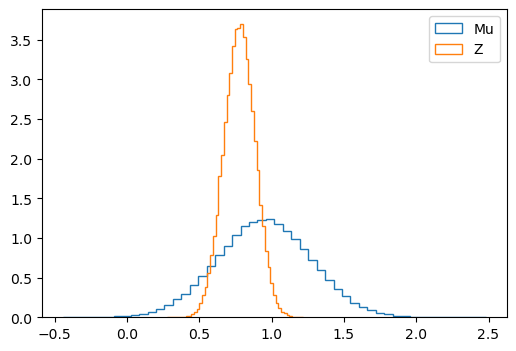

In [11]:
### Single experiment x1000 nominal z
n_data = 500000
mu_test = 1.0


n_exp = 1
n_data_nom = n_data

X_sig_data_nom = np.random.normal(0, feature_std, (n_exp, int(n_data_nom*sigScaling*mu_test), 2))
#X_sig_data_nom = np.random.normal(0, feature_std, (n_exp, int(n_data_nom), 2))
Y_sig_data_nom = np.ones((n_exp, int(n_data_nom*sigScaling*mu_test)))
#Y_sig_data_nom = np.ones((n_exp, int(n_data_nom)))

Z_incarnation = np.array([z_nominal])

print(Z_incarnation)

centres_sig_data_nom = np.expand_dims(r* np.vstack([np.cos(Z_incarnation), np.sin(Z_incarnation)]).T, 1)\

X_sig_data_nom += centres_sig_data_nom


X_back_data_nom = np.random.normal(0, feature_std, (n_exp, int(n_data_nom*backScaling), 2))
#X_back_data_nom = np.random.normal(0, feature_std, (n_exp, int(n_data_nom), 2))
Y_back_data_nom = np.zeros((n_exp, int(n_data_nom*backScaling)))
#Y_back_data_nom = np.zeros((n_exp, int(n_data_nom)))

centres_back_data_nom = np.expand_dims(r* np.vstack([-np.cos(Z_incarnation), -np.sin(Z_incarnation)]).T, 1)

X_back_data_nom += centres_back_data_nom

X_data_nom = np.concatenate([X_sig_data_nom,X_back_data_nom], 1)
Y_data_nom = np.hstack([Y_sig_data_nom,Y_back_data_nom])
Z_data_nom = np.zeros_like(Y_data_nom) + np.expand_dims(Z_incarnation, 1)

weights_data_nom = np.ones_like(Y_data_nom)
#weights_data_nom[Y_data_nom==1] *=sigScaling
#weights_data_nom[Y_data_nom==0] *=backScaling


out = []
for i in range(0, 10):
    with torch.no_grad():
        
        batch_indices = np.random.permutation(X_data_nom[0].shape[0])[:size_batch]
        #print(batch_indices)
        
        
        x_data_sort = X_data_nom[0][batch_indices]
        
        sort_ind = np.argsort(x_data_sort[:,0], axis=0)
        x_data_sort = x_data_sort[sort_ind]

        x_data = torch.tensor(x_data_sort).to(current_settings["device"]).float()
        x_data = x_data.reshape(1,-1)

        cond_inputs = x_data.repeat((10000, 1))

        
        #cond_inputs = torch.tensor(X_data_nom[0][batch_indices]).to(current_settings["device"]).float()
        
        #cond_inputs = cond_inputs.view(1, -1)
        
        outputs_flow = model.sample(num_samples = 10000, noise=None, 
                                    cond_inputs = cond_inputs, 
                                   ).cpu().numpy()*10.0
        out.append(outputs_flow)
out = np.vstack(out)


fig = plt.figure(figsize=(6,4))
subplot = fig.add_subplot(1,1,1)   

c, bins, _ = subplot.hist(out[:,1], histtype='step', label ='Mu', linewidth = 1, linestyle = '-', alpha = 1.0, density=True, bins=50)
c, bins, _ = subplot.hist(out[:,0], histtype='step', label ='Z', linewidth = 1, linestyle = '-', alpha = 1.0, density=True, bins=50)
subplot.legend()


In [12]:
n_data = 5000000
mu_test = 1.0


n_exp = 1
n_data_nom = n_data

X_sig_data_nom = np.random.normal(0, feature_std, (n_exp, int(n_data_nom*sigScaling*mu_test), 2))
Z_incarnation = np.array([z_nominal])

centres_sig_data_nom = np.expand_dims(r* np.vstack([np.cos(Z_incarnation), np.sin(Z_incarnation)]).T, 1)\

X_sig_data_nom += centres_sig_data_nom
X_back_data_nom = np.random.normal(0, feature_std, (n_exp, int(n_data_nom*backScaling), 2))

centres_back_data_nom = np.expand_dims(r* np.vstack([-np.cos(Z_incarnation), -np.sin(Z_incarnation)]).T, 1)

X_back_data_nom += centres_back_data_nom

X_data_nom = np.concatenate([X_sig_data_nom,X_back_data_nom], 1)


mu_range = np.arange(-0.0, 2.1, 0.1)

nll2d = np.zeros((len(mu_range), len(z_syst_train)))


for i, mu in enumerate(mu_range):
    for j, z in enumerate(z_syst_train):
        nll = []
        for k in range(0, 50):
            with torch.no_grad():

                batch_indices = np.random.permutation(X_data_nom[0].shape[0])[:size_batch]
                #print(batch_indices)


                x_data_sort = X_data_nom[0][batch_indices]

                sort_ind = np.argsort(x_data_sort[:,0], axis=0)
                x_data_sort = x_data_sort[sort_ind]

                x_data = torch.tensor(x_data_sort).to(current_settings["device"]).float()
                x_data = x_data.reshape(1,-1)

                cond_inputs = x_data
  
    
    
        
                mu_data = (torch.ones((x_data.size(0), 1))*mu).to(current_settings["device"])
                z_data  = (torch.ones((x_data.size(0), 1))*z).to(current_settings["device"])
                pad_data = (torch.torch.randn(x_data.size(0), 6)).to(current_settings["device"])


                inputs = torch.cat((z_data.view(-1, 1), mu_data.view(-1, 1), pad_data), 1).float()/10.0
  
                log_prob = - model.log_probs(inputs, cond_inputs = cond_inputs)
            
                nll.append(log_prob.cpu().numpy())
            
        nll = np.array(nll)
        nll2d[i,j] = nll2d[i,j] + np.mean(nll)

    print(mu)
                


-0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
1.0
1.1
1.2000000000000002
1.3
1.4000000000000001
1.5
1.6
1.7000000000000002
1.8
1.9000000000000001
2.0


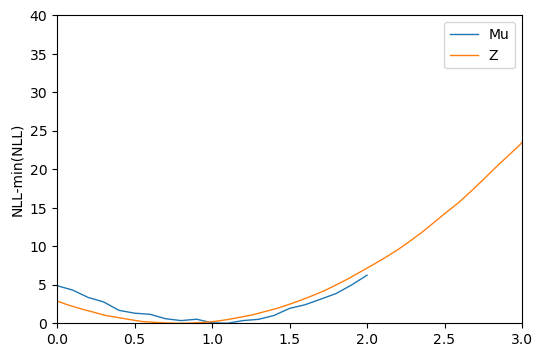

In [13]:
nll1d_mu = np.min(nll2d, 1)
nll1d_z = np.min(nll2d, 0)

fig = plt.figure(figsize=(6,4))
subplot = fig.add_subplot(1,1,1)   

subplot.plot(mu_range, (nll1d_mu-min(nll1d_mu)), 
             label ='Mu', linewidth = 1, linestyle = '-', alpha = 1.0)
subplot.plot(z_syst_train, (nll1d_z-min(nll1d_z))/10, 
             label ='Z', linewidth = 1, linestyle = '-', alpha = 1.0)
subplot.set_ylim(0, 40)
subplot.set_xlim(0, 3)
subplot.set_ylabel('NLL-min(NLL)')
subplot.legend()


0.2807229339235661 0.9939744721285497


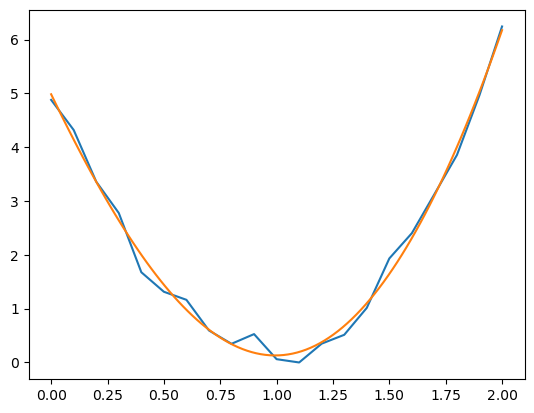

In [14]:
def ConfidenceIntervalls(mu_values, nll1D, central=1.0):
    z = np.polyfit(mu_values[(mu_values-central)<=1], nll1D[(mu_values-central)<=1], 4)
    poly = np.poly1d(z)
    #1 Sigma = 0.5, 2 Sigma = 2, 3 Sigma = 4.5
    threshs = [0.5, 2.0, 4.5]
    sigmas = [1.0, 2.0, 3.0]
    ret_intersects = []
    std = 0.0
    
    deriv1 = poly.deriv()
    deriv2 = poly.deriv(2)
    
    extr = (deriv1).roots
    minimum = extr[np.argsort(np.abs(extr-central))][0]
    
    assert deriv2(minimum) > 0
    
    
    for t,s  in zip(threshs, sigmas):
        intersects = (poly - t).roots
        # Select 2 roots closest to central value (only needed for polynomials with order > 2
        ret_intersects.append(intersects[np.argsort(np.abs(intersects-central))][:2])    
        std += (abs(ret_intersects[-1][0] - ret_intersects[-1][1])/(s*2))
        
    std = std/len(sigmas)
    
    plt.plot(mu_values[(mu_values-central)<=1], nll1D[(mu_values-central)<=1], label='Data')
    plt.plot(np.linspace(central-1,central+1, 100), poly(np.linspace(0,2, 100)), label='Fit')
    return std, ret_intersects, minimum
    

sigma_NPE_nom, _, mu_NPE_nom = ConfidenceIntervalls(mu_values=mu_range, nll1D=(nll1d_mu-min(nll1d_mu)))

print(sigma_NPE_nom, mu_NPE_nom)

In [15]:
### Single experiment x1000 nominal z
n_data = 500000
mu_test = 1.0


n_exp = 500
n_data_nom = n_data

X_sig_data_nom = np.random.normal(0, feature_std, (n_exp, int(n_data_nom*sigScaling*mu_test), 2))
#X_sig_data_nom = np.random.normal(0, feature_std, (n_exp, int(n_data_nom), 2))
Y_sig_data_nom = np.ones((n_exp, int(n_data_nom*sigScaling*mu_test)))
#Y_sig_data_nom = np.ones((n_exp, int(n_data_nom)))

Z_incarnation = np.array([z_nominal])

print(Z_incarnation)

centres_sig_data_nom = np.expand_dims(r* np.vstack([np.cos(Z_incarnation), np.sin(Z_incarnation)]).T, 1)\

X_sig_data_nom += centres_sig_data_nom


X_back_data_nom = np.random.normal(0, feature_std, (n_exp, int(n_data_nom*backScaling), 2))
#X_back_data_nom = np.random.normal(0, feature_std, (n_exp, int(n_data_nom), 2))
Y_back_data_nom = np.zeros((n_exp, int(n_data_nom*backScaling)))
#Y_back_data_nom = np.zeros((n_exp, int(n_data_nom)))

centres_back_data_nom = np.expand_dims(r* np.vstack([-np.cos(Z_incarnation), -np.sin(Z_incarnation)]).T, 1)

X_back_data_nom += centres_back_data_nom

X_data_nom = np.concatenate([X_sig_data_nom,X_back_data_nom], 1)
Y_data_nom = np.hstack([Y_sig_data_nom,Y_back_data_nom])
Z_data_nom = np.zeros_like(Y_data_nom) + np.expand_dims(Z_incarnation, 1)

weights_data_nom = np.ones_like(Y_data_nom)
#weights_data_nom[Y_data_nom==1] *=sigScaling
#weights_data_nom[Y_data_nom==0] *=backScaling


mus_mean, mus_mpv = [], []

for i_exp in range(n_exp):
    out = []
    for i in range(0, 10):
        with torch.no_grad():

            batch_indices = np.random.permutation(X_data_nom[0].shape[0])[:size_batch]
            #print(batch_indices)


            x_data_sort = X_data_nom[0][batch_indices]

            sort_ind = np.argsort(x_data_sort[:,0], axis=0)
            x_data_sort = x_data_sort[sort_ind]

            x_data = torch.tensor(x_data_sort).to(current_settings["device"]).float()
            x_data = x_data.reshape(1,-1)

            cond_inputs = x_data.repeat((10000, 1))


            #cond_inputs = torch.tensor(X_data_nom[0][batch_indices]).to(current_settings["device"]).float()

            #cond_inputs = cond_inputs.view(1, -1)

            outputs_flow = model.sample(num_samples = 10000, noise=None, 
                                        cond_inputs = cond_inputs, 
                                       ).cpu().numpy()*10.0
            out.append(outputs_flow)
    out = np.vstack(out)
    mu_mean = np.mean(out[:,1])

    hist, bin_edges = np.histogram(out[:,1], bins=50, range=(0,2))
    
    #print(hist)
    
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    mu_mpv = bin_centers[np.argmax(hist)]
    
    mus_mean.append(mu_mean)
    mus_mpv.append(mu_mpv)
 


[0.78539816]


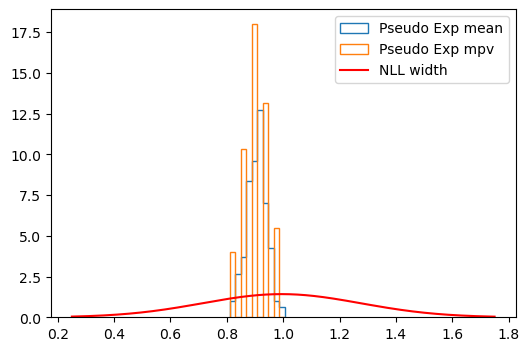

In [17]:
from scipy.stats import norm

mus_mean = np.array(mus_mean)
mus_mpv = np.array(mus_mpv)

x_gauss = np.linspace(0.25, 1.75, 1000)


fig = plt.figure(figsize=(6,4))
subplot = fig.add_subplot(1,1,1)   

c, bins, _ = subplot.hist(mus_mean, histtype='step', label ='Pseudo Exp mean', linewidth = 1, linestyle = '-', alpha = 1.0, density=True, bins=10)
c, bins, _ = subplot.hist(mus_mpv, histtype='step', label ='Pseudo Exp mpv', linewidth = 1, linestyle = '-', alpha = 1.0, density=True, bins=bins)

subplot.plot(x_gauss, (norm.pdf((x_gauss-mu_NPE_nom)/sigma_NPE_nom))/sigma_NPE_nom, label='NLL width', color='r')

subplot.legend()

# Coverage Tests


Generate 1000 pseudo experiments, using the same number of events as in the test sample (500k signal and 500k background, but scaled by the class weights of 0.1 and 0.001, resulting in 50k background and 500 signal events. 

As a crosscheck two versions of the data are generated, one in which the nuisance `z` parameter is fixed to the mean `z_nominal` (`X_sig_data_nom` etc.) and one where it is sampled from the prior, with every pseudo experiment having a different `z` that remains consistent for that experiment (`X_sig_data_samp` etc.)


In [92]:
true_mu = 1; # variable never used
sigScaling = 1/(10**3.) # because signal is usually much smaller than background but we produced equal
backScaling = sigScaling*100 



### Single experiment x1000 nominal z
n_data = 500000

n_exp = 100
n_data_nom = n_data

X_sig_data_nom = np.random.normal(0, feature_std, (n_exp, int(n_data_nom*sigScaling), 2))
Y_sig_data_nom = np.ones((n_exp, int(n_data_nom*sigScaling)))

Z_incarnation = np.array([z_nominal])
centres_sig_data_nom = np.expand_dims(r* np.vstack([np.cos(Z_incarnation), np.sin(Z_incarnation)]).T, 1)\

X_sig_data_nom += centres_sig_data_nom


X_back_data_nom = np.random.normal(0, feature_std, (n_exp, int(n_data_nom*backScaling), 2))
Y_back_data_nom = np.zeros((n_exp, int(n_data_nom*backScaling)))

centres_back_data_nom = np.expand_dims(r* np.vstack([-np.cos(Z_incarnation), -np.sin(Z_incarnation)]).T, 1)

X_back_data_nom += centres_back_data_nom

X_data_nom = np.concatenate([X_sig_data_nom,X_back_data_nom], 1)
Y_data_nom = np.hstack([Y_sig_data_nom,Y_back_data_nom])
Z_data_nom = np.zeros_like(Y_data_nom) + np.expand_dims(Z_incarnation, 1)

weights_data_nom = np.ones_like(Y_data_nom)



### Single experiment x1000 sampled z

n_data_nomsamp = n_data

X_sig_data_nomsamp = np.random.normal(0, feature_std, (n_exp, int(n_data_nomsamp*sigScaling), 2))
Y_sig_data_nomsamp = np.ones((n_exp, int(n_data_nomsamp*sigScaling)))

Z_incarnation = np.random.normal(z_nominal, z_std, n_exp)
centres_sig_data_nomsamp = np.expand_dims(r* np.vstack([np.cos(Z_incarnation), np.sin(Z_incarnation)]).T, 1)\

X_sig_data_nomsamp += centres_sig_data_nomsamp


X_back_data_nomsamp = np.random.normal(0, feature_std, (n_exp, int(n_data_nomsamp*backScaling), 2))
Y_back_data_nomsamp = np.zeros((n_exp, int(n_data_nomsamp*backScaling)))

centres_back_data_nomsamp = np.expand_dims(r* np.vstack([-np.cos(Z_incarnation), -np.sin(Z_incarnation)]).T, 1)

X_back_data_nomsamp += centres_back_data_nomsamp


X_data_nomsamp = np.concatenate([X_sig_data_nomsamp,X_back_data_nomsamp], 1)
Y_data_nomsamp = np.hstack([Y_sig_data_nomsamp,Y_back_data_nomsamp])
Z_data_nomsamp = np.zeros_like(Y_data_nomsamp) + np.expand_dims(Z_incarnation, 1)

weights_data_nomsamp = np.ones_like(Y_data_nomsamp)


In [94]:
systUp = z_nominal*2.0



### Single experiment x1000 systUpinal z
n_data = 500000

n_exp = 100
n_data_systUp = n_data

X_sig_data_systUp = np.random.normal(0, feature_std, (n_exp, int(n_data_systUp*sigScaling), 2))
Y_sig_data_systUp = np.ones((n_exp, int(n_data_systUp*sigScaling)))

Z_incarnation = np.array([systUp])
centres_sig_data_systUp = np.expand_dims(r* np.vstack([np.cos(Z_incarnation), np.sin(Z_incarnation)]).T, 1)\

X_sig_data_systUp += centres_sig_data_systUp


X_back_data_systUp = np.random.normal(0, feature_std, (n_exp, int(n_data_systUp*backScaling), 2))
Y_back_data_systUp = np.zeros((n_exp, int(n_data_systUp*backScaling)))

centres_back_data_systUp = np.expand_dims(r* np.vstack([-np.cos(Z_incarnation), -np.sin(Z_incarnation)]).T, 1)

X_back_data_systUp += centres_back_data_systUp

X_data_systUp = np.concatenate([X_sig_data_systUp,X_back_data_systUp], 1)
Y_data_systUp = np.hstack([Y_sig_data_systUp,Y_back_data_systUp])
Z_data_systUp = np.zeros_like(Y_data_systUp) + np.expand_dims(Z_incarnation, 1)

weights_data_systUp = np.ones_like(Y_data_systUp)



### Single experiment x1000 sampled z

n_data_systUpsamp = n_data

X_sig_data_systUpsamp = np.random.normal(0, feature_std, (n_exp, int(n_data_systUpsamp*sigScaling), 2))
Y_sig_data_systUpsamp = np.ones((n_exp, int(n_data_systUpsamp*sigScaling)))

Z_incarnation = np.random.normal(systUp, z_std, n_exp)
centres_sig_data_systUpsamp = np.expand_dims(r* np.vstack([np.cos(Z_incarnation), np.sin(Z_incarnation)]).T, 1)\

X_sig_data_systUpsamp += centres_sig_data_systUpsamp


X_back_data_systUpsamp = np.random.normal(0, feature_std, (n_exp, int(n_data_systUpsamp*backScaling), 2))
Y_back_data_systUpsamp = np.zeros((n_exp, int(n_data_systUpsamp*backScaling)))

centres_back_data_systUpsamp = np.expand_dims(r* np.vstack([-np.cos(Z_incarnation), -np.sin(Z_incarnation)]).T, 1)

X_back_data_systUpsamp += centres_back_data_systUpsamp


X_data_systUpsamp = np.concatenate([X_sig_data_systUpsamp,X_back_data_systUpsamp], 1)
Y_data_systUpsamp = np.hstack([Y_sig_data_systUpsamp,Y_back_data_systUpsamp])
Z_data_systUpsamp = np.zeros_like(Y_data_systUpsamp) + np.expand_dims(Z_incarnation, 1)

weights_data_systUpsamp = np.ones_like(Y_data_systUpsamp)


## Defining new template regions

The original template range did not cover a large enough `z` range to handle all the possible values when sampling from the Gaussian prior. This follows the previous code for setting up the data for the template generation, but extends the range

In [95]:

n_shifts_train = 51
syst_shifts_train = np.arange(-20,31)/10
z_syst_train =  z_nominal * syst_shifts_train



X_sig_syst_train = np.array([np.vstack( [np.random.normal(0, feature_std, n_data), np.random.normal(0, feature_std, n_data)]).T 
              for i in range (n_shifts_train)])
Y_sig_syst_train = np.array([np.ones(n_data) for i in range (n_shifts_train)])
centres_sig_syst_train = np.array([r* np.vstack([np.cos(z_syst_train[i]), np.sin(z_syst_train[i])]).T for i in range(n_shifts_train)])
X_sig_syst_train += centres_sig_syst_train

X_back_syst_train = np.array([np.vstack( [np.random.normal(0, feature_std, n_data), np.random.normal(0, feature_std, n_data)]).T
                        for i in range (n_shifts_train)])
Y_back_syst_train = np.array([np.zeros(n_data) for i in range (n_shifts_train)])
centres_back_syst_train = np.array([r* np.vstack([-np.cos(z_syst_train[i]), -np.sin(z_syst_train[i])]).T for i in range(n_shifts_train)])
X_back_syst_train += centres_back_syst_train

X_syst_train = np.concatenate([X_sig_syst_train,X_back_syst_train], 1)
Y_syst_train = np.hstack([Y_sig_syst_train,Y_back_syst_train])
Z_syst_train  = np.ones_like(Y_syst_train) * z_syst_train.reshape(-1,1)


X_syst_train = X_syst_train.reshape(-1,X_syst_train.shape[-1])
Y_syst_train = Y_syst_train.reshape(-1)
Z_syst_train = Z_syst_train.reshape(-1)


weights_syst_train = np.ones_like(Y_syst_train)
weights_syst_train[Y_syst_train==1] *=sigScaling
weights_syst_train[Y_syst_train==0] *=backScaling


Redefining the previous template functions to use the extended range instead of the previous range. 

In [96]:
mu_values1D = np.arange(0,50)/10



def buildTemplatesTrain(model, clfName,nBins=nBins):
    sig_hists = []
    back_hists = []
    
    if not (clfName == "Aware"):
        if (clfName == "Invariant"):
            Y_pred_model = model.predict(X_syst_train, batch_size=4000).reshape(-1)
        elif ((clfName == "Nominal") or (clfName == "Augmented") or (clfName == "Up")):
            if (clfName == "Augmented") and (~aug_NN):
                Y_pred_model = model.predict_proba(X_syst_train)[:,1].reshape(-1)
            else:
                Y_pred_model = model.predict(X_syst_train).reshape(-1)
        else:
            print ("Unexpected Clf name!!")
    
    for z_val in z_syst_train:
        zEvents = np.isclose(Z_syst_train, z_val)

        if (clfName == 'Aware'):
            Y_pred_model = aware_model.predict([X_syst_train[zEvents],Z_syst_train[zEvents]]).reshape(-1)

            hist_sig, bin_array = np.histogram(
                Y_pred_model[Y_syst_train[zEvents]==1], 
                weights=weights_syst_train[zEvents][Y_syst_train[zEvents]==1], range=(0,1), bins=nBins)
            hist_back, bin_array = np.histogram(
                Y_pred_model[Y_syst_train[zEvents]==0], 
                weights=weights_syst_train[zEvents][Y_syst_train[zEvents]==0], range=(0,1), bins=nBins)    
            
        else:
            hist_sig, bin_array = np.histogram(
                Y_pred_model[zEvents &(Y_syst_train==1)], 
                weights=weights_syst_train[zEvents &(Y_syst_train==1)], range=(0,1), bins=nBins)
            hist_back, bin_array = np.histogram(
                Y_pred_model[zEvents &(Y_syst_train==0)], 
                weights=weights_syst_train[zEvents &(Y_syst_train==0)], range=(0,1), bins=nBins)

        sig_hists.append(hist_sig)
        back_hists.append(hist_back)
    sig_hists = np.array(sig_hists)
    back_hists = np.array(back_hists)
    return sig_hists, back_hists



Modifying the NLL scans to use the extended range and directly return the values for the nuisance parameter `z` and the signal rate `mu` with the lowest NLL

In [97]:
def computeNLL2D_returnMu(obs1D, sH2d, bH2d, mu_values=mu_values1D, z_syst_vals=z_syst):
    min_mu, min_z, minnll = 999,999,999999
    assert len(obs1D) == sH2d.shape[1] == bH2d.shape[1]
    nll2D = np.zeros(mu_values.shape[0] * sH2d.shape[0]).reshape(mu_values.shape[0],sH2d.shape[0])    
    for i, z_val in enumerate(z_syst_vals):
        for k,mu in enumerate(mu_values):
            nll2D[k][i] += nll_syst(dTheta=z_val-z_nominal, sigma=z_std)
            for n,s,b in zip(obs1D, sH2d[i], bH2d[i]): # over the bins of score histo
                bin_nll = nll_stat(N=n,S=s,B=b,mu=mu)
                if (not np.isnan(bin_nll)):
                    nll2D[k][i] += bin_nll
            if nll2D[k][i] < minnll:
                minnll = nll2D[k][i]
                min_mu = mu
                min_z = z_val
    #print ("Min at mu,z: ",min_mu, min_z)
    return nll2D, min_mu, min_z
        
    
    
def computeNLL2D_aware_returnMu(obs2D, sH2d, bH2d, mu_values=mu_values1D, z_syst_vals=z_syst):
    min_mu, min_z, minnll = 999,999,999999
    assert obs2D.shape[1] == sH2d.shape[1] == bH2d.shape[1]
    nll2D = np.zeros(mu_values.shape[0] * sH2d.shape[0]).reshape(mu_values.shape[0],sH2d.shape[0])
    for i, z_val in enumerate(z_syst_vals):
        for k,mu in enumerate(mu_values):
            nll2D[k][i] += nll_syst(dTheta=z_val-z_nominal, sigma=z_std) # @ToDo: can be moved outside loop
            for n,s,b in zip(obs2D[i], sH2d[i], bH2d[i]): # over the bins of score histo
                bin_nll = nll_stat(N=n,S=s,B=b,mu=mu)
                if (not np.isnan(bin_nll)):
                    nll2D[k][i] += bin_nll
            if nll2D[k][i] < minnll:
                minnll = nll2D[k][i]
                min_mu = mu
                min_z = z_val
    #print ("Min at mu,z: ",min_mu, min_z)
    return nll2D, min_mu, min_z
        
        
def createHistObsPredicted(weights, Y_pred,):
    hist_obs, bin_array = np.histogram(Y_pred.reshape(-1), weights=weights.reshape(-1), range=(0,1), bins=nBins)
    return hist_obs, bin_array

def createHistObsAwe(X, weights):
    hist_obs_awe2D = []
    for hyp_z in z_syst_train:
        Y = aware_model.predict([X, np.ones(X.shape[0]) * hyp_z],).reshape(-1)
        hist_obs_awe, bin_array = np.histogram(Y, weights=weights, range=(0,1), bins=nBins)
        hist_obs_awe2D.append(hist_obs_awe)
    hist_obs_awe2D = np.array(hist_obs_awe2D)
    return hist_obs_awe2D

        



In [99]:
print(X_data_nom.shape, X_data_nomsamp.shape)

Y_predict_data_aug_nom, Y_predict_data_aug_nomsamp = [], []

for i in range(X_data_nom.shape[0]):
    Y_predict_data_aug_nom.append(augmented_model.predict_proba(X_data_nom[i])[:,1])
    Y_predict_data_aug_nomsamp.append(augmented_model.predict_proba(X_data_nomsamp[i])[:,1])
    
Y_predict_data_aug_nom = np.array(Y_predict_data_aug_nom)
Y_predict_data_aug_nomsamp = np.array(Y_predict_data_aug_nomsamp)

Y_predict_data_inv_nom = inv_model.predict(X_data_nom, batch_size=4*1024)[:,:,0]
Y_predict_data_inv_nomsamp = inv_model.predict(X_data_nomsamp, batch_size=4*1024)[:,:,0]

Y_predict_data_nom = nominal_model.predict(X_data_nom)
Y_predict_data_nomsamp = nominal_model.predict(X_data_nomsamp)

print(Y_predict_data_aug_nom.shape, Y_predict_data_inv_nom.shape, Y_predict_data_nom.shape)
print(Y_predict_data_aug_nomsamp.shape, Y_predict_data_inv_nomsamp.shape, Y_predict_data_nomsamp.shape)


(100, 50500, 2) (100, 50500, 2)


2023-05-23 14:54:09.690886: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1292800000 exceeds 10% of free system memory.
2023-05-23 14:54:09.905908: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1292800000 exceeds 10% of free system memory.
2023-05-23 14:54:10.313152: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1292800000 exceeds 10% of free system memory.
2023-05-23 14:54:10.509604: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1292800000 exceeds 10% of free system memory.
2023-05-23 14:54:10.702312: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1292800000 exceeds 10% of free system memory.


1/1 [==============================] - 2s 2s/step
(100, 50500) (100, 50500) (100, 50500)
(100, 50500) (100, 50500) (100, 50500)


In [102]:
print(X_data_systUp.shape, X_data_systUpsamp.shape)

Y_predict_data_aug_systUp, Y_predict_data_aug_systUpsamp = [], []

for i in range(X_data_systUp.shape[0]):
    Y_predict_data_aug_systUp.append(augmented_model.predict_proba(X_data_systUp[i])[:,1])
    Y_predict_data_aug_systUpsamp.append(augmented_model.predict_proba(X_data_systUpsamp[i])[:,1])
    
Y_predict_data_aug_systUp = np.array(Y_predict_data_aug_systUp)
Y_predict_data_aug_systUpsamp = np.array(Y_predict_data_aug_systUpsamp)

Y_predict_data_inv_systUp = inv_model.predict(X_data_systUp, batch_size=4*1024)[:,:,0]
Y_predict_data_inv_systUpsamp = inv_model.predict(X_data_systUpsamp, batch_size=4*1024)[:,:,0]

Y_predict_data_systUp = nominal_model.predict(X_data_systUp)
Y_predict_data_systUpsamp = nominal_model.predict(X_data_systUpsamp)

print(Y_predict_data_aug_systUp.shape, Y_predict_data_inv_systUp.shape, Y_predict_data_systUp.shape)
print(Y_predict_data_aug_systUpsamp.shape, Y_predict_data_inv_systUpsamp.shape, Y_predict_data_systUpsamp.shape)


(100, 50500, 2) (100, 50500, 2)
1/1 [==============================] - 2s 2s/step
(100, 50500) (100, 50500) (100, 50500)
(100, 50500) (100, 50500) (100, 50500)


Running the NLL scan on each pseudo experiment, and saving the resulting signal rate `mu` for all of them.  This is done for both the nominal and sample nuisance parameter. 

In [103]:
sig_hists_clf, back_hists_clf = buildTemplatesTrain(model=nominal_model, clfName="Nominal")
sig_hists_awe, back_hists_awe = buildTemplatesTrain(model=aware_model, clfName='Aware')

sig_hists_inv, back_hists_inv = buildTemplatesTrain(model=inv_model, clfName="Invariant")
sig_hists_aug, back_hists_aug = buildTemplatesTrain(model=augmented_model, clfName='Augmented')



12750/12750 [==============================] - 26s 2ms/step


In [104]:


mus_clf_nom, mus_awe_nom, mus_inv_nom, mus_aug_nom = [],[],[],[]
mus_clf_nomsamp, mus_awe_nomsamp, mus_inv_nomsamp, mus_aug_nomsamp = [],[],[],[]
#print(sig_hists_awe)


j = 1
#for j in range(0,1):
for j in range(0, weights_data_nomsamp.shape[0]):
    
    hist_obs_nom, bin_array_nom = createHistObsPredicted(weights=weights_data_nom[j:j+1], Y_pred=Y_predict_data_nom[j:j+1])
    hist_obs_nomsamp, bin_array_nomsamp = createHistObsPredicted(weights=weights_data_nomsamp[j:j+1], Y_pred=Y_predict_data_nomsamp[j:j+1])

    hist_obs_aug_nom, bin_array_aug_nom = createHistObsPredicted(weights=weights_data_nom[j:j+1], Y_pred=Y_predict_data_aug_nom[j:j+1])
    hist_obs_aug_nomsamp, bin_array_aug_nomsamp = createHistObsPredicted(weights=weights_data_nomsamp[j:j+1], Y_pred=Y_predict_data_aug_nomsamp[j:j+1])
    
    hist_obs_inv_nom, bin_array_inv_nom = createHistObsPredicted(weights=weights_data_nom[j:j+1], Y_pred=Y_predict_data_inv_nom[j:j+1])
    hist_obs_inv_nomsamp, bin_array_inv_nomsamp = createHistObsPredicted(weights=weights_data_nomsamp[j:j+1], Y_pred=Y_predict_data_inv_nomsamp[j:j+1])
    
    hist_obs_awe2D_nom = createHistObsAwe(X_data_nom[j:j+1], weights=weights_data_nom[j])
    hist_obs_awe2D_nomsamp = createHistObsAwe(X_data_nomsamp[j:j+1], weights=weights_data_nomsamp[j])

    
    nll2D_clf_data_nom, min_mu_clf_nom, min_z_clf_nom = computeNLL2D_returnMu(obs1D=hist_obs_nom, sH2d=sig_hists_clf, bH2d=back_hists_clf, z_syst_vals=z_syst_train)
    nll2D_clf_data_nomsamp, min_mu_clf_nomsamp, min_z_clf_nomsamp = computeNLL2D_returnMu(obs1D=hist_obs_nomsamp, sH2d=sig_hists_clf, bH2d=back_hists_clf, z_syst_vals=z_syst_train)
    
    nll2D_aug_data_nom, min_mu_aug_nom, min_z_aug_nom = computeNLL2D_returnMu(obs1D=hist_obs_aug_nom, sH2d=sig_hists_aug, bH2d=back_hists_aug, z_syst_vals=z_syst_train)
    nll2D_aug_data_nomsamp, min_mu_aug_nomsamp, min_z_aug_nomsamp = computeNLL2D_returnMu(obs1D=hist_obs_aug_nomsamp, sH2d=sig_hists_aug, bH2d=back_hists_aug, z_syst_vals=z_syst_train)
    
    nll2D_inv_data_nom, min_mu_inv_nom, min_z_inv_nom = computeNLL2D_returnMu(obs1D=hist_obs_inv_nom, sH2d=sig_hists_inv, bH2d=back_hists_inv, z_syst_vals=z_syst_train)
    nll2D_inv_data_nomsamp, min_mu_inv_nomsamp, min_z_inv_nomsamp = computeNLL2D_returnMu(obs1D=hist_obs_inv_nomsamp, sH2d=sig_hists_inv, bH2d=back_hists_inv, z_syst_vals=z_syst_train)
    
    nll2D_awe_data_nom, min_mu_awe_nom, min_z_awe_nom = computeNLL2D_aware_returnMu(obs2D=hist_obs_awe2D_nom, sH2d=sig_hists_awe, bH2d=back_hists_awe, z_syst_vals=z_syst_train)
    nll2D_awe_data_nomsamp, min_mu_awe_nomsamp, min_z_awe_nomsamp = computeNLL2D_aware_returnMu(obs2D=hist_obs_awe2D_nomsamp, sH2d=sig_hists_awe, bH2d=back_hists_awe, z_syst_vals=z_syst_train)

    #print(hist_obs_awe2D_nom, sig_hists_awe, back_hists_awe)
    
    
    mus_clf_nom.append(min_mu_clf_nom)
    mus_clf_nomsamp.append(min_mu_clf_nomsamp)
    mus_aug_nom.append(min_mu_aug_nom)
    mus_aug_nomsamp.append(min_mu_aug_nomsamp)
    mus_inv_nom.append(min_mu_inv_nom)
    mus_inv_nomsamp.append(min_mu_inv_nomsamp)
    mus_awe_nom.append(min_mu_awe_nom)
    mus_awe_nomsamp.append(min_mu_awe_nomsamp)
    

    
    #print(min_mu_clf_nom, min_mu_aug_nom, min_mu_inv_nom, min_mu_awe_nom)
    




In [105]:


mus_clf_systUp, mus_awe_systUp, mus_inv_systUp, mus_aug_systUp = [],[],[],[]
mus_clf_systUpsamp, mus_awe_systUpsamp, mus_inv_systUpsamp, mus_aug_systUpsamp = [],[],[],[]
#print(sig_hists_awe)


j = 1
#for j in range(0,1):
for j in range(0, weights_data_systUpsamp.shape[0]):
    
    hist_obs_systUp, bin_array_systUp = createHistObsPredicted(weights=weights_data_systUp[j:j+1], Y_pred=Y_predict_data_systUp[j:j+1])
    hist_obs_systUpsamp, bin_array_systUpsamp = createHistObsPredicted(weights=weights_data_systUpsamp[j:j+1], Y_pred=Y_predict_data_systUpsamp[j:j+1])

    hist_obs_aug_systUp, bin_array_aug_systUp = createHistObsPredicted(weights=weights_data_systUp[j:j+1], Y_pred=Y_predict_data_aug_systUp[j:j+1])
    hist_obs_aug_systUpsamp, bin_array_aug_systUpsamp = createHistObsPredicted(weights=weights_data_systUpsamp[j:j+1], Y_pred=Y_predict_data_aug_systUpsamp[j:j+1])
    
    hist_obs_inv_systUp, bin_array_inv_systUp = createHistObsPredicted(weights=weights_data_systUp[j:j+1], Y_pred=Y_predict_data_inv_systUp[j:j+1])
    hist_obs_inv_systUpsamp, bin_array_inv_systUpsamp = createHistObsPredicted(weights=weights_data_systUpsamp[j:j+1], Y_pred=Y_predict_data_inv_systUpsamp[j:j+1])
    
    hist_obs_awe2D_systUp = createHistObsAwe(X_data_systUp[j:j+1], weights=weights_data_systUp[j])
    hist_obs_awe2D_systUpsamp = createHistObsAwe(X_data_systUpsamp[j:j+1], weights=weights_data_systUpsamp[j])

    
    nll2D_clf_data_systUp, min_mu_clf_systUp, min_z_clf_systUp = computeNLL2D_returnMu(obs1D=hist_obs_systUp, sH2d=sig_hists_clf, bH2d=back_hists_clf, z_syst_vals=z_syst_train)
    nll2D_clf_data_systUpsamp, min_mu_clf_systUpsamp, min_z_clf_systUpsamp = computeNLL2D_returnMu(obs1D=hist_obs_systUpsamp, sH2d=sig_hists_clf, bH2d=back_hists_clf, z_syst_vals=z_syst_train)
    
    nll2D_aug_data_systUp, min_mu_aug_systUp, min_z_aug_systUp = computeNLL2D_returnMu(obs1D=hist_obs_aug_systUp, sH2d=sig_hists_aug, bH2d=back_hists_aug, z_syst_vals=z_syst_train)
    nll2D_aug_data_systUpsamp, min_mu_aug_systUpsamp, min_z_aug_systUpsamp = computeNLL2D_returnMu(obs1D=hist_obs_aug_systUpsamp, sH2d=sig_hists_aug, bH2d=back_hists_aug, z_syst_vals=z_syst_train)
    
    nll2D_inv_data_systUp, min_mu_inv_systUp, min_z_inv_systUp = computeNLL2D_returnMu(obs1D=hist_obs_inv_systUp, sH2d=sig_hists_inv, bH2d=back_hists_inv, z_syst_vals=z_syst_train)
    nll2D_inv_data_systUpsamp, min_mu_inv_systUpsamp, min_z_inv_systUpsamp = computeNLL2D_returnMu(obs1D=hist_obs_inv_systUpsamp, sH2d=sig_hists_inv, bH2d=back_hists_inv, z_syst_vals=z_syst_train)
    
    nll2D_awe_data_systUp, min_mu_awe_systUp, min_z_awe_systUp = computeNLL2D_aware_returnMu(obs2D=hist_obs_awe2D_systUp, sH2d=sig_hists_awe, bH2d=back_hists_awe, z_syst_vals=z_syst_train)
    nll2D_awe_data_systUpsamp, min_mu_awe_systUpsamp, min_z_awe_systUpsamp = computeNLL2D_aware_returnMu(obs2D=hist_obs_awe2D_systUpsamp, sH2d=sig_hists_awe, bH2d=back_hists_awe, z_syst_vals=z_syst_train)

    #print(hist_obs_awe2D_systUp, sig_hists_awe, back_hists_awe)
    
    
    mus_clf_systUp.append(min_mu_clf_systUp)
    mus_clf_systUpsamp.append(min_mu_clf_systUpsamp)
    mus_aug_systUp.append(min_mu_aug_systUp)
    mus_aug_systUpsamp.append(min_mu_aug_systUpsamp)
    mus_inv_systUp.append(min_mu_inv_systUp)
    mus_inv_systUpsamp.append(min_mu_inv_systUpsamp)
    mus_awe_systUp.append(min_mu_awe_systUp)
    mus_awe_systUpsamp.append(min_mu_awe_systUpsamp)
    

    
    #print(min_mu_clf_systUp, min_mu_aug_systUp, min_mu_inv_systUp, min_mu_awe_systUp)
    




Plotting the resulting `mu` distributions for the nominal `z` value (red), and the sampled `z` value (green) and comparing it to a Gaussian distribution with a width and mean derived from the NLL profile (blue). For reference fits of Gaussian distributions to the histogram data are included, sharing a color with the histograms.

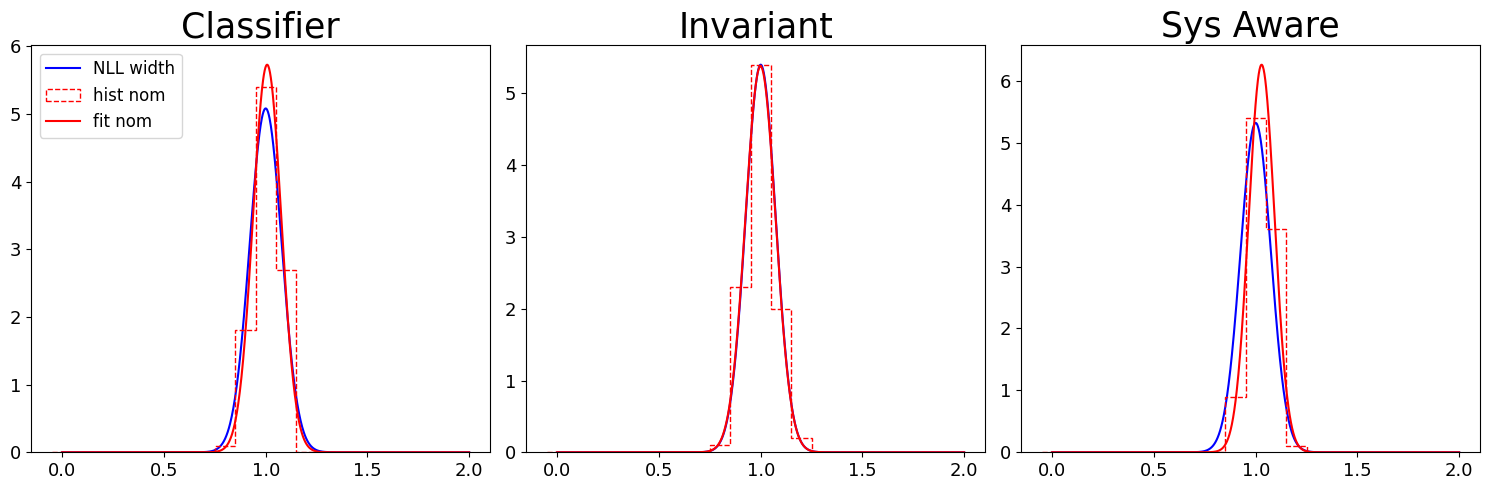

In [133]:
from scipy.stats import norm


fig = plt.figure(figsize=(15,5))
subplot1 = fig.add_subplot(1,3,1)  
subplot2 = fig.add_subplot(1,3,2)  
subplot3 = fig.add_subplot(1,3,3)  

x_gauss = np.linspace(0.0, 2.0, 1000)


y_gauss = (norm.pdf((x_gauss-1)/sigma_clf_nom))/sigma_clf_nom

subplot1.title.set_text('Classifier')
subplot2.title.set_text('Invariant')
subplot3.title.set_text('Sys Aware')

subplot1.plot(x_gauss, (norm.pdf((x_gauss-1)/sigma_clf_nom))/sigma_clf_nom, label='NLL width', color='b')
subplot2.plot(x_gauss, (norm.pdf((x_gauss-1)/sigma_inv_nom))/sigma_inv_nom, label='NLL width', color='b')
subplot3.plot(x_gauss, (norm.pdf((x_gauss-1)/sigma_awe_nom))/sigma_awe_nom, label='NLL width', color='b')


y_gauss_fit = (norm.pdf((x_gauss-np.mean(mus_clf_nom))/np.std(mus_clf_nom)))/np.std(mus_clf_nom)


subplot1.hist(mus_clf_nom, bins=np.arange(-0.05, 2.05, 0.1), density = True, label='hist nom', histtype='step', color='r', ls='--')
subplot2.hist(mus_inv_nom, bins=np.arange(-0.05, 2.05, 0.1), density = True, label='hist nom', histtype='step', color='r', ls='--')
subplot3.hist(mus_awe_nom, bins=np.arange(-0.05, 2.05, 0.1), density = True, label='hist nom', histtype='step', color='r', ls='--')



subplot1.plot(x_gauss, (norm.pdf((x_gauss-np.mean(mus_clf_nom))/np.std(mus_clf_nom)))/np.std(mus_clf_nom), label='fit nom', color='r')
subplot2.plot(x_gauss, (norm.pdf((x_gauss-np.mean(mus_inv_nom))/np.std(mus_inv_nom)))/np.std(mus_inv_nom), label='fit nom', color='r')
subplot3.plot(x_gauss, (norm.pdf((x_gauss-np.mean(mus_awe_nom))/np.std(mus_awe_nom)))/np.std(mus_awe_nom), label='fit nom', color='r')


subplot1.legend(loc = 'upper left', fontsize=12)
plt.savefig('nom.png')

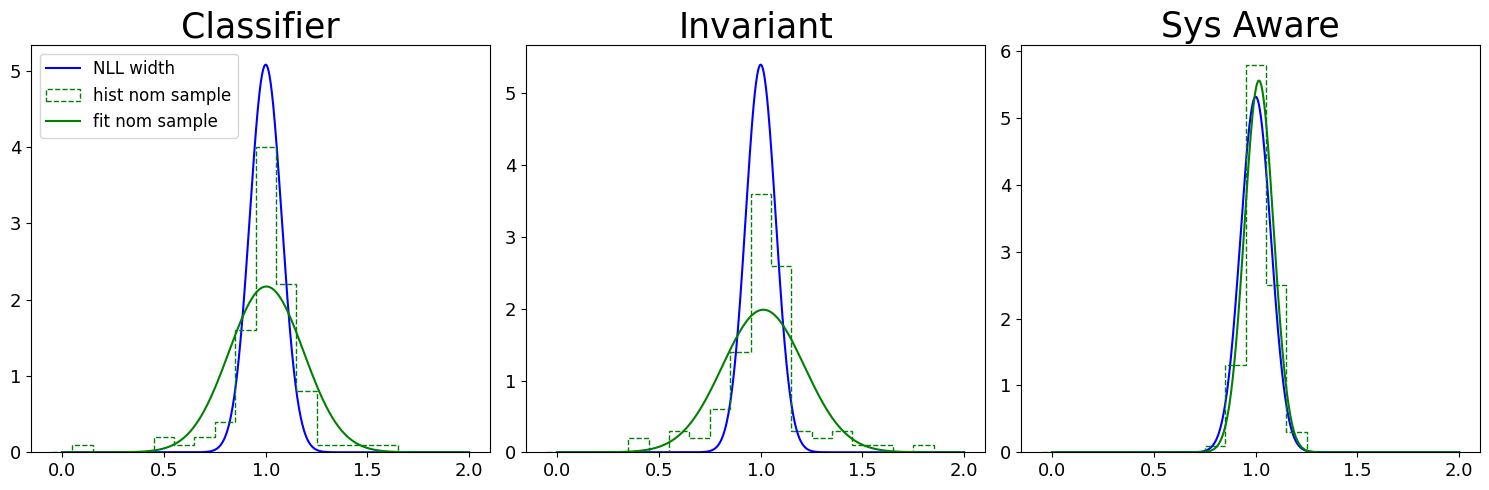

In [132]:
from scipy.stats import norm


fig = plt.figure(figsize=(15,5))
subplot1 = fig.add_subplot(1,3,1)  
subplot2 = fig.add_subplot(1,3,2)  
subplot3 = fig.add_subplot(1,3,3)  

x_gauss = np.linspace(0.0, 2.0, 1000)


y_gauss = (norm.pdf((x_gauss-1)/sigma_clf_nom))/sigma_clf_nom

subplot1.title.set_text('Classifier')
subplot2.title.set_text('Invariant')
subplot3.title.set_text('Sys Aware')

subplot1.plot(x_gauss, (norm.pdf((x_gauss-1)/sigma_clf_nom))/sigma_clf_nom, label='NLL width', color='b')
subplot2.plot(x_gauss, (norm.pdf((x_gauss-1)/sigma_inv_nom))/sigma_inv_nom, label='NLL width', color='b')
subplot3.plot(x_gauss, (norm.pdf((x_gauss-1)/sigma_awe_nom))/sigma_awe_nom, label='NLL width', color='b')


y_gauss_fit = (norm.pdf((x_gauss-np.mean(mus_clf_nom))/np.std(mus_clf_nom)))/np.std(mus_clf_nom)


subplot1.hist(mus_clf_nomsamp, bins=np.arange(-0.05, 2.05, 0.1), density = True, label='hist nom sample', histtype='step', color='g', ls='--')
subplot2.hist(mus_inv_nomsamp, bins=np.arange(-0.05, 2.05, 0.1), density = True, label='hist nom sample', histtype='step', color='g', ls='--')
subplot3.hist(mus_awe_nomsamp, bins=np.arange(-0.05, 2.05, 0.1), density = True, label='hist nom sample', histtype='step', color='g', ls='--')



subplot1.plot(x_gauss, (norm.pdf((x_gauss-np.mean(mus_clf_nomsamp))/np.std(mus_clf_nomsamp)))/np.std(mus_clf_nomsamp), label='fit nom sample', color='g')
subplot2.plot(x_gauss, (norm.pdf((x_gauss-np.mean(mus_inv_nomsamp))/np.std(mus_inv_nomsamp)))/np.std(mus_inv_nomsamp), label='fit nom sample', color='g')
subplot3.plot(x_gauss, (norm.pdf((x_gauss-np.mean(mus_awe_nomsamp))/np.std(mus_awe_nomsamp)))/np.std(mus_awe_nomsamp), label='fit nom sample', color='g')


subplot1.legend(loc = 'upper left', fontsize=12)
plt.savefig('nomsamp.png')

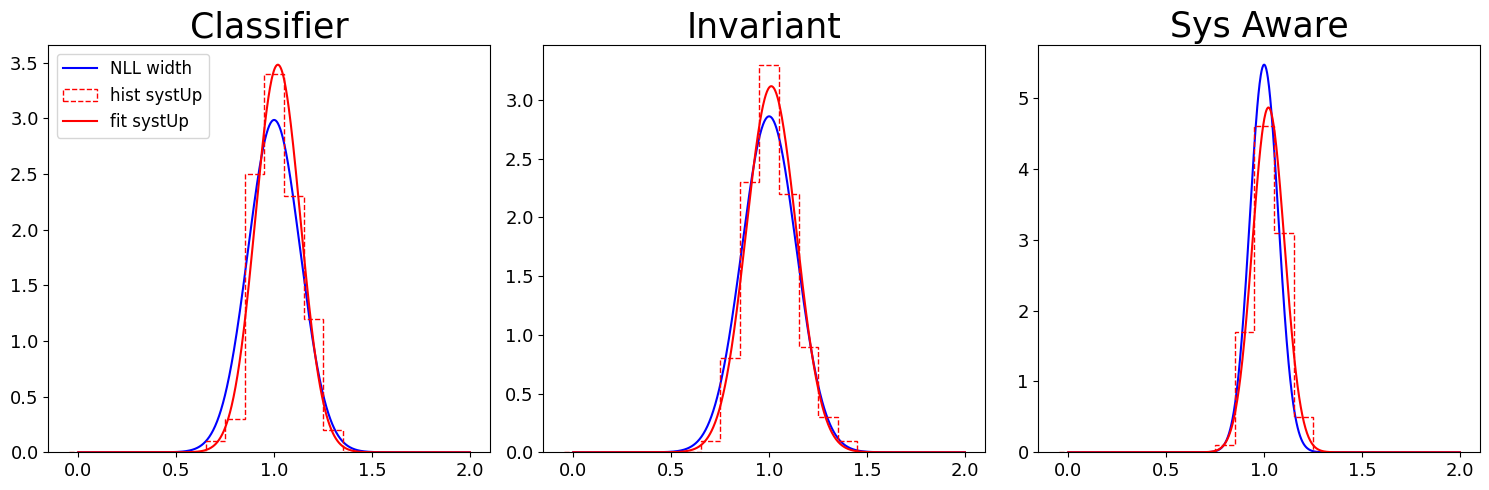

In [131]:
from scipy.stats import norm


fig = plt.figure(figsize=(15,5))
subplot1 = fig.add_subplot(1,3,1)  
subplot2 = fig.add_subplot(1,3,2)  
subplot3 = fig.add_subplot(1,3,3)  

x_gauss = np.linspace(0.0, 2.0, 1000)


y_gauss = (norm.pdf((x_gauss-1)/sigma_clf_systUp))/sigma_clf_systUp

subplot1.title.set_text('Classifier')
subplot2.title.set_text('Invariant')
subplot3.title.set_text('Sys Aware')

subplot1.plot(x_gauss, (norm.pdf((x_gauss-1)/sigma_clf_systUp))/sigma_clf_systUp, label='NLL width', color='b')
subplot2.plot(x_gauss, (norm.pdf((x_gauss-1)/sigma_inv_systUp))/sigma_inv_systUp, label='NLL width', color='b')
subplot3.plot(x_gauss, (norm.pdf((x_gauss-1)/sigma_awe_systUp))/sigma_awe_systUp, label='NLL width', color='b')


y_gauss_fit = (norm.pdf((x_gauss-np.mean(mus_clf_systUp))/np.std(mus_clf_systUp)))/np.std(mus_clf_systUp)


subplot1.hist(mus_clf_systUp, bins=np.arange(-0.05, 2.05, 0.1), density = True, label='hist systUp', histtype='step', color='r', ls='--')
subplot2.hist(mus_inv_systUp, bins=np.arange(-0.05, 2.05, 0.1), density = True, label='hist systUp', histtype='step', color='r', ls='--')
subplot3.hist(mus_awe_systUp, bins=np.arange(-0.05, 2.05, 0.1), density = True, label='hist systUp', histtype='step', color='r', ls='--')



subplot1.plot(x_gauss, (norm.pdf((x_gauss-np.mean(mus_clf_systUp))/np.std(mus_clf_systUp)))/np.std(mus_clf_systUp), label='fit systUp', color='r')
subplot2.plot(x_gauss, (norm.pdf((x_gauss-np.mean(mus_inv_systUp))/np.std(mus_inv_systUp)))/np.std(mus_inv_systUp), label='fit systUp', color='r')
subplot3.plot(x_gauss, (norm.pdf((x_gauss-np.mean(mus_awe_systUp))/np.std(mus_awe_systUp)))/np.std(mus_awe_systUp), label='fit systUp', color='r')


subplot1.legend(loc = 'upper left', fontsize=12)
plt.savefig('systUp.png')

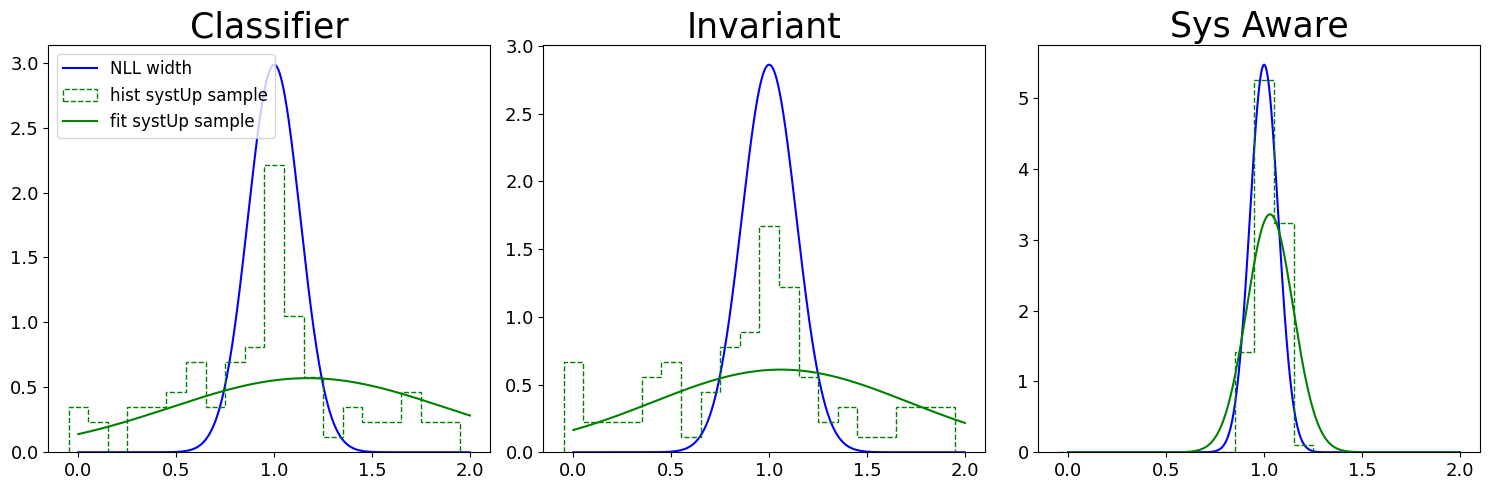

In [134]:
from scipy.stats import norm


fig = plt.figure(figsize=(15,5))
subplot1 = fig.add_subplot(1,3,1)  
subplot2 = fig.add_subplot(1,3,2)  
subplot3 = fig.add_subplot(1,3,3)  

x_gauss = np.linspace(0.0, 2.0, 1000)


y_gauss = (norm.pdf((x_gauss-1)/sigma_clf_systUp))/sigma_clf_systUp

subplot1.title.set_text('Classifier')
subplot2.title.set_text('Invariant')
subplot3.title.set_text('Sys Aware')

subplot1.plot(x_gauss, (norm.pdf((x_gauss-1)/sigma_clf_systUp))/sigma_clf_systUp, label='NLL width', color='b')
subplot2.plot(x_gauss, (norm.pdf((x_gauss-1)/sigma_inv_systUp))/sigma_inv_systUp, label='NLL width', color='b')
subplot3.plot(x_gauss, (norm.pdf((x_gauss-1)/sigma_awe_systUp))/sigma_awe_systUp, label='NLL width', color='b')


y_gauss_fit = (norm.pdf((x_gauss-np.mean(mus_clf_systUp))/np.std(mus_clf_systUp)))/np.std(mus_clf_systUp)


subplot1.hist(mus_clf_systUpsamp, bins=np.arange(-0.05, 2.05, 0.1), density = True, label='hist systUp sample', histtype='step', color='g', ls='--')
subplot2.hist(mus_inv_systUpsamp, bins=np.arange(-0.05, 2.05, 0.1), density = True, label='hist systUp sample', histtype='step', color='g', ls='--')
subplot3.hist(mus_awe_systUpsamp, bins=np.arange(-0.05, 2.05, 0.1), density = True, label='hist systUp sample', histtype='step', color='g', ls='--')



subplot1.plot(x_gauss, (norm.pdf((x_gauss-np.mean(mus_clf_systUpsamp))/np.std(mus_clf_systUpsamp)))/np.std(mus_clf_systUpsamp), label='fit systUp sample', color='g')
subplot2.plot(x_gauss, (norm.pdf((x_gauss-np.mean(mus_inv_systUpsamp))/np.std(mus_inv_systUpsamp)))/np.std(mus_inv_systUpsamp), label='fit systUp sample', color='g')
subplot3.plot(x_gauss, (norm.pdf((x_gauss-np.mean(mus_awe_systUpsamp))/np.std(mus_awe_systUpsamp)))/np.std(mus_awe_systUpsamp), label='fit systUp sample', color='g')


subplot1.legend(loc = 'upper left', fontsize=12)
plt.savefig('systUpsamp.png')

0.084829240241794 0.09402578471369638
0.34106304402558774 0.09402578471369638


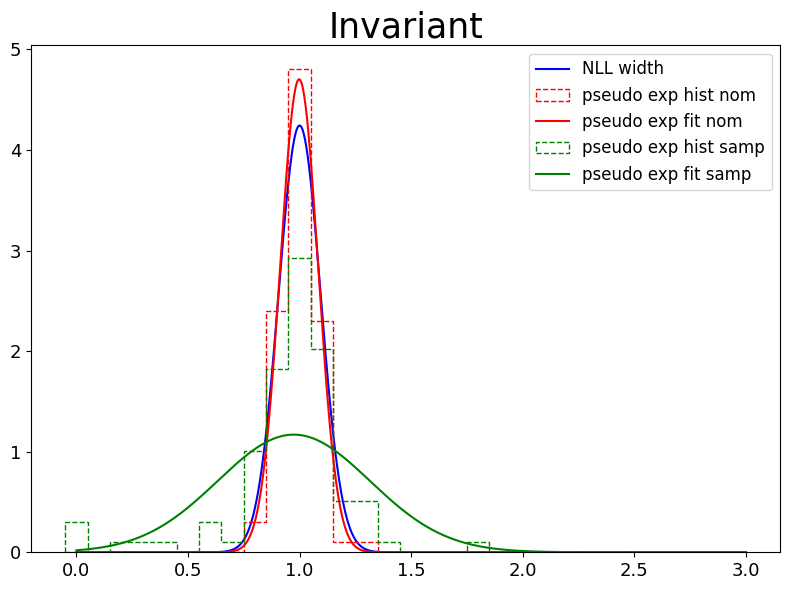

In [100]:

fig = plt.figure(figsize=(8,6))
subplot = fig.add_subplot(1,1,1)  

x_gauss = np.linspace(0.0, 3.0, 1000)
y_gauss = (norm.pdf((x_gauss-1)/sigma_inv_nom))/sigma_inv_nom
print(np.std(mus_inv_nom), sigma_inv_nom)

y_gauss_fit = (norm.pdf((x_gauss-np.mean(mus_inv_nom))/np.std(mus_inv_nom)))/np.std(mus_inv_nom)


subplot.plot(x_gauss, y_gauss, label='NLL width', color='b')
subplot.hist(mus_inv_nom, bins=np.arange(-0.05, 2.25, 0.1), density = True, label='pseudo exp hist nom', histtype='step', color='r', ls='--')
subplot.plot(x_gauss, y_gauss_fit, label='pseudo exp fit nom', color='r')




subplot.hist(mus_inv_samp, bins=np.arange(-0.05, 2.25, 0.1), density = True, label='pseudo exp hist samp', histtype='step', color='g', ls='--')

y_gauss = (norm.pdf((x_gauss-1)/sigma_inv_nom))/sigma_inv_nom
print(np.std(mus_inv_samp), sigma_inv_nom)

y_gauss_fit = (norm.pdf((x_gauss-np.mean(mus_inv_samp))/np.std(mus_inv_samp)))/np.std(mus_inv_samp)

subplot.title.set_text('Invariant')

subplot.plot(x_gauss, y_gauss_fit, label='pseudo exp fit samp', color='g')
subplot.legend(fontsize=12)


0.08 0.09053964630475846
0.33670610330078665 0.09053964630475846


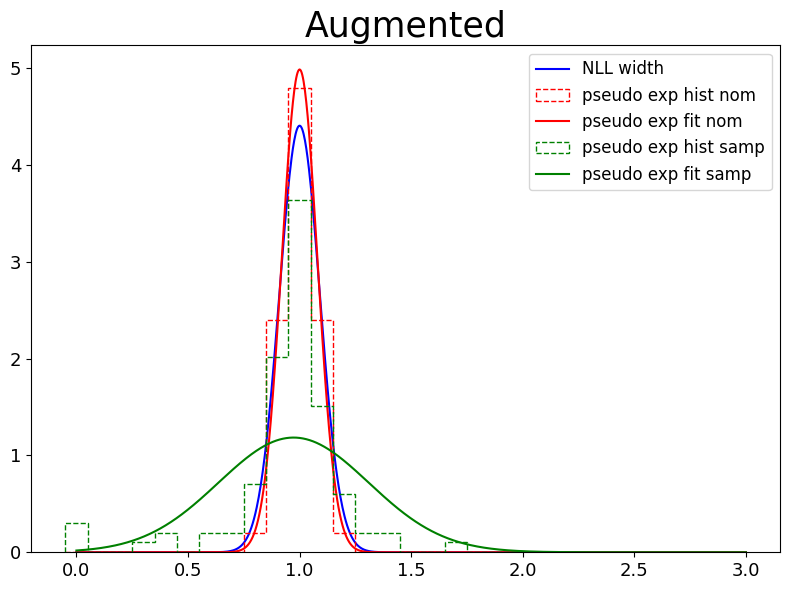

In [101]:

fig = plt.figure(figsize=(8,6))
subplot = fig.add_subplot(1,1,1)  

x_gauss = np.linspace(0.0, 3.0, 1000)
y_gauss = (norm.pdf((x_gauss-1)/sigma_aug_nom))/sigma_aug_nom
print(np.std(mus_aug_nom), sigma_aug_nom)

y_gauss_fit = (norm.pdf((x_gauss-np.mean(mus_aug_nom))/np.std(mus_aug_nom)))/np.std(mus_aug_nom)


subplot.plot(x_gauss, y_gauss, label='NLL width', color='b')
subplot.hist(mus_aug_nom, bins=np.arange(-0.05, 2.25, 0.1), density = True, label='pseudo exp hist nom', histtype='step', color='r', ls='--')
subplot.plot(x_gauss, y_gauss_fit, label='pseudo exp fit nom', color='r')




subplot.hist(mus_aug_samp, bins=np.arange(-0.05, 2.25, 0.1), density = True, label='pseudo exp hist samp', histtype='step', color='g', ls='--')

y_gauss = (norm.pdf((x_gauss-1)/sigma_aug_nom))/sigma_aug_nom
print(np.std(mus_aug_samp), sigma_aug_nom)

y_gauss_fit = (norm.pdf((x_gauss-np.mean(mus_aug_samp))/np.std(mus_aug_samp)))/np.std(mus_aug_samp)

subplot.title.set_text('Augmented')

subplot.plot(x_gauss, y_gauss_fit, label='pseudo exp fit samp', color='g')
subplot.legend(fontsize=12)


0.07110555533852472 0.07599512614254623
0.06837397165588674 0.07599512614254623


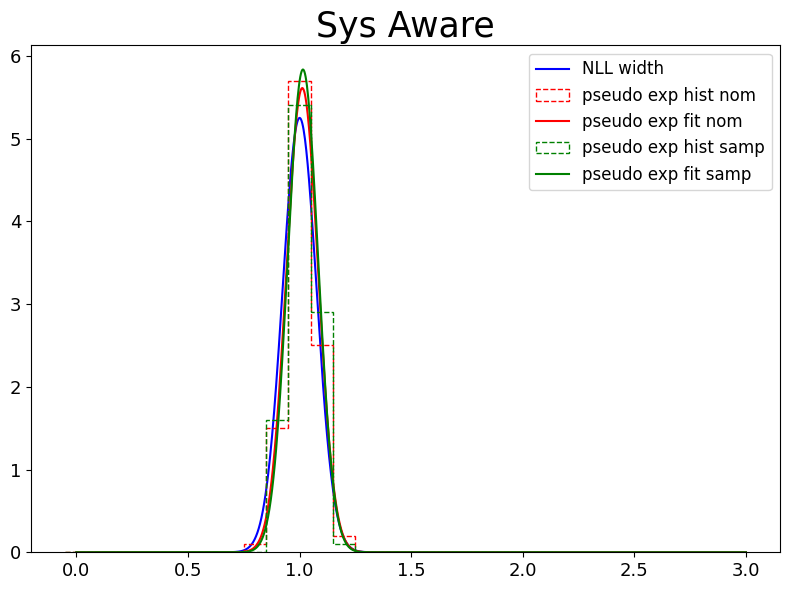

In [102]:

fig = plt.figure(figsize=(8,6))
subplot = fig.add_subplot(1,1,1)  

x_gauss = np.linspace(0.0, 3.0, 1000)
y_gauss = (norm.pdf((x_gauss-1)/sigma_awe_nom))/sigma_awe_nom
print(np.std(mus_awe_nom), sigma_awe_nom)

y_gauss_fit = (norm.pdf((x_gauss-np.mean(mus_awe_nom))/np.std(mus_awe_nom)))/np.std(mus_awe_nom)


subplot.plot(x_gauss, y_gauss, label='NLL width', color='b')
subplot.hist(mus_awe_nom, bins=np.arange(-0.05, 2.25, 0.1), density = True, label='pseudo exp hist nom', histtype='step', color='r', ls='--')
subplot.plot(x_gauss, y_gauss_fit, label='pseudo exp fit nom', color='r')




subplot.hist(mus_awe_samp, bins=np.arange(-0.05, 2.25, 0.1), density = True, label='pseudo exp hist samp', histtype='step', color='g', ls='--')

y_gauss = (norm.pdf((x_gauss-1)/sigma_awe_nom))/sigma_awe_nom
print(np.std(mus_awe_samp), sigma_awe_nom)

y_gauss_fit = (norm.pdf((x_gauss-np.mean(mus_awe_samp))/np.std(mus_awe_samp)))/np.std(mus_awe_samp)

subplot.title.set_text('Sys Aware')

subplot.plot(x_gauss, y_gauss_fit, label='pseudo exp fit samp', color='g')
subplot.legend(fontsize=12)


In [ ]:
mus = np.array(mus)


cov_1sig = sum(abs(mus-1) < sigma_clf_samp)/n_exp
cov_2sig = sum(abs(mus-1) < sigma_clf_samp*2)/n_exp
cov_3sig = sum(abs(mus-1) < sigma_clf_samp*3)/n_exp

print('1 Sigma: {:.2f} \n'.format(cov_1sig) + 
      '2 Sigma: {:.2f} \n'.format(cov_2sig) + 
      '3 Sigma: {:.2f} '.format(cov_3sig))
    
    

